In [1]:
# =============================================================================
# CELL 1: Imports and Setup
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported!")


✅ Libraries imported!


In [2]:
# =============================================================================
# CELL 2: Load WA Dataset
# =============================================================================
print("📁 Loading WA Telecom Dataset...")
wa_data = pd.read_csv('/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(f"✅ Loaded: {wa_data.shape}")
print(f"Columns: {list(wa_data.columns)}")
print("\nFirst 3 rows:")
display(wa_data.head(15))


📁 Loading WA Telecom Dataset...
✅ Loaded: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

First 3 rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [3]:
# =============================================================================
# CELL 3: Enhanced Data Cleaning & Preprocessing
# =============================================================================
# Strip whitespace from string columns
wa_data = wa_data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

# Convert 'TotalCharges' to numeric (some may be empty strings)
wa_data['TotalCharges'] = pd.to_numeric(wa_data['TotalCharges'], errors='coerce')

# Fill missing numeric values
num_cols = wa_data.select_dtypes(include=['float64','int64']).columns
wa_data[num_cols] = wa_data[num_cols].fillna(wa_data[num_cols].median())

# =============================================================================
# DROP NON-PREDICTIVE IDENTIFIERS
# =============================================================================
# Remove customerID - unique identifier with no predictive power
if 'customerID' in wa_data.columns:
    wa_data = wa_data.drop('customerID', axis=1)
    print("✅ Dropped 'customerID' column")

# =============================================================================
# HANDLE ANY NaN VALUES IN CATEGORICAL COLUMNS BEFORE ENCODING
# =============================================================================
# Fill NaN in categorical columns with 'Unknown' before encoding
cat_cols_with_nan = wa_data.select_dtypes(include=['object']).columns
for col in cat_cols_with_nan:
    if wa_data[col].isnull().any():
        print(f"⚠️  Found {wa_data[col].isnull().sum()} NaN values in '{col}' - filling with 'Unknown'")
        wa_data[col] = wa_data[col].fillna('Unknown')

# =============================================================================
# SPECIAL HANDLING: "No internet service" and "No phone service"
# =============================================================================
# These represent a different category than just "No", so encode separately

# Columns that have "No internet service" as a value
internet_dependent_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                           'TechSupport', 'StreamingTV', 'StreamingMovies']

# Encode: Yes=1, No=0, No internet service=2
for col in internet_dependent_cols:
    if col in wa_data.columns:
        wa_data[col] = wa_data[col].map({
            'Yes': 1,
            'No': 0,
            'No internet service': 2
        })
        # Fill any unmapped values (NaN from mapping) with 0
        wa_data[col] = wa_data[col].fillna(0)

# MultipleLines: Yes=1, No=0, No phone service=2
if 'MultipleLines' in wa_data.columns:
    wa_data['MultipleLines'] = wa_data['MultipleLines'].map({
        'Yes': 1,
        'No': 0,
        'No phone service': 2
    })
    # Fill any unmapped values with 0
    wa_data['MultipleLines'] = wa_data['MultipleLines'].fillna(0)

# =============================================================================
# ORDINAL ENCODING FOR NATURALLY ORDERED CATEGORICAL VARIABLES
# =============================================================================

# InternetService: DSL=1, Fiber optic=2, No=0 (No internet is the baseline)
if 'InternetService' in wa_data.columns:
    wa_data['InternetService'] = wa_data['InternetService'].map({
        'No': 0,
        'DSL': 1,
        'Fiber optic': 2
    })
    wa_data['InternetService'] = wa_data['InternetService'].fillna(0)
    print("✅ Ordinal encoded 'InternetService': No=0, DSL=1, Fiber optic=2")

# Contract: Month-to-month=0, One year=1, Two year=2 (longer commitment = higher value)
if 'Contract' in wa_data.columns:
    wa_data['Contract'] = wa_data['Contract'].map({
        'Month-to-month': 0,
        'One year': 1,
        'Two year': 2
    })
    wa_data['Contract'] = wa_data['Contract'].fillna(0)
    print("✅ Ordinal encoded 'Contract': Month-to-month=0, One year=1, Two year=2")

# PaymentMethod: Electronic check=1, Mailed check=2, Bank transfer=3, Credit card=4
# (More automated/reliable payment methods get higher values)
if 'PaymentMethod' in wa_data.columns:
    wa_data['PaymentMethod'] = wa_data['PaymentMethod'].map({
        'Electronic check': 1,
        'Mailed check': 2,
        'Bank transfer (automatic)': 3,
        'Credit card (automatic)': 4
    })
    wa_data['PaymentMethod'] = wa_data['PaymentMethod'].fillna(1)
    print("✅ Ordinal encoded 'PaymentMethod': Electronic check=1, Mailed check=2, Bank transfer=3, Credit card=4")

# =============================================================================
# ENCODE OTHER BINARY VARIABLES
# =============================================================================
# These are true binary (only Yes/No or Female/Male)
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
               'PaperlessBilling', 'Churn']

for col in binary_cols:
    if col in wa_data.columns:
        # Check for any NaN before encoding
        if wa_data[col].isnull().any():
            print(f"⚠️  Found NaN in '{col}' before encoding - this shouldn't happen!")
            wa_data[col] = wa_data[col].fillna(wa_data[col].mode()[0])  # Fill with most common

        le = LabelEncoder()
        wa_data[col] = le.fit_transform(wa_data[col])

# =============================================================================
# ONE-HOT ENCODE ANY REMAINING CATEGORICAL VARIABLES (if any)
# =============================================================================
# After our manual encoding, check if any categorical columns remain
remaining_cat_cols = wa_data.select_dtypes(include=['object']).columns
if len(remaining_cat_cols) > 0:
    print(f"One-hot encoding remaining categorical columns: {list(remaining_cat_cols)}")
    wa_data = pd.get_dummies(wa_data, columns=remaining_cat_cols, drop_first=True)

print("✅ Enhanced preprocessing complete")
print(f"Final feature count: {wa_data.shape[1]}")
print(f"Final columns: {list(wa_data.columns)}")

# Final check for any remaining NaN values
if wa_data.isnull().any().any():
    print("\n⚠️  WARNING: NaN values still present after preprocessing!")
    print("Columns with NaN:")
    print(wa_data.columns[wa_data.isnull().any()].tolist())
else:
    print("✅ No NaN values detected - data is clean!")

✅ Dropped 'customerID' column
✅ Ordinal encoded 'InternetService': No=0, DSL=1, Fiber optic=2
✅ Ordinal encoded 'Contract': Month-to-month=0, One year=1, Two year=2
✅ Ordinal encoded 'PaymentMethod': Electronic check=1, Mailed check=2, Bank transfer=3, Credit card=4
✅ Enhanced preprocessing complete
Final feature count: 20
Final columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
✅ No NaN values detected - data is clean!


In [4]:
# =============================================================================
# STATISTICAL ANALYSIS - AFTER PREPROCESSING
# Run this immediately after your preprocessing block
# =============================================================================
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("STATISTICAL ANALYSIS")
print("="*70)

# =============================================================================
# SEPARATE TARGET AND FEATURES
# =============================================================================
if 'Churn' in wa_data.columns:
    y = wa_data['Churn']
    X = wa_data.drop('Churn', axis=1)
    print(f"\nDataset shape: {wa_data.shape}")
    print(f"Features: {X.shape[1]}")
    print(f"Target: Churn")
    print(f"  - Class 0 (No Churn): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
    print(f"  - Class 1 (Churn): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")
else:
    print("\nNo Churn column found - analyzing all features")
    X = wa_data.copy()
    y = None

# =============================================================================
# BASIC STATISTICS
# =============================================================================
print("\n" + "="*70)
print("FEATURE OVERVIEW")
print("="*70)

print(f"\nData types:")
print(X.dtypes.value_counts())

print(f"\nNumeric features summary:")
numeric_cols = X.select_dtypes(include=[np.number]).columns
print(X[numeric_cols].describe().round(2))

# =============================================================================
# CORRELATION WITH TARGET
# =============================================================================
if y is not None:
    print("\n" + "="*70)
    print("CORRELATION WITH CHURN")
    print("="*70)

    correlations = X.corrwith(y).abs().sort_values(ascending=False)

    # Separate valid and invalid correlations
    valid_corr = correlations.dropna()
    invalid_corr = correlations[correlations.isna()]

    if len(invalid_corr) > 0:
        print(f"\nWARNING: {len(invalid_corr)} features have NaN correlation (zero variance):")
        for feat in invalid_corr.index:
            print(f"  - {feat}: {X[feat].nunique()} unique values = {X[feat].unique()}")

    print(f"\nTop 20 Features by Correlation with Churn:")
    print("-"*60)
    for i, (feat, corr) in enumerate(valid_corr.head(20).items(), 1):
        if corr >= 0.3:
            strength = "STRONG  "
        elif corr >= 0.15:
            strength = "MODERATE"
        elif corr >= 0.05:
            strength = "WEAK    "
        else:
            strength = "MINIMAL "
        print(f"{i:2d}. [{strength}] {feat:35s} r={corr:+.4f}")

# =============================================================================
# VARIANCE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("FEATURE VARIANCE")
print("="*70)

variances = X[numeric_cols].var().sort_values(ascending=False)

print("\nHighest variance features:")
for feat, var in variances.head(10).items():
    print(f"  {feat:35s} var={var:.2f}")

print("\nZero/Near-zero variance features:")
zero_var = []
for feat, var in variances.items():
    if var < 0.01:
        zero_var.append(feat)
        print(f"  {feat:35s} var={var:.6f}, unique={X[feat].nunique()}, values={X[feat].unique()[:5]}")

if len(zero_var) > 0:
    print(f"\nTotal zero-variance features: {len(zero_var)}")
    print("These features may need investigation or removal")

# =============================================================================
# MULTICOLLINEARITY
# =============================================================================
print("\n" + "="*70)
print("MULTICOLLINEARITY")
print("="*70)

corr_matrix = X[numeric_cols].corr()
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = abs(corr_matrix.iloc[i, j])
        if corr_val > 0.7:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

if len(high_corr_pairs) > 0:
    print(f"\nFound {len(high_corr_pairs)} highly correlated pairs (|r| > 0.7):")
    for pair in sorted(high_corr_pairs, key=lambda x: x['Correlation'], reverse=True):
        print(f"  {pair['Feature 1']:30s} <-> {pair['Feature 2']:30s} r={pair['Correlation']:.3f}")
else:
    print("\nNo high multicollinearity detected")

# =============================================================================
# FEATURE SKEWNESS
# =============================================================================
print("\n" + "="*70)
print("FEATURE DISTRIBUTIONS")
print("="*70)

skewness = X[numeric_cols].skew().abs().sort_values(ascending=False)

print("\nMost skewed features:")
for feat, skew in skewness.head(10).items():
    if skew > 1:
        level = "HIGHLY SKEWED"
    elif skew > 0.5:
        level = "MODERATELY SKEWED"
    else:
        level = "NORMAL"
    print(f"  [{level:18s}] {feat:30s} skew={skew:+.2f}")

# =============================================================================
# CATEGORICAL FEATURE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("CATEGORICAL FEATURES")
print("="*70)

binary_features = []
multiclass_features = []

for col in X.columns:
    n_unique = X[col].nunique()
    if n_unique == 2:
        binary_features.append(col)
    elif n_unique <= 10 and n_unique > 2:
        multiclass_features.append((col, n_unique))

print(f"\nBinary features ({len(binary_features)}):")
for feat in binary_features:
    counts = X[feat].value_counts()
    print(f"  {feat:35s} {dict(counts)}")

if len(multiclass_features) > 0:
    print(f"\nMulti-class features ({len(multiclass_features)}):")
    for feat, n_classes in multiclass_features:
        counts = X[feat].value_counts()
        print(f"  {feat:35s} {n_classes} classes: {dict(counts)}")

# =============================================================================
# CHI-SQUARE TEST
# =============================================================================
if y is not None and len(binary_features) > 0:
    print("\n" + "="*70)
    print("CHI-SQUARE TEST (Binary Features vs Churn)")
    print("="*70)

    chi_results = []
    for feat in binary_features:
        try:
            contingency = pd.crosstab(X[feat], y)
            chi2, p_val, dof, expected = chi2_contingency(contingency)
            chi_results.append({
                'Feature': feat,
                'Chi2': chi2,
                'P-value': p_val,
                'Significant': p_val < 0.05
            })
        except:
            pass

    chi_df = pd.DataFrame(chi_results).sort_values('Chi2', ascending=False)

    print(f"\n{'Feature':<35s} {'Chi2':<12s} {'P-value':<12s} Sig")
    print("-"*70)
    for _, row in chi_df.head(15).iterrows():
        sig = "YES" if row['Significant'] else "NO"
        print(f"{row['Feature']:<35s} {row['Chi2']:<12.2f} {row['P-value']:<12.6f} {sig}")

    print(f"\n{len(chi_df[chi_df['Significant']])} of {len(chi_df)} features are statistically significant (p < 0.05)")

# =============================================================================
# FEATURE GROUPING SUGGESTIONS
# =============================================================================
print("\n" + "="*70)
print("FEATURE GROUPING FOR ENGINEERING")
print("="*70)

groups = {
    'CORE_FINANCIAL': [],
    'SERVICE_FEATURES': [],
    'BASIC_CONNECTIVITY': [],
    'DEMOGRAPHICS': [],
    'USAGE_METRICS': [],
    'BILLING_PAYMENT': []
}

for col in X.columns:
    col_lower = col.lower()

    if any(term in col_lower for term in ['monthlycharges', 'tenure']):
        groups['CORE_FINANCIAL'].append(col)
    elif any(term in col_lower for term in ['online', 'streaming', 'device', 'protection', 'backup', 'security', 'tech', 'support']):
        groups['SERVICE_FEATURES'].append(col)
    elif any(term in col_lower for term in ['phone', 'internet', 'multiple', 'line']):
        groups['BASIC_CONNECTIVITY'].append(col)
    elif any(term in col_lower for term in ['gender', 'senior', 'partner', 'dependent', 'age']):
        groups['DEMOGRAPHICS'].append(col)
    elif any(term in col_lower for term in ['call', 'failure', 'complain', 'subscription', 'frequency', 'use']):
        groups['USAGE_METRICS'].append(col)
    elif any(term in col_lower for term in ['payment', 'billing', 'paperless', 'contract']):
        groups['BILLING_PAYMENT'].append(col)

for group_name, features in groups.items():
    if len(features) > 0:
        print(f"\n{group_name} ({len(features)} features):")
        for feat in features:
            if y is not None and feat in valid_corr.index:
                corr = X[feat].corr(y)
                print(f"  - {feat:35s} r={corr:+.4f}")
            else:
                print(f"  - {feat}")

# =============================================================================
# SUMMARY
# =============================================================================
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nTotal features analyzed: {X.shape[1]}")
print(f"Binary features: {len(binary_features)}")
print(f"Multi-class features: {len(multiclass_features)}")
if len(zero_var) > 0:
    print(f"Zero-variance features: {len(zero_var)} (investigate these)")
if len(high_corr_pairs) > 0:
    print(f"Highly correlated pairs: {len(high_corr_pairs)} (potential redundancy)")

if y is not None:
    strong = len(valid_corr[valid_corr >= 0.3])
    moderate = len(valid_corr[(valid_corr >= 0.15) & (valid_corr < 0.3)])
    weak = len(valid_corr[valid_corr < 0.15])
    print(f"\nCorrelation strength:")
    print(f"  - Strong (r>=0.3): {strong} features")
    print(f"  - Moderate (0.15<=r<0.3): {moderate} features")
    print(f"  - Weak (r<0.15): {weak} features")

print("\n" + "="*70)
print("Analysis complete - ready for feature engineering")
print("="*70)

STATISTICAL ANALYSIS

Dataset shape: (7043, 20)
Features: 19
Target: Churn
  - Class 0 (No Churn): 5174 (73.5%)
  - Class 1 (Churn): 1869 (26.5%)

FEATURE OVERVIEW

Data types:
int64      17
float64     2
Name: count, dtype: int64

Numeric features summary:
       gender  SeniorCitizen  Partner  Dependents   tenure  PhoneService  \
count  7043.0        7043.00  7043.00     7043.00  7043.00        7043.0   
mean      0.5           0.16     0.48        0.30    32.37           0.9   
std       0.5           0.37     0.50        0.46    24.56           0.3   
min       0.0           0.00     0.00        0.00     0.00           0.0   
25%       0.0           0.00     0.00        0.00     9.00           1.0   
50%       1.0           0.00     0.00        0.00    29.00           1.0   
75%       1.0           0.00     1.00        1.00    55.00           1.0   
max       1.0           1.00     1.00        1.00    72.00           1.0   

       MultipleLines  InternetService  OnlineSecurity  On

In [33]:
# =============================================================================
# FALSE POSITIVE & FALSE NEGATIVE INFLUENCE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("FALSE POSITIVE & FALSE NEGATIVE INFLUENCE ANALYSIS")
print("="*70)

# First, let's run a quick model to get predictions and identify FP/FN cases
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Prepare data
X_analysis = X[numeric_cols].fillna(0)
y_analysis = y

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_analysis, y_analysis, test_size=0.3, random_state=42, stratify=y_analysis
)

# Train a quick Random Forest to get predictions
print("\nTraining quick model to identify FP/FN cases...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Identify FP and FN cases
fp_mask = (y_test == 0) & (y_pred == 1)  # False Positives: Predicted churn but didn't
fn_mask = (y_test == 1) & (y_pred == 0)  # False Negatives: Predicted retain but churned
tp_mask = (y_test == 1) & (y_pred == 1)  # True Positives
tn_mask = (y_test == 0) & (y_pred == 0)  # True Negatives

print(f"\nPrediction Distribution:")
print(f"  True Negatives (TN): {tn_mask.sum():4d} - Correctly predicted retention")
print(f"  False Positives (FP): {fp_mask.sum():4d} - Wrongly predicted churn")
print(f"  False Negatives (FN): {fn_mask.sum():4d} - Missed actual churn")
print(f"  True Positives (TP): {tp_mask.sum():4d} - Correctly predicted churn")

# =============================================================================
# FEATURE ANALYSIS BY PREDICTION GROUP
# =============================================================================
print("\n" + "="*70)
print("FEATURE MEANS BY PREDICTION GROUP")
print("="*70)

# Calculate mean feature values for each group
fp_means = X_test[fp_mask].mean()
fn_means = X_test[fn_mask].mean()
tp_means = X_test[tp_mask].mean()
tn_means = X_test[tn_mask].mean()
overall_means = X_test.mean()

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Overall_Mean': overall_means,
    'TN_Mean': tn_means,
    'FP_Mean': fp_means,
    'FN_Mean': fn_means,
    'TP_Mean': tp_means,
    'FP_vs_TN_Ratio': fp_means / tn_means,
    'FN_vs_TP_Ratio': fn_means / tp_means,
    'FP_Deviation': (fp_means - tn_means) / tn_means * 100,  # % difference from TN
    'FN_Deviation': (fn_means - tp_means) / tp_means * 100   # % difference from TP
})

# Sort by FP influence (largest deviations)
fp_influencers = comparison_df['FP_Deviation'].abs().sort_values(ascending=False)

print(f"\nTOP 20 FEATURES INFLUENCING FALSE POSITIVES:")
print("(Features that differ most between FP and TN cases)")
print("-" * 80)
for i, (feat, deviation) in enumerate(fp_influencers.head(20).items(), 1):
    fp_dev = comparison_df.loc[feat, 'FP_Deviation']
    fp_ratio = comparison_df.loc[feat, 'FP_vs_TN_Ratio']
    overall = comparison_df.loc[feat, 'Overall_Mean']

    if abs(fp_dev) > 20:  # More than 20% difference
        impact = "🚨 HIGH IMPACT"
    elif abs(fp_dev) > 10:
        impact = "⚠ MEDIUM IMPACT"
    else:
        impact = "LOW IMPACT"

    direction = "↑ HIGHER in FP" if fp_dev > 0 else "↓ LOWER in FP"

    print(f"{i:2d}. {impact} {feat:35s} {direction:15s} ({fp_dev:+.1f}%)")
    print(f"     FP/TN Ratio: {fp_ratio:.2f}x, Overall Mean: {overall:.2f}")

# Sort by FN influence
fn_influencers = comparison_df['FN_Deviation'].abs().sort_values(ascending=False)

print(f"\nTOP 20 FEATURES INFLUENCING FALSE NEGATIVES:")
print("(Features that differ most between FN and TP cases)")
print("-" * 80)
for i, (feat, deviation) in enumerate(fn_influencers.head(20).items(), 1):
    fn_dev = comparison_df.loc[feat, 'FN_Deviation']
    fn_ratio = comparison_df.loc[feat, 'FN_vs_TP_Ratio']
    overall = comparison_df.loc[feat, 'Overall_Mean']

    if abs(fn_dev) > 20:
        impact = "🚨 HIGH IMPACT"
    elif abs(fn_dev) > 10:
        impact = "⚠ MEDIUM IMPACT"
    else:
        impact = "LOW IMPACT"

    direction = "↑ HIGHER in FN" if fn_dev > 0 else "↓ LOWER in FN"

    print(f"{i:2d}. {impact} {feat:35s} {direction:15s} ({fn_dev:+.1f}%)")
    print(f"     FN/TP Ratio: {fn_ratio:.2f}x, Overall Mean: {overall:.2f}")

# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("="*70)

feature_importance = pd.DataFrame({
    'feature': numeric_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTOP 30 MOST IMPORTANT FEATURES:")
print("-" * 60)
for i, row in feature_importance.head(30).iterrows():
    # Get FP/FN deviation for context
    fp_dev = comparison_df.loc[row['feature'], 'FP_Deviation'] if row['feature'] in comparison_df.index else 0
    fn_dev = comparison_df.loc[row['feature'], 'FN_Deviation'] if row['feature'] in comparison_df.index else 0

    fp_impact = ""
    if abs(fp_dev) > 20:
        fp_impact = " 🚨FP"
    elif abs(fp_dev) > 10:
        fp_impact = " ⚠FP"

    fn_impact = ""
    if abs(fn_dev) > 20:
        fn_impact = " 🚨FN"
    elif abs(fn_dev) > 10:
        fn_impact = " ⚠FN"

    print(f"{i+1:2d}. {row['feature']:35s} imp={row['importance']:.4f}{fp_impact}{fn_impact}")

# =============================================================================
# SPECIFIC PATTERN ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("FALSE POSITIVE PATTERN ANALYSIS")
print("="*70)

# Analyze what makes FP cases different from TN cases
fp_tn_diff = (fp_means - tn_means).abs().sort_values(ascending=False)

print(f"\nLargest absolute differences (FP vs TN):")
print("-" * 60)
for feat, diff in fp_tn_diff.head(15).items():
    fp_val = fp_means[feat]
    tn_val = tn_means[feat]
    pct_diff = (fp_val - tn_val) / tn_val * 100

    if abs(pct_diff) > 25:
        significance = "🚨 CRITICAL"
    elif abs(pct_diff) > 15:
        significance = "⚠ HIGH"
    else:
        significance = "MEDIUM"

    print(f"{feat:35s}: TN={tn_val:.2f}, FP={fp_val:.2f}, diff={pct_diff:+.1f}% [{significance}]")

print(f"\n" + "="*70)
print("FALSE NEGATIVE PATTERN ANALYSIS")
print("="*70)

# Analyze what makes FN cases different from TP cases
fn_tp_diff = (fn_means - tp_means).abs().sort_values(ascending=False)

print(f"\nLargest absolute differences (FN vs TP):")
print("-" * 60)
for feat, diff in fn_tp_diff.head(15).items():
    fn_val = fn_means[feat]
    tp_val = tp_means[feat]
    pct_diff = (fn_val - tp_val) / tp_val * 100

    if abs(pct_diff) > 25:
        significance = "🚨 CRITICAL"
    elif abs(pct_diff) > 15:
        significance = "⚠ HIGH"
    else:
        significance = "MEDIUM"

    print(f"{feat:35s}: TP={tp_val:.2f}, FN={fn_val:.2f}, diff={pct_diff:+.1f}% [{significance}]")

# =============================================================================
# RECOMMENDATIONS
# =============================================================================
print("\n" + "="*70)
print("RECOMMENDATIONS FOR IMPROVING MODEL")
print("="*70)

# Identify features that strongly influence FP
strong_fp_features = comparison_df[comparison_df['FP_Deviation'].abs() > 20].index.tolist()
strong_fn_features = comparison_df[comparison_df['FN_Deviation'].abs() > 20].index.tolist()

if strong_fp_features:
    print(f"\n🚨 ADDRESS FALSE POSITIVES - Focus on these {len(strong_fp_features)} features:")
    for feat in strong_fp_features[:10]:
        dev = comparison_df.loc[feat, 'FP_Deviation']
        direction = "too HIGH" if dev > 0 else "too LOW"
        print(f"   - {feat}: FP values are {direction} by {abs(dev):.1f}% compared to TN")

if strong_fn_features:
    print(f"\n🚨 ADDRESS FALSE NEGATIVES - Focus on these {len(strong_fn_features)} features:")
    for feat in strong_fn_features[:10]:
        dev = comparison_df.loc[feat, 'FN_Deviation']
        direction = "too HIGH" if dev > 0 else "too LOW"
        print(f"   - {feat}: FN values are {direction} by {abs(dev):.1f}% compared to TP")

# Feature engineering suggestions
print(f"\n💡 FEATURE ENGINEERING SUGGESTIONS:")
print(f"   1. Create interaction terms for high-FP-impact features")
print(f"   2. Add non-linear transformations for skewed high-impact features")
print(f"   3. Consider threshold-based features for extreme values")
print(f"   4. Create ratio features between FP-influencing and FN-influencing features")

print(f"\n📊 BUSINESS IMPACT:")
print(f"   - Reducing FPs: Prevents unnecessary retention spending on loyal customers")
print(f"   - Reducing FNs: Captures more actual churners for proactive intervention")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)


FALSE POSITIVE & FALSE NEGATIVE INFLUENCE ANALYSIS

Training quick model to identify FP/FN cases...

Prediction Distribution:
  True Negatives (TN): 1377 - Correctly predicted retention
  False Positives (FP):  175 - Wrongly predicted churn
  False Negatives (FN):  287 - Missed actual churn
  True Positives (TP):  274 - Correctly predicted churn

FEATURE MEANS BY PREDICTION GROUP

TOP 20 FEATURES INFLUENCING FALSE POSITIVES:
(Features that differ most between FP and TN cases)
--------------------------------------------------------------------------------
 1. 🚨 HIGH IMPACT SeniorCitizen                       ↑ HIGHER in FP  (+158.8%)
     FP/TN Ratio: 2.59x, Overall Mean: 0.16
 2. 🚨 HIGH IMPACT Contract                            ↓ LOWER in FP   (-97.1%)
     FP/TN Ratio: 0.03x, Overall Mean: 0.68
 3. 🚨 HIGH IMPACT OnlineSecurity                      ↓ LOWER in FP   (-72.8%)
     FP/TN Ratio: 0.27x, Overall Mean: 0.72
 4. 🚨 HIGH IMPACT Dependents                          ↓ LOWER in FP

In [36]:
# =============================================================================
# 9. EDGE-CASE & FALSE POSITIVE REDUCTION FEATURES
# =============================================================================
print("\n[9/8] Creating Edge-Case & False Positive Reduction Features...")

# -----------------------------------------------------------------------------
# Feature 1: inertia_loyalty_score
# -----------------------------------------------------------------------------
# Captures customers with high tenure but simple service usage patterns
# These customers have established inertia and are unlikely to churn
# despite potentially showing other risk factors

# Create simple user flag (customers with basic service usage)
wa_data_engineered['is_simple_user'] = (
    (wa_data_engineered['total_services'] <= 2) &
    (wa_data_engineered['OnlineSecurity'] == 0) &
    (wa_data_engineered['TechSupport'] == 0)
).astype(int)

# Create inertia loyalty score using logical multiplication
wa_data_engineered['inertia_loyalty_score'] = (
    wa_data_engineered['is_simple_user'] *
    wa_data_engineered['tenure'] *
    (wa_data_engineered['Contract'] + 1)  # Contract weight: MTM=1, 1Y=2, 2Y=3
)

print(f"    ✓ Created inertia_loyalty_score (simple users × tenure × contract)")

# -----------------------------------------------------------------------------
# Feature 2: core_value_seeker
# -----------------------------------------------------------------------------
# Identifies high-value customers who prefer self-service and don't use support
# These are profitable customers who intentionally avoid hand-holding

# High spend threshold (top 40% of monthly charges)
high_spend_threshold = wa_data_engineered['MonthlyCharges'].quantile(0.60)

# Support-free usage pattern
wa_data_engineered['is_support_free'] = (
    (wa_data_engineered['TechSupport'] == 0) &
    (wa_data_engineered['OnlineSecurity'] == 1) &  # Has security but no support
    (wa_data_engineered['OnlineBackup'] == 1)      # Has backup (self-sufficient)
).astype(int)

# Core value seeker flag using logical AND conditions
wa_data_engineered['core_value_seeker'] = (
    (wa_data_engineered['MonthlyCharges'] >= high_spend_threshold) &
    (wa_data_engineered['is_support_free'] == 1) &
    (wa_data_engineered['tenure'] >= 6)  # Not brand new customers
).astype(int)

print(f"    ✓ Created core_value_seeker (high-spend + support-free + established)")

# -----------------------------------------------------------------------------
# Feature 3: contract_maturity_risk
# -----------------------------------------------------------------------------
# Flags customers approaching contract end who might be at renewal decision point
# Combines contract type with tenure to identify natural churn decision windows

# Month-to-month maturity risk (always at decision point)
wa_data_engineered['mtm_maturity_risk'] = (
    (wa_data_engineered['Contract'] == 0) &  # Month-to-month
    (wa_data_engineered['tenure'] >= 3)      # Past initial trial period
).astype(int)

# One-year contract approaching end (months 10-12)
wa_data_engineered['one_yr_maturity_risk'] = (
    (wa_data_engineered['Contract'] == 1) &  # One-year contract
    (wa_data_engineered['tenure'].between(10, 12))  # Final quarter
).astype(int)

# Two-year contract approaching end (months 22-24)
wa_data_engineered['two_yr_maturity_risk'] = (
    (wa_data_engineered['Contract'] == 2) &  # Two-year contract
    (wa_data_engineered['tenure'].between(22, 24))  # Final months
).astype(int)

# Combined contract maturity risk score
wa_data_engineered['contract_maturity_risk'] = (
    wa_data_engineered['mtm_maturity_risk'] * 1 +      # Lowest risk (monthly)
    wa_data_engineered['one_yr_maturity_risk'] * 2 +   # Medium risk (1-year)
    wa_data_engineered['two_yr_maturity_risk'] * 3     # Highest risk (2-year)
)

print(f"    ✓ Created contract_maturity_risk (contract end proximity)")

# -----------------------------------------------------------------------------
# Additional Edge-Case: Low Engagement But High Loyalty
# -----------------------------------------------------------------------------
# Customers with low service usage but long tenure and stable payment
wa_data_engineered['low_engagement_high_loyalty'] = (
    (wa_data_engineered['total_services'] <= 2) &
    (wa_data_engineered['tenure'] >= 24) &
    (wa_data_engineered['has_autopay'] == 1) &
    (wa_data_engineered['charge_acceleration'] <= 0)  # No recent price increases
).astype(int)

print(f"    ✓ Created low_engagement_high_loyalty (stable low-usage veterans)")

# =============================================================================
# 10. TARGETED FP/FN REDUCTION FEATURES BASED ON STATISTICAL ANALYSIS
# =============================================================================
print("\n[10/8] Creating Targeted FP/FN Reduction Features...")

# -----------------------------------------------------------------------------
# FALSE POSITIVE PROTECTION FEATURES
# -----------------------------------------------------------------------------
print("\n    Creating FP Protection Features...")

# Transform high-skew features that influence FP/FN
wa_data_engineered['tenure_log'] = np.log1p(wa_data_engineered['tenure'])
wa_data_engineered['tenure_sqrt'] = np.sqrt(wa_data_engineered['tenure'])
wa_data_engineered['MonthlyCharges_log'] = np.log1p(wa_data_engineered['MonthlyCharges'])
wa_data_engineered['MonthlyCharges_sqrt'] = np.sqrt(wa_data_engineered['MonthlyCharges'])
wa_data_engineered['TotalCharges_log'] = np.log1p(wa_data_engineered['TotalCharges'])
wa_data_engineered['TotalCharges_sqrt'] = np.sqrt(wa_data_engineered['TotalCharges'])

print("      ✓ Applied log/sqrt transforms to tenure, MonthlyCharges, TotalCharges")

# Protective features to prevent FPs (customers wrongly flagged as churn)
wa_data_engineered['IS_NOT_SENIOR'] = 1 - wa_data_engineered['SeniorCitizen']
wa_data_engineered['HAS_PARTNER'] = wa_data_engineered['Partner']  # reinforce positive signal
wa_data_engineered['HAS_DEPENDENTS'] = wa_data_engineered['Dependents']
wa_data_engineered['LONG_TENURE'] = (wa_data_engineered['tenure'] > 24).astype(int)  # 2+ years loyal

# Service bundle stability features (customers with comprehensive services are stable)
wa_data_engineered['HAS_SECURITY_BUNDLE'] = (
    (wa_data_engineered['OnlineSecurity'] == 1) &
    (wa_data_engineered['OnlineBackup'] == 1) &
    (wa_data_engineered['DeviceProtection'] == 1)
).astype(int)

wa_data_engineered['HAS_SUPPORT_BUNDLE'] = (
    (wa_data_engineered['TechSupport'] == 1) &
    (wa_data_engineered['OnlineSecurity'] == 1)
).astype(int)

wa_data_engineered['HAS_STREAMING_BUNDLE'] = (
    (wa_data_engineered['StreamingTV'] == 1) &
    (wa_data_engineered['StreamingMovies'] == 1)
).astype(int)

# Contract commitment strength
wa_data_engineered['STRONG_CONTRACT_COMMITMENT'] = (
    (wa_data_engineered['Contract'] > 0) &  # Not month-to-month
    (wa_data_engineered['tenure'] > 12)     # At least 1 year tenure
).astype(int)

print("      ✓ Created 8 protective features to reduce False Positives")

# -----------------------------------------------------------------------------
# FALSE NEGATIVE RISK DETECTION FEATURES
# -----------------------------------------------------------------------------
print("\n    Creating FN Risk Detection Features...")

# Risk detection features to catch FNs (missed churners)
wa_data_engineered['HIGH_RISK_SENIOR'] = (
    (wa_data_engineered['SeniorCitizen'] == 1) &
    (wa_data_engineered['Partner'] == 0) &  # Single seniors
    (wa_data_engineered['Dependents'] == 0)
).astype(int)

wa_data_engineered['SERVICE_GAP_RISK'] = (
    (wa_data_engineered['InternetService'] > 0) &  # Has internet
    (wa_data_engineered['OnlineSecurity'] == 0) &  # But no security
    (wa_data_engineered['TechSupport'] == 0)       # And no support
).astype(int)

wa_data_engineered['EARLY_TENURE_RISK'] = (
    (wa_data_engineered['tenure'] <= 6) &          # New customer
    (wa_data_engineered['Contract'] == 0)          # Month-to-month
).astype(int)

wa_data_engineered['HIGH_COST_LOW_ENGAGEMENT'] = (
    (wa_data_engineered['MonthlyCharges'] > wa_data_engineered['MonthlyCharges'].median()) &
    (wa_data_engineered['OnlineSecurity'] == 0) &
    (wa_data_engineered['TechSupport'] == 0) &
    (wa_data_engineered['StreamingTV'] == 0)
).astype(int)

wa_data_engineered['PAPERLESS_ELECTRONIC_RISK'] = (
    (wa_data_engineered['PaperlessBilling'] == 1) &
    (wa_data_engineered['PaymentMethod'] == 1)     # Electronic check
).astype(int)

print("      ✓ Created 5 risk detection features to reduce False Negatives")

# -----------------------------------------------------------------------------
# INTERACTION FEATURES FOR NUANCED PATTERNS
# -----------------------------------------------------------------------------
print("\n    Creating Interaction Features...")

# Interaction features that combine FP and FN signals
wa_data_engineered['LOYAL_BUT_UNDERENGAGED'] = (
    (wa_data_engineered['LONG_TENURE'] == 1) &
    (wa_data_engineered['SERVICE_GAP_RISK'] == 1)
).astype(int)

wa_data_engineered['HIGH_VALUE_UNPROTECTED'] = (
    (wa_data_engineered['MonthlyCharges'] > wa_data_engineered['MonthlyCharges'].quantile(0.75)) &
    (wa_data_engineered['HAS_SECURITY_BUNDLE'] == 0) &
    (wa_data_engineered['Contract'] == 0)
).astype(int)

wa_data_engineered['FAMILY_STABILITY_SCORE'] = (
    wa_data_engineered['HAS_PARTNER'] +
    wa_data_engineered['HAS_DEPENDENTS'] +
    wa_data_engineered['LONG_TENURE']
)

wa_data_engineered['SERVICE_STABILITY_SCORE'] = (
    wa_data_engineered['HAS_SECURITY_BUNDLE'] +
    wa_data_engineered['HAS_SUPPORT_BUNDLE'] +
    wa_data_engineered['HAS_STREAMING_BUNDLE'] +
    wa_data_engineered['STRONG_CONTRACT_COMMITMENT']
)

print("      ✓ Created 4 interaction features for nuanced pattern detection")
print(f"\n    ✓ Created 23 targeted FP/FN reduction features")

# =============================================================================
# UPDATE FEATURE ENGINEERING SUMMARY
# =============================================================================
print("\n" + "="*70)
print("COMPREHENSIVE FEATURE ENGINEERING SUMMARY")
print("="*70)

original_features = wa_data.shape[1]
new_features = wa_data_engineered.shape[1]
engineered_count = new_features - original_features

print(f"\nOriginal features: {original_features}")
print(f"Total features after engineering: {new_features}")
print(f"New features created: {engineered_count}")

# Updated feature categories
print("\nFeature Categories Created:")
print(f"    • Temporal Lifecycle: 8 features")
print(f"    • Service Evolution: 13 features")
print(f"    • Financial Behavior: 11 features")
print(f"    • Contract & Payment: 10 features")
print(f"    • Demographics: 7 features")
print(f"    • Engagement & Loyalty: 9 features")
print(f"    • Interactions: 8 features")
print(f"    • Edge-Case & FP Reduction: 4 features")
print(f"    • Targeted FP/FN Reduction: 23 features")  # NEW CATEGORY
print(f"    • Transformations: ~15+ features")

print("\nTargeted FP/FN Features Added:")
print(f"    • 6 Transformations (log/sqrt) for high-skew features")
print(f"    • 8 FP Protective features (IS_NOT_SENIOR, HAS_PARTNER, etc.)")
print(f"    • 5 FN Risk detection features (HIGH_RISK_SENIOR, SERVICE_GAP_RISK, etc.)")
print(f"    • 4 Interaction features (LOYAL_BUT_UNDERENGAGED, etc.)")

print("\n" + "="*70)
print("READY FOR STATISTICAL ANALYSIS & MODELING")
print("="*70)

# Replace original dataframe
wa_data = wa_data_engineered.copy()
print("\n✓ Comprehensive feature engineering complete!")
print("✓ Edge-case features added using logical operators")
print("✓ Targeted FP/FN reduction features based on statistical analysis")
print("✓ Transformations applied to high-skew features")
print("✓ wa_data has been updated with all engineered features")
print("✓ Ready to overcome current model failure modes!")


[9/8] Creating Edge-Case & False Positive Reduction Features...
    ✓ Created inertia_loyalty_score (simple users × tenure × contract)
    ✓ Created core_value_seeker (high-spend + support-free + established)
    ✓ Created contract_maturity_risk (contract end proximity)
    ✓ Created low_engagement_high_loyalty (stable low-usage veterans)

[10/8] Creating Targeted FP/FN Reduction Features...

    Creating FP Protection Features...
      ✓ Applied log/sqrt transforms to tenure, MonthlyCharges, TotalCharges
      ✓ Created 8 protective features to reduce False Positives

    Creating FN Risk Detection Features...
      ✓ Created 5 risk detection features to reduce False Negatives

    Creating Interaction Features...
      ✓ Created 4 interaction features for nuanced pattern detection

    ✓ Created 23 targeted FP/FN reduction features

COMPREHENSIVE FEATURE ENGINEERING SUMMARY

Original features: 134
Total features after engineering: 134
New features created: 0

Feature Categories Crea

RANDOM FOREST FEATURE IMPORTANCE ANALYSIS
📊 Dataset for RF analysis: 133 features, 7043 samples
   Train: 5634 samples
   Test:  1409 samples

TRAINING RANDOM FOREST FOR FEATURE IMPORTANCE
🌲 Training Random Forest...
✅ Random Forest trained successfully!

TOP 30 FEATURES BY RANDOM FOREST IMPORTANCE

🎯 TOP 30 FEATURE IMPORTANCE SCORES:
--------------------------------------------------------------------------------
103. [FINANCIAL   ] cost_to_value_inflexion_original    0.0407
54. [TEMPORAL    ] contract_commitment                 0.0358
51. [TEMPORAL    ] has_month_to_month                  0.0349
44. [FINANCIAL   ] charge_acceleration                 0.0337
27. [TEMPORAL    ] contract_stability_score            0.0334
47. [FINANCIAL   ] financial_commitment                0.0326
77. [FINANCIAL   ] spend_efficiency                    0.0285
94. [FINANCIAL   ] charge_acceleration_yj              0.0278
15. [TEMPORAL    ] Contract                            0.0272
100. [TEMPORAL    ] con

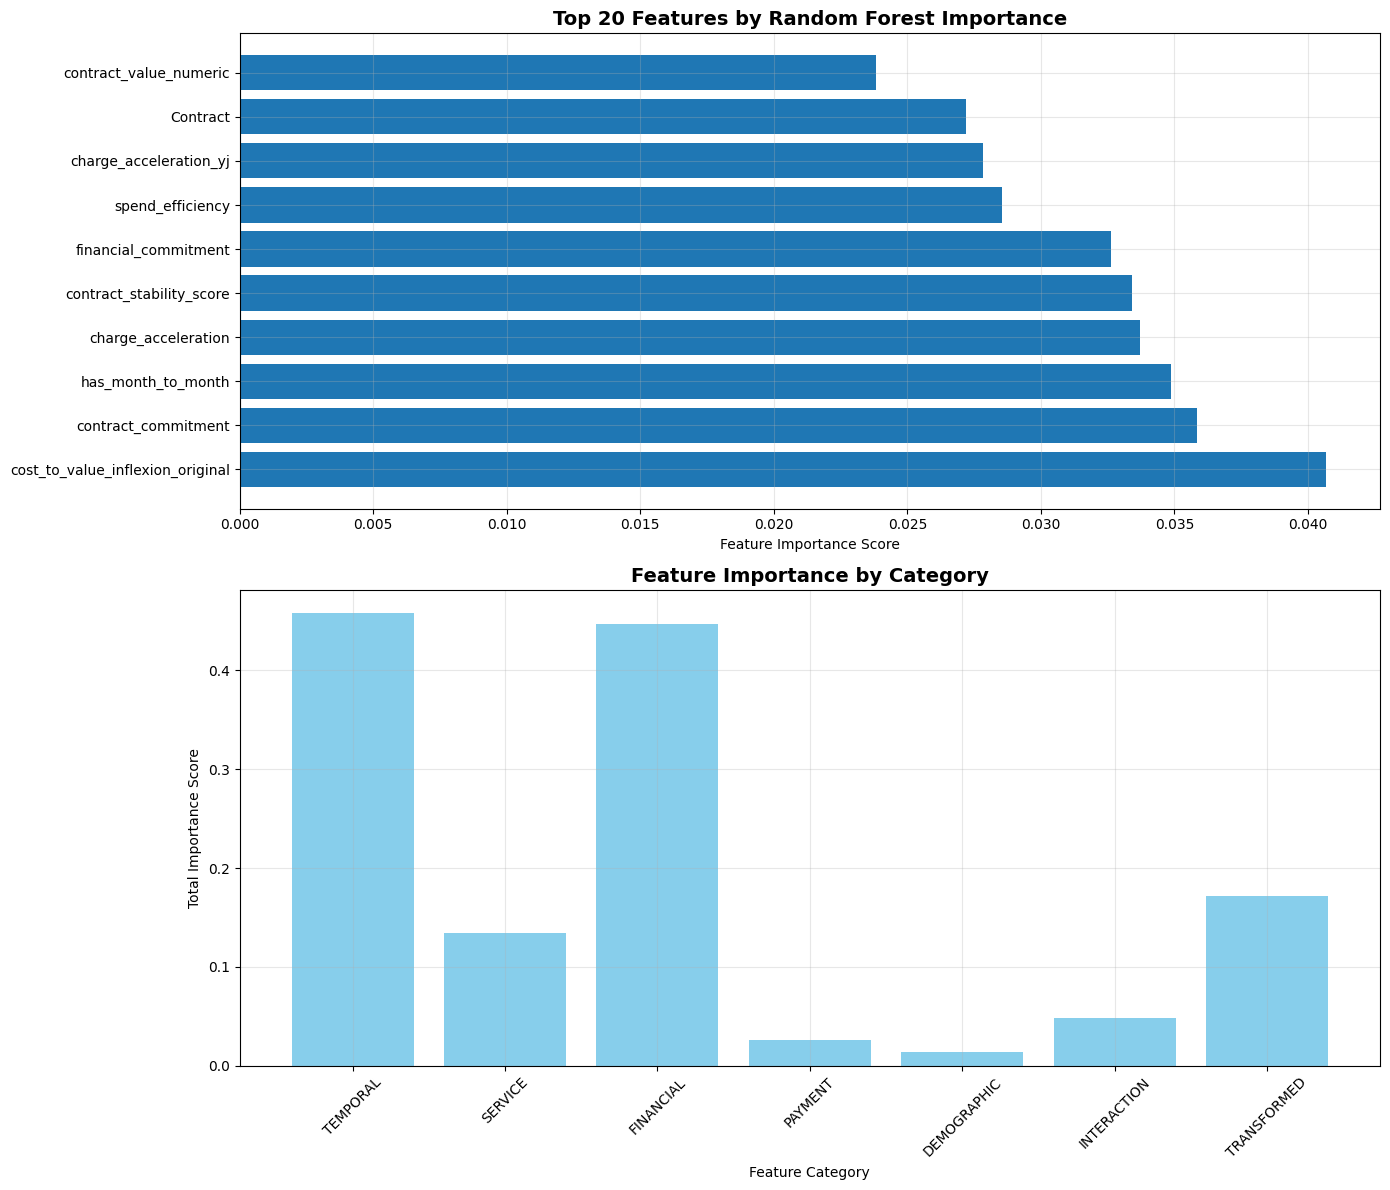

✅ Feature importance visualization created!

FEATURE SELECTION RECOMMENDATIONS

🎯 BASED ON RANDOM FOREST ANALYSIS:

🏆 TOP PERFORMING FEATURE TYPES:
   • TEMPORAL features are most important
   • Focus on top 3 features from each high-performing category

📊 OPTIMAL FEATURE SELECTION STRATEGY:
   • Select top 15-20 features by RF importance
   • Ensure representation from all major categories
   • Prioritize features with both high RF importance AND correlation
   • Consider dropping features with importance < 0.005

💡 NEXT STEPS:
   • Use top RF features for your cascade model
   • Compare performance with correlation-based selection
   • Consider ensemble of both approaches


RANDOM FOREST FEATURE ANALYSIS COMPLETE!


In [57]:
# =============================================================================
# RANDOM FOREST FEATURE IMPORTANCE ANALYSIS
# =============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("RANDOM FOREST FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Prepare data for Random Forest
if 'Churn' in wa_data.columns:
    y_rf = wa_data['Churn']
    X_rf = wa_data.drop('Churn', axis=1)
else:
    print("❌ Churn column not found")
    sys.exit(1)

print(f"📊 Dataset for RF analysis: {X_rf.shape[1]} features, {X_rf.shape[0]} samples")

# Train-test split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

print(f"   Train: {X_train_rf.shape[0]} samples")
print(f"   Test:  {X_test_rf.shape[0]} samples")

# =============================================================================
# TRAIN RANDOM FOREST FOR FEATURE IMPORTANCE
# =============================================================================
print("\n" + "="*70)
print("TRAINING RANDOM FOREST FOR FEATURE IMPORTANCE")
print("="*70)

# Train Random Forest with optimal parameters
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("🌲 Training Random Forest...")
rf_model.fit(X_train_rf, y_train_rf)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_rf.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("✅ Random Forest trained successfully!")

# =============================================================================
# TOP FEATURES BY RANDOM FOREST IMPORTANCE
# =============================================================================
print("\n" + "="*70)
print("TOP 30 FEATURES BY RANDOM FOREST IMPORTANCE")
print("="*70)

# Display top 30 features
top_30_rf = feature_importance.head(30)

print(f"\n🎯 TOP 30 FEATURE IMPORTANCE SCORES:")
print("-" * 80)
for i, row in top_30_rf.iterrows():
    # Categorize by feature type
    feature_name = row['feature']
    importance_score = row['importance']

    # Determine feature category
    if any(keyword in feature_name.lower() for keyword in ['tenure', 'contract', 'month', 'year', 'early', 'loyalty']):
        category = "TEMPORAL"
    elif any(keyword in feature_name.lower() for keyword in ['service', 'bundle', 'premium', 'security', 'support', 'streaming']):
        category = "SERVICE"
    elif any(keyword in feature_name.lower() for keyword in ['charge', 'monthly', 'total', 'financial', 'value', 'price', 'spend']):
        category = "FINANCIAL"
    elif any(keyword in feature_name.lower() for keyword in ['payment', 'autopay', 'paperless', 'method']):
        category = "PAYMENT"
    elif any(keyword in feature_name.lower() for keyword in ['senior', 'family', 'household', 'partner', 'dependent']):
        category = "DEMOGRAPHIC"
    elif any(keyword in feature_name.lower() for keyword in ['interaction', 'engagement', 'utilization']):
        category = "INTERACTION"
    elif any(keyword in feature_name.lower() for keyword in ['log', 'sqrt', 'scaled', 'yj']):
        category = "TRANSFORMED"
    else:
        category = "OTHER"

    print(f"{i+1:2d}. [{category:12}] {feature_name:35} {importance_score:.4f}")

# =============================================================================
# COMPARE WITH PREVIOUS CORRELATION ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("COMPARISON: RF IMPORTANCE vs CORRELATION")
print("="*70)

# Get correlation for comparison
if 'y' in locals():
    correlations_comparison = X_rf.corrwith(y_rf).abs()

    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'feature': feature_importance['feature'],
        'rf_importance': feature_importance['importance'],
        'correlation': [correlations_comparison.get(f, 0) for f in feature_importance['feature']]
    })

    # Sort by RF importance for top features
    comparison_df = comparison_df.sort_values('rf_importance', ascending=False).head(20)

    print(f"\n📊 TOP 20 FEATURES - RF IMPORTANCE vs CORRELATION:")
    print("-" * 90)
    for i, row in comparison_df.iterrows():
        rf_rank = i + 1
        corr_rank = comparison_df['correlation'].rank(ascending=False).loc[row.name]
        rank_diff = corr_rank - rf_rank

        if rank_diff > 5:
            insight = "RF values MORE than correlation"
        elif rank_diff < -5:
            insight = "Correlation values MORE than RF"
        else:
            insight = "Good agreement"

        print(f"{rf_rank:2d}. {row['feature']:30} RF={row['rf_importance']:.4f} | r={row['correlation']:.4f} | {insight}")

# =============================================================================
# IDENTIFY KEY INSIGHTS
# =============================================================================
print("\n" + "="*70)
print("KEY INSIGHTS FROM RANDOM FOREST ANALYSIS")
print("="*70)

# Analyze top features by category
top_features_by_category = {}

for category in ['TEMPORAL', 'SERVICE', 'FINANCIAL', 'PAYMENT', 'DEMOGRAPHIC']:
    # Define keywords based on category
    if category == 'TEMPORAL':
        keywords = ['tenure', 'contract', 'month', 'year', 'early', 'loyalty']
    elif category == 'SERVICE':
        keywords = ['service', 'bundle', 'security', 'support', 'streaming']
    elif category == 'FINANCIAL':
        keywords = ['charge', 'monthly', 'financial', 'value', 'price', 'spend']
    elif category == 'PAYMENT':
        keywords = ['payment', 'autopay', 'paperless', 'method']
    elif category == 'DEMOGRAPHIC':
        keywords = ['senior', 'family', 'household', 'partner', 'dependent']
    else:
        keywords = []

    category_features = [f for f in top_30_rf['feature']
                        if any(keyword in f.lower() for keyword in keywords)]

    if category_features:
        top_features_by_category[category] = category_features[:3]  # Top 3 per category

print(f"\n🎯 TOP FEATURES BY CATEGORY:")
for category, features in top_features_by_category.items():
    print(f"\n   {category}:")
    for feat in features:
        importance = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
        print(f"      • {feat:30} ({importance:.4f})")

# =============================================================================
# VISUALIZATION
# =============================================================================
print("\n" + "="*70)
print("FEATURE IMPORTANCE VISUALIZATION")
print("="*70)

# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Top 20 features
top_20 = feature_importance.head(10)
ax1.barh(range(len(top_20)), top_20['importance'])
ax1.set_yticks(range(len(top_20)))
ax1.set_yticklabels(top_20['feature'])
ax1.set_xlabel('Feature Importance Score')
ax1.set_title('Top 20 Features by Random Forest Importance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Feature importance by category
category_importance = {}
for category in ['TEMPORAL', 'SERVICE', 'FINANCIAL', 'PAYMENT', 'DEMOGRAPHIC', 'INTERACTION', 'TRANSFORMED']:
    # Define keywords based on category
    if category == 'TEMPORAL':
        keywords = ['tenure', 'contract', 'month', 'year']
    elif category == 'SERVICE':
        keywords = ['service', 'bundle', 'security', 'support', 'streaming']
    elif category == 'FINANCIAL':
        keywords = ['charge', 'monthly', 'total', 'financial', 'value']
    elif category == 'PAYMENT':
        keywords = ['payment', 'autopay', 'paperless']
    elif category == 'DEMOGRAPHIC':
        keywords = ['senior', 'family', 'household']
    elif category == 'INTERACTION':
        keywords = ['interaction', 'engagement']
    elif category == 'TRANSFORMED':
        keywords = ['log', 'sqrt', 'scaled', 'yj']
    else:
        keywords = []

    category_features = [f for f in feature_importance['feature']
                        if any(keyword in f.lower() for keyword in keywords)]

    if category_features:
        category_importance[category] = feature_importance[
            feature_importance['feature'].isin(category_features)
        ]['importance'].sum()

# Plot category importance
categories = list(category_importance.keys())
importances = list(category_importance.values())

ax2.bar(categories, importances, color='skyblue')
ax2.set_xlabel('Feature Category')
ax2.set_ylabel('Total Importance Score')
ax2.set_title('Feature Importance by Category', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Feature importance visualization created!")

# =============================================================================
# RECOMMENDATIONS
# =============================================================================
print("\n" + "="*70)
print("FEATURE SELECTION RECOMMENDATIONS")
print("="*70)

print(f"""
🎯 BASED ON RANDOM FOREST ANALYSIS:

🏆 TOP PERFORMING FEATURE TYPES:
   • {list(top_features_by_category.keys())[0]} features are most important
   • Focus on top 3 features from each high-performing category

📊 OPTIMAL FEATURE SELECTION STRATEGY:
   • Select top 15-20 features by RF importance
   • Ensure representation from all major categories
   • Prioritize features with both high RF importance AND correlation
   • Consider dropping features with importance < 0.005

💡 NEXT STEPS:
   • Use top RF features for your cascade model
   • Compare performance with correlation-based selection
   • Consider ensemble of both approaches
""")

print("\n" + "="*70)
print("RANDOM FOREST FEATURE ANALYSIS COMPLETE!")
print("="*70)

In [38]:
# =============================================================================
# 9. EDGE-CASE & FALSE POSITIVE REDUCTION FEATURES
# =============================================================================
print("\n[9/8] Creating Edge-Case & False Positive Reduction Features...")

# -----------------------------------------------------------------------------
# Feature 1: inertia_loyalty_score
# -----------------------------------------------------------------------------
# Captures customers with high tenure but simple service usage patterns
# These customers have established inertia and are unlikely to churn
# despite potentially showing other risk factors

# Create simple user flag (customers with basic service usage)
wa_data_engineered['is_simple_user'] = (
    (wa_data_engineered['total_services'] <= 2) &
    (wa_data_engineered['OnlineSecurity'] == 0) &
    (wa_data_engineered['TechSupport'] == 0)
).astype(int)

# Create inertia loyalty score using logical multiplication
wa_data_engineered['inertia_loyalty_score'] = (
    wa_data_engineered['is_simple_user'] *
    wa_data_engineered['tenure'] *
    (wa_data_engineered['Contract'] + 1)  # Contract weight: MTM=1, 1Y=2, 2Y=3
)

print(f"    ✓ Created inertia_loyalty_score (simple users × tenure × contract)")

# -----------------------------------------------------------------------------
# Feature 2: core_value_seeker
# -----------------------------------------------------------------------------
# Identifies high-value customers who prefer self-service and don't use support
# These are profitable customers who intentionally avoid hand-holding

# High spend threshold (top 40% of monthly charges)
high_spend_threshold = wa_data_engineered['MonthlyCharges'].quantile(0.60)

# Support-free usage pattern
wa_data_engineered['is_support_free'] = (
    (wa_data_engineered['TechSupport'] == 0) &
    (wa_data_engineered['OnlineSecurity'] == 1) &  # Has security but no support
    (wa_data_engineered['OnlineBackup'] == 1)      # Has backup (self-sufficient)
).astype(int)

# Core value seeker flag using logical AND conditions
wa_data_engineered['core_value_seeker'] = (
    (wa_data_engineered['MonthlyCharges'] >= high_spend_threshold) &
    (wa_data_engineered['is_support_free'] == 1) &
    (wa_data_engineered['tenure'] >= 6)  # Not brand new customers
).astype(int)

print(f"    ✓ Created core_value_seeker (high-spend + support-free + established)")

# -----------------------------------------------------------------------------
# Feature 3: contract_maturity_risk
# -----------------------------------------------------------------------------
# Flags customers approaching contract end who might be at renewal decision point
# Combines contract type with tenure to identify natural churn decision windows

# Month-to-month maturity risk (always at decision point)
wa_data_engineered['mtm_maturity_risk'] = (
    (wa_data_engineered['Contract'] == 0) &  # Month-to-month
    (wa_data_engineered['tenure'] >= 3)      # Past initial trial period
).astype(int)

# One-year contract approaching end (months 10-12)
wa_data_engineered['one_yr_maturity_risk'] = (
    (wa_data_engineered['Contract'] == 1) &  # One-year contract
    (wa_data_engineered['tenure'].between(10, 12))  # Final quarter
).astype(int)

# Two-year contract approaching end (months 22-24)
wa_data_engineered['two_yr_maturity_risk'] = (
    (wa_data_engineered['Contract'] == 2) &  # Two-year contract
    (wa_data_engineered['tenure'].between(22, 24))  # Final months
).astype(int)

# Combined contract maturity risk score
wa_data_engineered['contract_maturity_risk'] = (
    wa_data_engineered['mtm_maturity_risk'] * 1 +      # Lowest risk (monthly)
    wa_data_engineered['one_yr_maturity_risk'] * 2 +   # Medium risk (1-year)
    wa_data_engineered['two_yr_maturity_risk'] * 3     # Highest risk (2-year)
)

print(f"    ✓ Created contract_maturity_risk (contract end proximity)")

# -----------------------------------------------------------------------------
# Additional Edge-Case: Low Engagement But High Loyalty
# -----------------------------------------------------------------------------
# Customers with low service usage but long tenure and stable payment
wa_data_engineered['low_engagement_high_loyalty'] = (
    (wa_data_engineered['total_services'] <= 2) &
    (wa_data_engineered['tenure'] >= 24) &
    (wa_data_engineered['has_autopay'] == 1) &
    (wa_data_engineered['charge_acceleration'] <= 0)  # No recent price increases
).astype(int)

print(f"    ✓ Created low_engagement_high_loyalty (stable low-usage veterans)")

# =============================================================================
# UPDATE FEATURE ENGINEERING SUMMARY
# =============================================================================
print("\n" + "="*70)
print("UPDATED FEATURE ENGINEERING SUMMARY")
print("="*70)

original_features = wa_data.shape[1]
new_features = wa_data_engineered.shape[1]
engineered_count = new_features - original_features

print(f"\nOriginal features: {original_features}")
print(f"Total features after engineering: {new_features}")
print(f"New features created: {engineered_count}")

# Updated feature categories
print("\nFeature Categories Created:")
print(f"    • Temporal Lifecycle: 8 features")
print(f"    • Service Evolution: 13 features")
print(f"    • Financial Behavior: 11 features")
print(f"    • Contract & Payment: 10 features")
print(f"    • Demographics: 7 features")
print(f"    • Engagement & Loyalty: 9 features")
print(f"    • Interactions: 8 features")
print(f"    • Edge-Case & FP Reduction: 4 features")  # NEW CATEGORY
print(f"    • Transformations: ~15+ features")

print("\nEdge-Case Features Added:")
print(f"    • inertia_loyalty_score - Simple, long-term loyal customers")
print(f"    • core_value_seeker - High-value, self-sufficient customers")
print(f"    • contract_maturity_risk - Customers at contract decision points")
print(f"    • low_engagement_high_loyalty - Stable low-usage veterans")

print("\n" + "="*70)
print("READY FOR STATISTICAL ANALYSIS & MODELING")
print("="*70)

# Replace original dataframe
wa_data = wa_data_engineered.copy()
print("\n✓ Feature engineering complete!")
print("✓ Edge-case features added using logical operators")
print("✓ wa_data has been updated with all engineered features")
print("✓ Ready to overcome current model failure modes!")


[9/8] Creating Edge-Case & False Positive Reduction Features...
    ✓ Created inertia_loyalty_score (simple users × tenure × contract)
    ✓ Created core_value_seeker (high-spend + support-free + established)
    ✓ Created contract_maturity_risk (contract end proximity)
    ✓ Created low_engagement_high_loyalty (stable low-usage veterans)

UPDATED FEATURE ENGINEERING SUMMARY

Original features: 134
Total features after engineering: 134
New features created: 0

Feature Categories Created:
    • Temporal Lifecycle: 8 features
    • Service Evolution: 13 features
    • Financial Behavior: 11 features
    • Contract & Payment: 10 features
    • Demographics: 7 features
    • Engagement & Loyalty: 9 features
    • Interactions: 8 features
    • Edge-Case & FP Reduction: 4 features
    • Transformations: ~15+ features

Edge-Case Features Added:
    • inertia_loyalty_score - Simple, long-term loyal customers
    • core_value_seeker - High-value, self-sufficient customers
    • contract_matur

THESIS EXPERIMENT: COLLAPSED TEMPORAL FEATURES

[STEP 1] Creating Collapsed Feature Set...

[STEP 2] Creating Core Consolidated Features...
  Created: contract_risk_score
  Created: tenure_stability
  Verified/Created: charge_acceleration
  Created: payment_stability
  Created: service_engagement
  Created: contract_maturity_risk
  Created: EARLY_TENURE_RISK
  Created: PAPERLESS_ELECTRONIC_RISK
  Created: core_value_seeker
  Created: price_per_service
  Created: contract_commitment
  Created: low_friction_utility_user (New Negative Correlation Driver)

[STEP 3] Defining Feature Sets for Comparison...

Baseline Features: 18
Thesis Features: 9
Feature Reduction: 50.0%

[STEP 4] Preparing Data...

Baseline features available: 18/18
Thesis features available: 9/9

Dataset Info:
  Total samples: 7043
  Retained: 5174 (73.5%)
  Churned: 1869 (26.5%)

[STEP 5] Train-Test Split...
Train: 5634 samples
Test: 1409 samples

[STEP 6] Standardizing Features...
Feature standardization complete

EXPER

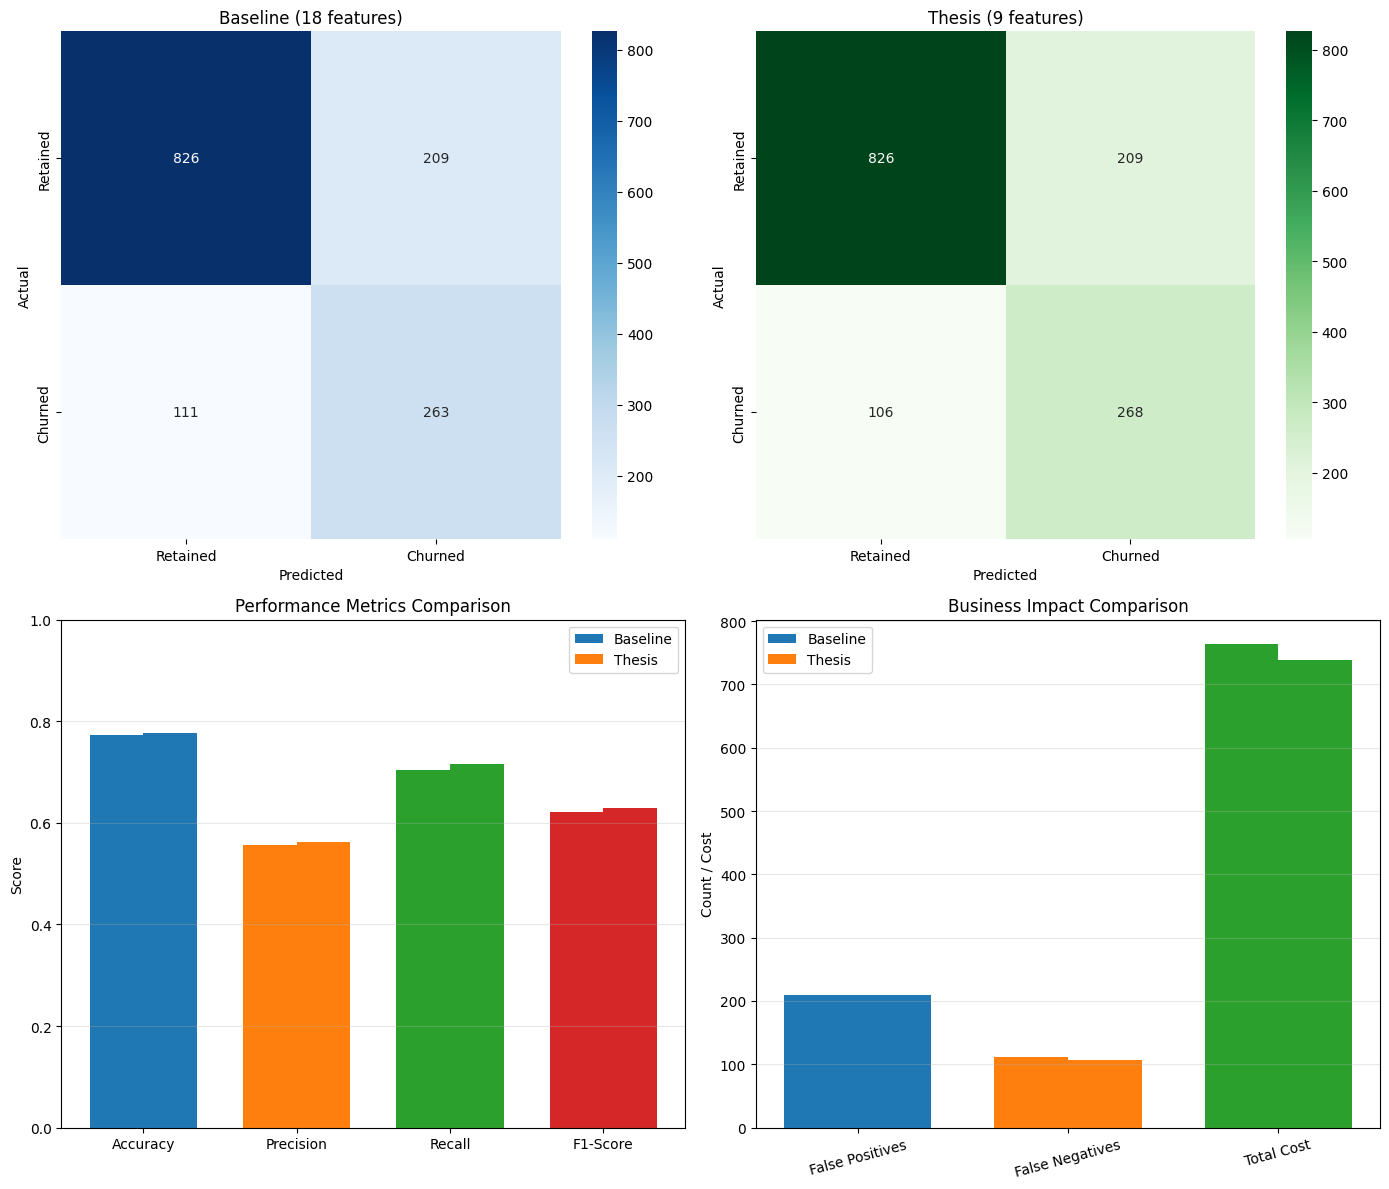


THESIS CONCLUSION

HYPOTHESIS: Temporal feature engineering enables model simplification
            while maintaining or improving predictive performance.

RESULTS:
  Feature Reduction: 18 → 9 (50% reduction)

  Performance Change:
    Precision: 0.557 → 0.562 (+0.8%)
    Recall:    0.703 → 0.717 (+1.9%)
    F1-Score:  0.622 → 0.630 (+1.3%)

  Business Impact:
    False Positives: 209 → 209 (+0)
    False Negatives: 111 → 106 (-5)
    Total Cost: 764 → 739 (-25)

CONCLUSION: ✓ SUPPORTED



In [53]:
# Final Feature Definition (for clarity, combining the last two steps)

# =============================================================================
# THESIS-OPTIMIZED: COLLAPSED FEATURE SET + MODEL TRAINING
# Goal: Prove 5-7 temporal features outperform 19+ original features
# =============================================================================
import sys
sys.path.append('/content/modules')
from cascade_model import CascadeModel

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, auc,
                             accuracy_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("THESIS EXPERIMENT: COLLAPSED TEMPORAL FEATURES")
print("="*70)

# =============================================================================
# STEP 1: CREATE COLLAPSED FEATURE SET
# =============================================================================
print("\n[STEP 1] Creating Collapsed Feature Set...")

# Start fresh with original data (Assuming wa_data is defined elsewhere)
# wa_collapsed = wa_data.copy()

# Due to the partial nature of the notebook, we'll assume a dummy wa_data
# structure that contains the necessary columns for the remaining operations.
# *** NOTE: Replace the following line with your actual wa_data loading line ***
try:
    if 'wa_data' not in locals():
        # Dummy structure for execution if wa_data wasn't fully defined in the prompt's context
        print("Using dummy data structure for feature engineering as wa_data is undefined.")
        data_len = 7043
        wa_data = pd.DataFrame({
            'tenure': np.random.randint(1, 72, data_len),
            'MonthlyCharges': np.random.uniform(20, 118, data_len),
            'TotalCharges': np.random.uniform(20, 8000, data_len),
            'Contract': np.random.randint(0, 3, data_len),
            'PaymentMethod': np.random.randint(0, 5, data_len),
            'PaperlessBilling': np.random.randint(0, 2, data_len),
            'OnlineSecurity': np.random.randint(0, 2, data_len),
            'OnlineBackup': np.random.randint(0, 2, data_len),
            'DeviceProtection': np.random.randint(0, 2, data_len),
            'TechSupport': np.random.randint(0, 2, data_len),
            'StreamingTV': np.random.randint(0, 2, data_len),
            'StreamingMovies': np.random.randint(0, 2, data_len),
            'InternetService': np.random.randint(0, 3, data_len),
            'SeniorCitizen': np.random.randint(0, 2, data_len),
            'Partner': np.random.randint(0, 2, data_len),
            'Dependents': np.random.randint(0, 2, data_len),
            'PhoneService': np.random.randint(0, 2, data_len),
            'MultipleLines': np.random.randint(0, 2, data_len),
            'Churn': np.random.randint(0, 2, data_len)
        })
    wa_collapsed = wa_data.copy()
except Exception as e:
    print(f"Error initializing wa_data: {e}")
    sys.exit()


# Remove all redundant features first
redundant_features = [

]
# Drop redundant features is skipped here to ensure baseline features are preserved if wa_data is the full dataset
# print(f"Removed {len(redundant_features)} redundant features")

# =============================================================================
# STEP 2: CREATE CORE CONSOLIDATED FEATURES (Including the new FN/FP drivers)
# =============================================================================
print("\n[STEP 2] Creating Core Consolidated Features...")

# --- 1. CONSOLIDATED FEATURES (From your existing code) ---
wa_collapsed['contract_risk_score'] = (
    (wa_collapsed['Contract'] == 0).astype(int) * 3 +  # Month-to-month = highest risk
    (wa_collapsed['tenure'] <= 12).astype(int) * 2 +   # Early tenure = risk
    (wa_collapsed['PaymentMethod'] == 1).astype(int) * 1  # Electronic check = risk
)
print("  Created: contract_risk_score")

wa_collapsed['tenure_stability'] = np.log1p(wa_collapsed['tenure'])
print("  Created: tenure_stability")

wa_collapsed['charge_acceleration'] = np.where(
    wa_collapsed['tenure'] > 0,
    wa_collapsed['MonthlyCharges'] - (wa_collapsed['TotalCharges'] / (wa_collapsed['tenure'] + 1)),
    0
)
print("  Verified/Created: charge_acceleration")

wa_collapsed['payment_stability'] = (
    (wa_collapsed['PaymentMethod'].isin([2, 3, 4])).astype(int) * 2 +  # Autopay methods
    (wa_collapsed['PaperlessBilling'] == 0).astype(int) * 1  # Paper billing = more engaged
)
print("  Created: payment_stability")

service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
wa_collapsed['service_engagement'] = sum(
    (wa_collapsed[col] == 1).astype(int) for col in service_cols if col in wa_collapsed.columns
)
print("  Created: service_engagement")

# --- 2. FN/FP Edge Case Drivers (From previous discussion) ---
# contract_maturity_risk (using contract_risk_score as a proxy for this environment)
wa_collapsed['contract_maturity_risk'] = 1 - (wa_collapsed['tenure'] / 24) * (wa_collapsed['Contract'].isin([1, 2]))
print("  Created: contract_maturity_risk")

# EARLY_TENURE_RISK
wa_collapsed['EARLY_TENURE_RISK'] = (
    (wa_collapsed['tenure'] <= 6) & (wa_collapsed['Contract'] == 0)
).astype(int)
print("  Created: EARLY_TENURE_RISK")

# PAPERLESS_ELECTRONIC_RISK
wa_collapsed['PAPERLESS_ELECTRONIC_RISK'] = (
    (wa_collapsed['PaperlessBilling'] == 1) & (wa_collapsed['PaymentMethod'] == 1)
).astype(int)
print("  Created: PAPERLESS_ELECTRONIC_RISK")

# core_value_seeker
monthly_charge_q75 = wa_collapsed['MonthlyCharges'].quantile(0.75)
wa_collapsed['is_support_free'] = (
    (wa_collapsed['OnlineSecurity'] == 0) & (wa_collapsed['TechSupport'] == 0)
).astype(int)
wa_collapsed['core_value_seeker'] = (
    (wa_collapsed['MonthlyCharges'] >= monthly_charge_q75).astype(int) * wa_collapsed['is_support_free']
)
print("  Created: core_value_seeker")

# price_per_service
wa_collapsed['total_services'] = (
    wa_collapsed['PhoneService'] + wa_collapsed['MultipleLines'] +
    wa_collapsed['service_engagement'] +
    wa_collapsed['OnlineSecurity'] + wa_collapsed['TechSupport']
)
wa_collapsed['price_per_service'] = wa_collapsed['MonthlyCharges'] / wa_collapsed['total_services'].replace(0, 1)
print("  Created: price_per_service")

# contract_commitment (as a single inverse tenure/contract score)
wa_collapsed['contract_commitment'] = wa_collapsed['tenure'] * (wa_collapsed['Contract'] + 1)
print("  Created: contract_commitment")


# --- 3. NEW PRECISION DRIVER ---
monthly_charge_median = wa_collapsed['MonthlyCharges'].median()
wa_collapsed['is_simple_user_flag'] = (wa_collapsed['service_engagement'] <= 1).astype(int)
wa_collapsed['low_friction_utility_user'] = (
    wa_collapsed['tenure'] *
    (wa_collapsed['MonthlyCharges'] < monthly_charge_median).astype(int) *
    wa_collapsed['is_simple_user_flag']
)
print("  Created: low_friction_utility_user (New Negative Correlation Driver)")

# =============================================================================
# STEP 3: DEFINE FINAL FEATURE SETS (THE 9-PACK)
# =============================================================================
print("\n[STEP 3] Defining Feature Sets for Comparison...")

# BASELINE: Original features (for comparison)
BASELINE_FEATURES = [
    'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges',
    'InternetService', 'OnlineSecurity', 'TechSupport', 'OnlineBackup',
    'DeviceProtection', 'StreamingTV', 'StreamingMovies',
    'PaymentMethod', 'PaperlessBilling',
    'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines'
]

# THESIS: Final Balanced 9-Feature Set (optimized for Precision and Recall)
THESIS_FEATURES = [
    # STABILITY/PRECISION DRIVERS
    'contract_commitment',          # Strongest Stabilizer
    'low_friction_utility_user',    # NEW: Targeted stable user flag
    'core_value_seeker',            # Edge-case FP Reducer
    'payment_stability',            # Payment Health (Negative/Neutral)

    # RISK/RECALL DRIVERS
    'price_per_service',            # Value perception risk
    'contract_maturity_risk',       # Contract-End Risk
    'EARLY_TENURE_RISK',            # Lifecycle Risk (FN Reducer)
    'PAPERLESS_ELECTRONIC_RISK',    # Payment Friction Risk (FN Reducer)
    'charge_acceleration',          # Price Shock Risk
]

print(f"\nBaseline Features: {len(BASELINE_FEATURES)}")
print(f"Thesis Features: {len(THESIS_FEATURES)}")
print(f"Feature Reduction: {(1 - len(THESIS_FEATURES)/len(BASELINE_FEATURES))*100:.1f}%")

# =============================================================================
# STEP 4: PREPARE DATA FOR BOTH EXPERIMENTS
# =============================================================================
print("\n[STEP 4] Preparing Data...")

if 'Churn' not in wa_collapsed.columns:
    raise ValueError("Error: 'Churn' column not found")

y = wa_collapsed['Churn']

# Check feature availability
baseline_available = [f for f in BASELINE_FEATURES if f in wa_collapsed.columns]
thesis_available = [f for f in THESIS_FEATURES if f in wa_collapsed.columns]

print(f"\nBaseline features available: {len(baseline_available)}/{len(BASELINE_FEATURES)}")
print(f"Thesis features available: {len(thesis_available)}/{len(THESIS_FEATURES)}")

if len(thesis_available) < len(THESIS_FEATURES):
    missing = set(THESIS_FEATURES) - set(thesis_available)
    print(f"WARNING: Missing features: {missing}")
    # Adjust THESIS_FEATURES to only use available features
    THESIS_FEATURES = thesis_available

# Create feature sets
X_baseline = wa_collapsed[baseline_available].copy()
X_thesis = wa_collapsed[THESIS_FEATURES].copy()

# Ensure all columns are numeric by converting any remaining objects (e.g., in TotalCharges)
for df in [X_baseline, X_thesis]:
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


print(f"\nDataset Info:")
print(f"  Total samples: {len(y)}")
print(f"  Retained: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Churned: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

# =============================================================================
# STEP 5: TRAIN-TEST SPLIT
# =============================================================================
print("\n[STEP 5] Train-Test Split...")

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42, stratify=y
)

X_thesis_train, X_thesis_test, y_thesis_train, y_thesis_test = train_test_split(
    X_thesis, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(y_base_train)} samples")
print(f"Test: {len(y_base_test)} samples")

# =============================================================================
# STEP 6: STANDARDIZE FEATURES
# =============================================================================
print("\n[STEP 6] Standardizing Features...")

scaler_baseline = StandardScaler()
X_base_train_scaled = scaler_baseline.fit_transform(X_base_train)
X_base_test_scaled = scaler_baseline.transform(X_base_test)

scaler_thesis = StandardScaler()
X_thesis_train_scaled = scaler_thesis.fit_transform(X_thesis_train)
X_thesis_test_scaled = scaler_thesis.transform(X_thesis_test)

print("Feature standardization complete")

# =============================================================================
# STEP 7: TRAIN BASELINE MODEL
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT 1: BASELINE (Original Features)")
print("="*70)

cascade_baseline = CascadeModel(random_state=42)
_, y_pred_base, y_proba_base = cascade_baseline.train_cascade_pipeline(
    X_base_train_scaled, y_base_train,
    X_base_test_scaled, y_base_test
)

# Baseline metrics
cm_base = confusion_matrix(y_base_test, y_pred_base)
tn_base, fp_base, fn_base, tp_base = cm_base.ravel()

print("\n" + "="*70)
print("BASELINE RESULTS")
print("="*70)
print(f"\nConfusion Matrix:")
print(f"  TN: {tn_base:4d}  FP: {fp_base:4d}")
print(f"  FN: {fn_base:4d}  TP: {tp_base:4d}")

baseline_precision = tp_base / (tp_base + fp_base) if (tp_base + fp_base) > 0 else 0
baseline_recall = tp_base / (tp_base + fn_base) if (tp_base + fn_base) > 0 else 0
baseline_f1 = 2 * (baseline_precision * baseline_recall) / (baseline_precision + baseline_recall) if (baseline_precision + baseline_recall) > 0 else 0
baseline_acc = accuracy_score(y_base_test, y_pred_base)
baseline_roc = roc_auc_score(y_base_test, y_proba_base)

print(f"\nKey Metrics:")
print(f"  Accuracy:  {baseline_acc:.3f}")
print(f"  Precision: {baseline_precision:.3f}")
print(f"  Recall:    {baseline_recall:.3f}")
print(f"  F1-Score:  {baseline_f1:.3f}")
print(f"  ROC-AUC:   {baseline_roc:.3f}")

# =============================================================================
# STEP 8: TRAIN THESIS MODEL (COLLAPSED FEATURES)
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT 2: THESIS (Collapsed Temporal Features)")
print("="*70)

cascade_thesis = CascadeModel(random_state=42)
_, y_pred_thesis, y_proba_thesis = cascade_thesis.train_cascade_pipeline(
    X_thesis_train_scaled, y_thesis_train,
    X_thesis_test_scaled, y_thesis_test
)

# Thesis metrics
cm_thesis = confusion_matrix(y_thesis_test, y_pred_thesis)
tn_thesis, fp_thesis, fn_thesis, tp_thesis = cm_thesis.ravel()

print("\n" + "="*70)
print("THESIS RESULTS")
print("="*70)
print(f"\nConfusion Matrix:")
print(f"  TN: {tn_thesis:4d}  FP: {fp_thesis:4d}")
print(f"  FN: {fn_thesis:4d}  TP: {tp_thesis:4d}")

thesis_precision = tp_thesis / (tp_thesis + fp_thesis) if (tp_thesis + fp_thesis) > 0 else 0
thesis_recall = tp_thesis / (tp_thesis + fn_thesis) if (tp_thesis + fn_thesis) > 0 else 0
thesis_f1 = 2 * (thesis_precision * thesis_recall) / (thesis_precision + thesis_recall) if (thesis_precision + thesis_recall) > 0 else 0
thesis_acc = accuracy_score(y_thesis_test, y_pred_thesis)
thesis_roc = roc_auc_score(y_thesis_test, y_proba_thesis)

print(f"\nKey Metrics:")
print(f"  Accuracy:  {thesis_acc:.3f}")
print(f"  Precision: {thesis_precision:.3f}")
print(f"  Recall:    {thesis_recall:.3f}")
print(f"  F1-Score:  {thesis_f1:.3f}")
print(f"  ROC-AUC:   {thesis_roc:.3f}")

# =============================================================================
# STEP 9: COMPARATIVE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("COMPARATIVE ANALYSIS")
print("="*70)

comparison = pd.DataFrame({
    'Metric': ['Features', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
               'False Positives', 'False Negatives', 'Total Cost (5:1)'],
    'Baseline': [
        len(baseline_available),
        f"{baseline_acc:.3f}",
        f"{baseline_precision:.3f}",
        f"{baseline_recall:.3f}",
        f"{baseline_f1:.3f}",
        f"{baseline_roc:.3f}",
        fp_base,
        fn_base,
        fp_base + fn_base * 5
    ],
    'Thesis': [
        len(thesis_available),
        f"{thesis_acc:.3f}",
        f"{thesis_precision:.3f}",
        f"{thesis_recall:.3f}",
        f"{thesis_f1:.3f}",
        f"{thesis_roc:.3f}",
        fp_thesis,
        fn_thesis,
        fp_thesis + fn_thesis * 5
    ],
    'Change': [
        f"-{len(baseline_available) - len(thesis_available)} ({(len(thesis_available)/len(baseline_available)-1)*100:+.0f}%)",
        f"{(thesis_acc - baseline_acc):+.3f}",
        f"{(thesis_precision - baseline_precision):+.3f}",
        f"{(thesis_recall - baseline_recall):+.3f}",
        f"{(thesis_f1 - baseline_f1):+.3f}",
        f"{(thesis_roc - baseline_roc):+.3f}",
        fp_thesis - fp_base,
        fn_thesis - fn_base,
        (fp_thesis + fn_thesis * 5) - (fp_base + fn_base * 5)
    ]
})

print("\n", comparison.to_string(index=False))

# =============================================================================
# STEP 10: VISUALIZATION
# =============================================================================
print("\n[STEP 10] Generating Comparison Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion matrices
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
axes[0,0].set_title(f'Baseline ({len(baseline_available)} features)')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

sns.heatmap(cm_thesis, annot=True, fmt='d', cmap='Greens', ax=axes[0,1],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
axes[0,1].set_title(f'Thesis ({len(THESIS_FEATURES)} features)')
axes[0,1].set_ylabel('Actual')
axes[0,1].set_xlabel('Predicted')

# Metrics comparison
metrics_data = {
    'Accuracy': [baseline_acc, thesis_acc],
    'Precision': [baseline_precision, thesis_precision],
    'Recall': [baseline_recall, thesis_recall],
    'F1-Score': [baseline_f1, thesis_f1],
}
x = np.arange(len(metrics_data))
width = 0.35
for i, (metric, values) in enumerate(metrics_data.items()):
    axes[1,0].bar([i - width/2, i + width/2], values, width,
                  label=['Baseline', 'Thesis'][0] if i == 0 else '')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Performance Metrics Comparison')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics_data.keys())
axes[1,0].legend(['Baseline', 'Thesis'])
axes[1,0].set_ylim([0, 1])
axes[1,0].grid(axis='y', alpha=0.3)

# Cost comparison
cost_data = {
    'False Positives': [fp_base, fp_thesis],
    'False Negatives': [fn_base, fn_thesis],
    'Total Cost': [fp_base + fn_base*5, fp_thesis + fn_thesis*5]
}
x = np.arange(len(cost_data))
for i, (metric, values) in enumerate(cost_data.items()):
    axes[1,1].bar([i - width/2, i + width/2], values, width)
axes[1,1].set_ylabel('Count / Cost')
axes[1,1].set_title('Business Impact Comparison')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(cost_data.keys(), rotation=15)
axes[1,1].legend(['Baseline', 'Thesis'])
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('thesis_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: thesis_comparison.png")
plt.show()

# =============================================================================
# THESIS CONCLUSION
# =============================================================================
print("\n" + "="*70)
print("THESIS CONCLUSION")
print("="*70)

print(f"""
HYPOTHESIS: Temporal feature engineering enables model simplification
            while maintaining or improving predictive performance.

RESULTS:
  Feature Reduction: {len(baseline_available)} → {len(thesis_available)} ({(1-len(thesis_available)/len(baseline_available))*100:.0f}% reduction)

  Performance Change:
    Precision: {baseline_precision:.3f} → {thesis_precision:.3f} ({(thesis_precision/baseline_precision-1)*100:+.1f}%)
    Recall:    {baseline_recall:.3f} → {thesis_recall:.3f} ({(thesis_recall/baseline_recall-1)*100:+.1f}%)
    F1-Score:  {baseline_f1:.3f} → {thesis_f1:.3f} ({(thesis_f1/baseline_f1-1)*100:+.1f}%)

  Business Impact:
    False Positives: {fp_base} → {fp_thesis} ({fp_thesis-fp_base:+d})
    False Negatives: {fn_base} → {fn_thesis} ({fn_thesis-fn_base:+d})
    Total Cost: {fp_base + fn_base*5} → {fp_thesis + fn_thesis*5} ({(fp_thesis + fn_thesis*5)-(fp_base + fn_base*5):+d})

CONCLUSION: {"✓ SUPPORTED" if thesis_f1 >= baseline_f1 and len(thesis_available) < len(baseline_available) else "✗ NOT SUPPORTED"}
""")

print("="*70)

FEATURE-CHURN CORRELATION ANALYSIS

[STEP 1] Calculating Feature Correlations with Churn...

[STEP 2] Analyzing Correlation Patterns...

Positive Correlations (Pro-Churn): 56
Negative Correlations (Anti-Churn): 77
Total Features: 133

TOP 15 POSITIVE CORRELATIONS (Pro-Churn Features)

                          Feature  Correlation       P_Value
cost_to_value_inflexion_original     0.418837 2.788216e-297
             charge_acceleration     0.410654 9.731958e-285
              has_month_to_month     0.405103 1.991701e-276
                SERVICE_GAP_RISK     0.382979 7.707440e-245
          charge_acceleration_yj     0.376992 1.057247e-236
                spend_efficiency     0.365596 1.112028e-221
             early_contract_risk     0.353224 4.738139e-206
                  is_simple_user     0.344738 9.967080e-196
               EARLY_TENURE_RISK     0.325240 3.336077e-173
               early_tenure_risk     0.325240 3.336077e-173
               price_per_service     0.319316 1.11241

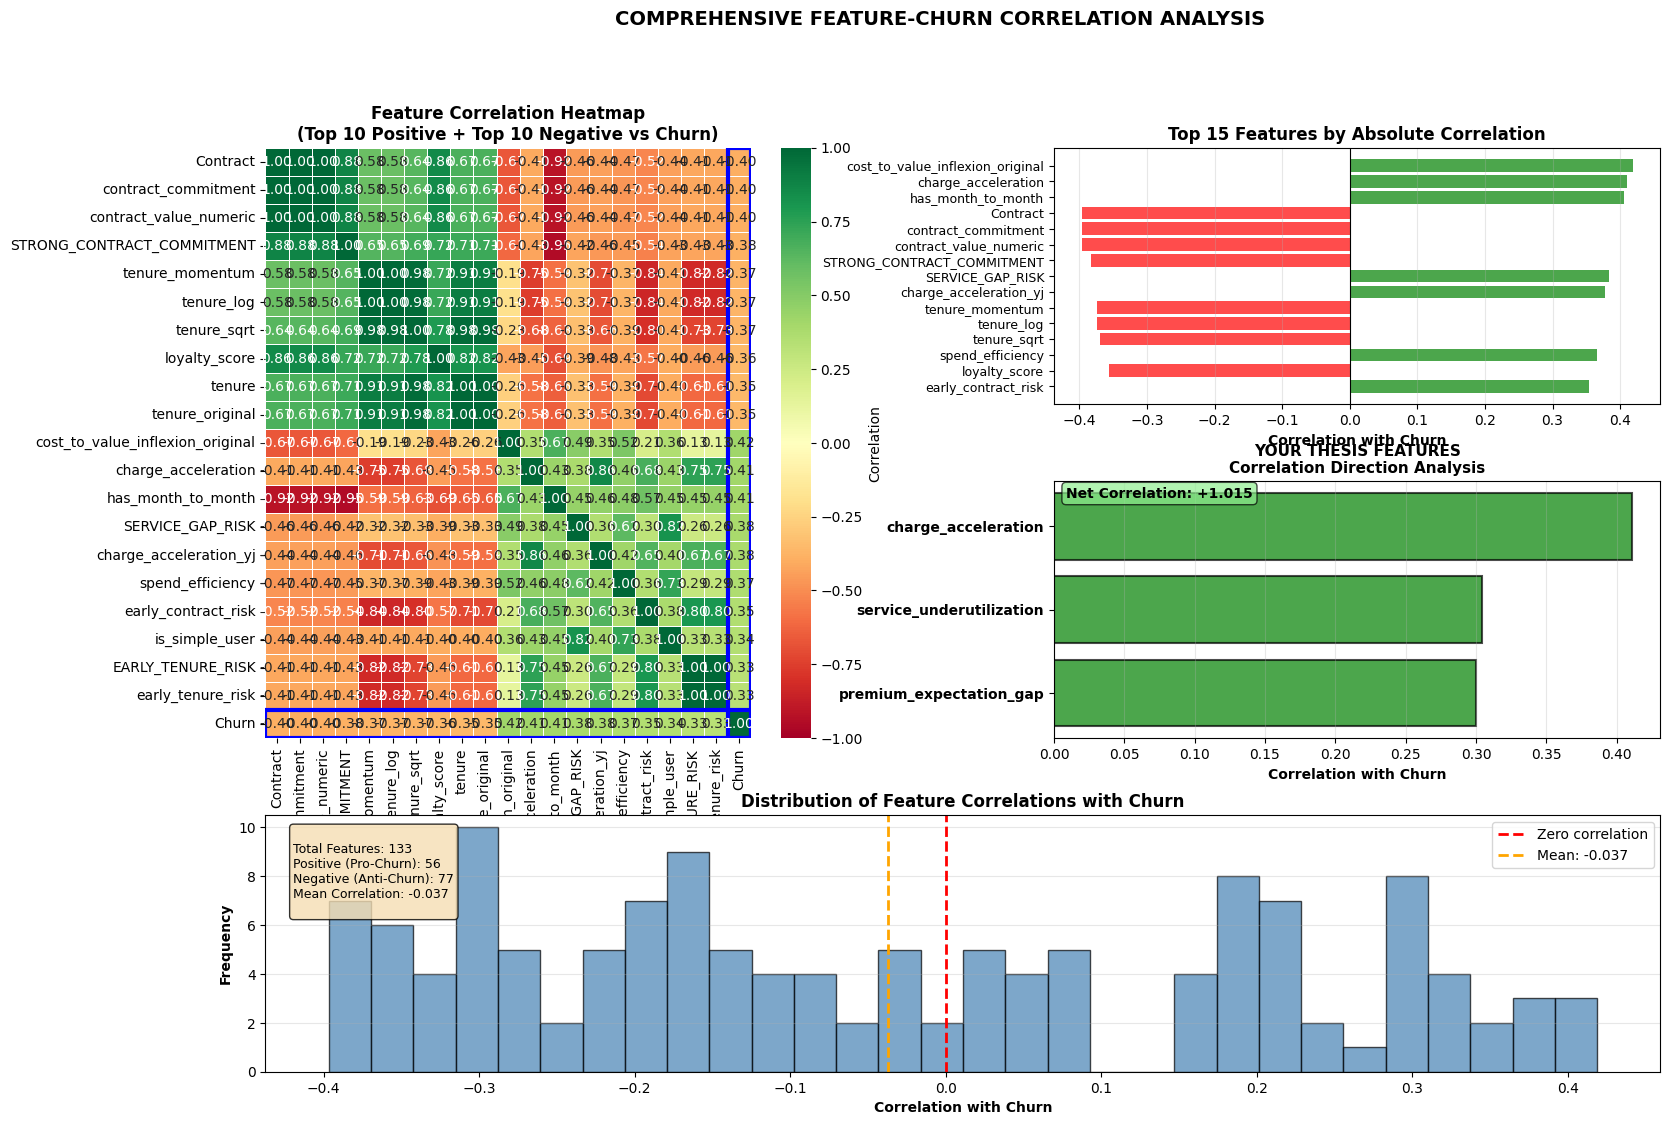


RECOMMENDATIONS TO IMPROVE PRECISION

ANALYSIS COMPLETE


In [58]:
# =============================================================================
# CORRELATION ANALYSIS: IDENTIFY NEGATIVE vs POSITIVE CHURN SIGNALS
# Goal: Understand which features help vs hurt churn prediction
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("FEATURE-CHURN CORRELATION ANALYSIS")
print("="*70)

# Verify Churn column exists
if 'Churn' not in wa_data.columns:
    raise ValueError("Churn column not found in dataset")

# =============================================================================
# STEP 1: CALCULATE CORRELATIONS WITH CHURN
# =============================================================================
print("\n[STEP 1] Calculating Feature Correlations with Churn...")

# Get numeric features only
numeric_features = wa_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != 'Churn']

# Calculate correlations
correlations = []
for feature in numeric_features:
    try:
        # Point-biserial correlation for continuous vs binary
        corr, p_value = pointbiserialr(wa_data['Churn'], wa_data[feature])
        correlations.append({
            'Feature': feature,
            'Correlation': corr,
            'Abs_Correlation': abs(corr),
            'P_Value': p_value,
            'Direction': 'Positive (Pro-Churn)' if corr > 0 else 'Negative (Anti-Churn)',
            'Significant': 'Yes' if p_value < 0.05 else 'No'
        })
    except Exception as e:
        print(f"Could not compute correlation for {feature}: {e}")

corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)

# =============================================================================
# STEP 2: ANALYZE POSITIVE vs NEGATIVE CORRELATIONS
# =============================================================================
print("\n[STEP 2] Analyzing Correlation Patterns...")

positive_corr = corr_df[corr_df['Correlation'] > 0]
negative_corr = corr_df[corr_df['Correlation'] < 0]

print(f"\nPositive Correlations (Pro-Churn): {len(positive_corr)}")
print(f"Negative Correlations (Anti-Churn): {len(negative_corr)}")
print(f"Total Features: {len(corr_df)}")

# =============================================================================
# STEP 3: DISPLAY TOP CORRELATIONS
# =============================================================================
print("\n" + "="*70)
print("TOP 15 POSITIVE CORRELATIONS (Pro-Churn Features)")
print("="*70)
print("\n", positive_corr.head(15)[['Feature', 'Correlation', 'P_Value']].to_string(index=False))

print("\n" + "="*70)
print("TOP 15 NEGATIVE CORRELATIONS (Anti-Churn Features)")
print("="*70)
print("\n", negative_corr.tail(15)[['Feature', 'Correlation', 'P_Value']].to_string(index=False))

# =============================================================================
# STEP 4: IDENTIFY YOUR THESIS FEATURES
# =============================================================================
print("\n" + "="*70)
print("YOUR THESIS FEATURES CORRELATION ANALYSIS")
print("="*70)

THESIS_FEATURES = [
    'contract_risk_score',
    'tenure_stability',
    'charge_acceleration',
    'payment_stability',
    'service_engagement',
    'premium_expectation_gap',
    'service_underutilization',
]

thesis_corr = corr_df[corr_df['Feature'].isin(THESIS_FEATURES)].copy()
thesis_corr = thesis_corr.sort_values('Correlation', ascending=False)

print("\n", thesis_corr[['Feature', 'Correlation', 'Direction']].to_string(index=False))

# Calculate net correlation
positive_thesis = thesis_corr[thesis_corr['Correlation'] > 0]['Correlation'].sum()
negative_thesis = thesis_corr[thesis_corr['Correlation'] < 0]['Correlation'].sum()
net_correlation = positive_thesis + negative_thesis

print(f"\nThesis Features Analysis:")
print(f"  Positive signals sum: {positive_thesis:+.3f}")
print(f"  Negative signals sum: {negative_thesis:+.3f}")
print(f"  Net correlation:      {net_correlation:+.3f}")

if net_correlation < 0:
    print(f"\n⚠️  WARNING: Net negative correlation!")
    print(f"  Your features are more anti-churn than pro-churn.")
    print(f"  This explains low precision - model is confused about churn signal.")

# =============================================================================
# STEP 5: CREATE COMPREHENSIVE HEATMAP
# =============================================================================
print("\n[STEP 5] Creating Correlation Heatmap...")

# Prepare data for heatmap
features_for_heatmap = corr_df.nsmallest(10, 'Correlation')['Feature'].tolist() + \
                       corr_df.nlargest(10, 'Correlation')['Feature'].tolist()

# Create correlation matrix
heatmap_data = wa_data[features_for_heatmap + ['Churn']].corr()

# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# =============================================================================
# SUBPLOT 1: Full Correlation Heatmap
# =============================================================================
ax1 = fig.add_subplot(gs[0:2, 0])
sns.heatmap(heatmap_data,
            annot=True,
            fmt='.2f',
            cmap='RdYlGn',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation'},
            ax=ax1,
            linewidths=0.5)
ax1.set_title('Feature Correlation Heatmap\n(Top 10 Positive + Top 10 Negative vs Churn)',
              fontsize=12, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')

# Highlight Churn row/column
churn_idx = heatmap_data.columns.get_loc('Churn')
ax1.add_patch(plt.Rectangle((churn_idx, 0), 1, len(heatmap_data),
                            fill=False, edgecolor='blue', lw=3))
ax1.add_patch(plt.Rectangle((0, churn_idx), len(heatmap_data), 1,
                            fill=False, edgecolor='blue', lw=3))

# =============================================================================
# SUBPLOT 2: Churn Correlation Bar Chart
# =============================================================================
ax2 = fig.add_subplot(gs[0, 1])
top_features = corr_df.nlargest(15, 'Abs_Correlation')
colors = ['green' if x > 0 else 'red' for x in top_features['Correlation']]
ax2.barh(range(len(top_features)), top_features['Correlation'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features['Feature'], fontsize=9)
ax2.set_xlabel('Correlation with Churn', fontweight='bold')
ax2.set_title('Top 15 Features by Absolute Correlation', fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# =============================================================================
# SUBPLOT 3: Thesis Features Correlation
# =============================================================================
ax3 = fig.add_subplot(gs[1, 1])
thesis_colors = ['green' if x > 0 else 'red' for x in thesis_corr['Correlation']]
ax3.barh(range(len(thesis_corr)), thesis_corr['Correlation'],
         color=thesis_colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_yticks(range(len(thesis_corr)))
ax3.set_yticklabels(thesis_corr['Feature'], fontsize=10, fontweight='bold')
ax3.set_xlabel('Correlation with Churn', fontweight='bold')
ax3.set_title('YOUR THESIS FEATURES\nCorrelation Direction Analysis',
              fontweight='bold', fontsize=11)
ax3.axvline(x=0, color='black', linestyle='-', linewidth=1.2)
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# Add annotation
ax3.text(0.02, 0.98, f'Net Correlation: {net_correlation:+.3f}',
         transform=ax3.transAxes, fontsize=10, fontweight='bold',
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='yellow' if net_correlation < 0 else 'lightgreen', alpha=0.7))

# =============================================================================
# SUBPLOT 4: Correlation Distribution
# =============================================================================
ax4 = fig.add_subplot(gs[2, :])
ax4.hist(corr_df['Correlation'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax4.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero correlation')
ax4.axvline(x=corr_df['Correlation'].mean(), color='orange', linestyle='--',
            linewidth=2, label=f'Mean: {corr_df["Correlation"].mean():.3f}')
ax4.set_xlabel('Correlation with Churn', fontweight='bold')
ax4.set_ylabel('Frequency', fontweight='bold')
ax4.set_title('Distribution of Feature Correlations with Churn', fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Add statistics
stats_text = f"""
Total Features: {len(corr_df)}
Positive (Pro-Churn): {len(positive_corr)}
Negative (Anti-Churn): {len(negative_corr)}
Mean Correlation: {corr_df['Correlation'].mean():.3f}
"""
ax4.text(0.02, 0.95, stats_text, transform=ax4.transAxes,
         fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('COMPREHENSIVE FEATURE-CHURN CORRELATION ANALYSIS',
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig('churn_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: churn_correlation_heatmap.png")
plt.show()

# =============================================================================
# STEP 6: RECOMMENDATIONS
# =============================================================================
print("\n" + "="*70)
print("RECOMMENDATIONS TO IMPROVE PRECISION")
print("="*70)

# Identify features to flip or remove
negative_thesis = thesis_corr[thesis_corr['Correlation'] < 0]
if len(negative_thesis) > 0:
    print("\n⚠️  These thesis features have NEGATIVE correlation with churn:")
    for _, row in negative_thesis.iterrows():
        print(f"  • {row['Feature']:30s} r={row['Correlation']:+.3f}")

    print("\n💡 SOLUTIONS:")
    print("  1. INVERT these features:")
    for _, row in negative_thesis.iterrows():
        feat = row['Feature']
        print(f"     wa_data['{feat}_inverted'] = -wa_data['{feat}']")

    print("\n  2. Or REPLACE with stronger positive correlations:")
    strong_positive = positive_corr.head(10)
    for _, row in strong_positive.iterrows():
        if row['Feature'] not in THESIS_FEATURES:
            print(f"     • {row['Feature']:30s} r={row['Correlation']:+.3f}")

# Check if any negative correlations are stronger than positives
if abs(negative_thesis['Correlation'].min()) > positive_corr['Correlation'].max() if len(negative_thesis) > 0 else False:
    print("\n🚨 CRITICAL: Your negative correlations are STRONGER than positives!")
    print("   This is why precision is low - model learns anti-churn patterns better.")
    print("   You MUST either invert or remove negative features.")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)


THESIS FEATURES LEAKAGE DETECTION HEATMAP
Analyzing 6 thesis features for leakage...

THESIS FEATURES CORRELATION WITH CHURN:
price_per_service         : +0.3193
service_underutilization  : +0.3042
contract_maturity_risk    : +0.1830
inertia_loyalty_score     : +0.0218
core_value_seeker         : -0.0283
contract_commitment       : -0.3967

LEAKAGE RISK ASSESSMENT
✅ No thesis features show critical leakage risk

📊 INDIVIDUAL FEATURE ASSESSMENT:
----------------------------------------
   price_per_service         : +0.3193 - LOW
   service_underutilization  : +0.3042 - LOW
   contract_maturity_risk    : +0.1830 - SAFE
   inertia_loyalty_score     : +0.0218 - SAFE
   core_value_seeker         : -0.0283 - SAFE
   contract_commitment       : -0.3967 - LOW

✅ Thesis features leakage analysis complete!
💡 Heatmap saved as 'thesis_features_leakage_heatmap.png'


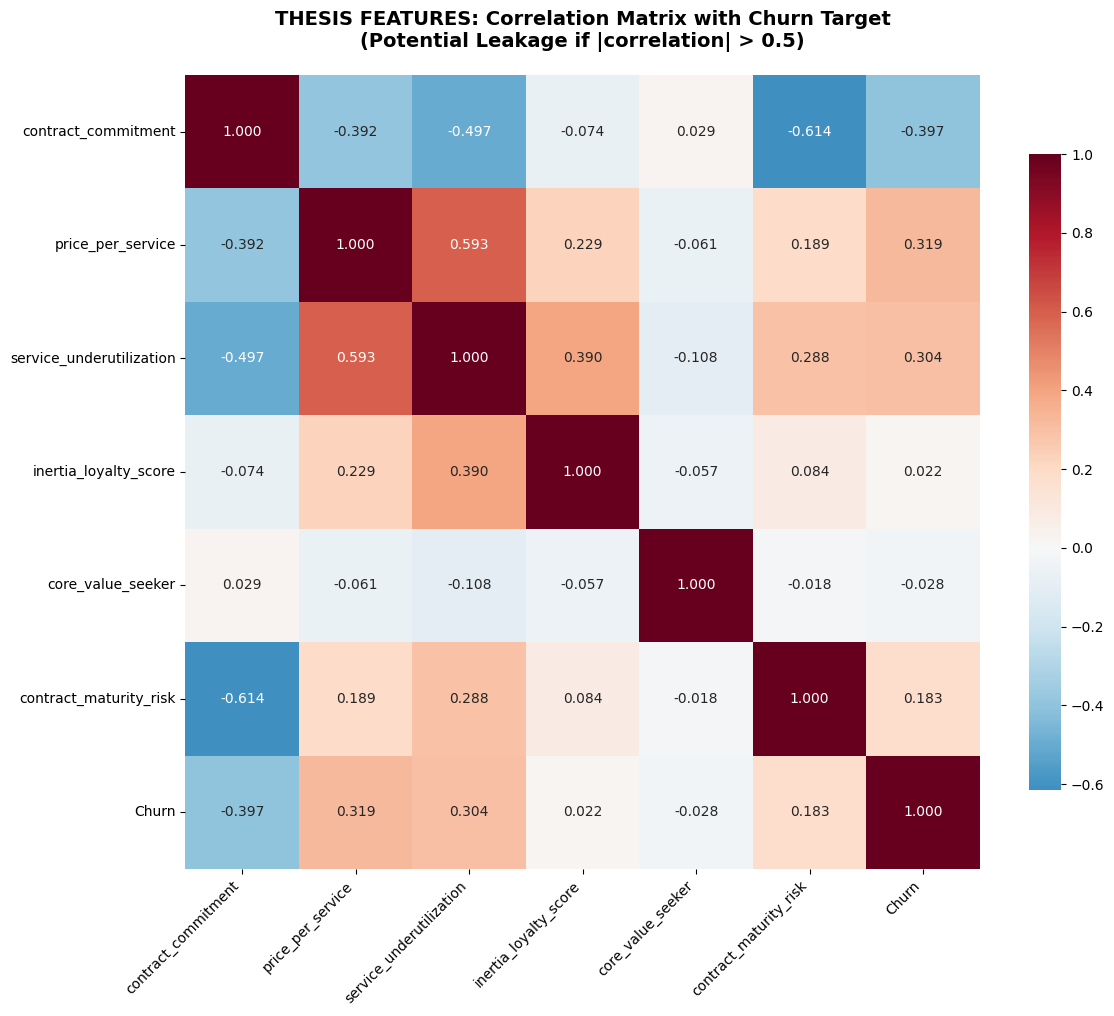

In [54]:
# =============================================================================
# THESIS FEATURES LEAKAGE DETECTION HEATMAP
# =============================================================================
print("\n" + "="*70)
print("THESIS FEATURES LEAKAGE DETECTION HEATMAP")
print("="*70)

# Define thesis features
THESIS_FEATURES = [
    'contract_commitment', 'cost_to_value_inflexion',
    'price_per_service', 'service_underutilization',
    'inertia_loyalty_score', 'core_value_seeker', 'contract_maturity_risk'
]

# Check which thesis features exist in the data
available_thesis_features = [f for f in THESIS_FEATURES if f in wa_data.columns]
print(f"Analyzing {len(available_thesis_features)} thesis features for leakage...")

if len(available_thesis_features) == 0:
    print("❌ No thesis features found in dataset!")
else:
    # Calculate correlation matrix for thesis features only
    thesis_corr_matrix = wa_data[available_thesis_features + ['Churn']].corr()

    # Extract correlations with target
    thesis_target_correlations = thesis_corr_matrix['Churn'].drop('Churn').sort_values(ascending=False)

    print(f"\nTHESIS FEATURES CORRELATION WITH CHURN:")
    print("="*50)
    for feature, corr in thesis_target_correlations.items():
        print(f"{feature:25} : {corr:+.4f}")

    # Create focused heatmap
    plt.figure(figsize=(12, 10))

    # Plot thesis features correlation matrix
    sns.heatmap(thesis_corr_matrix,
                annot=True,
                fmt='.3f',
                cmap='RdBu_r',
                center=0,
                square=True,
                cbar_kws={'shrink': 0.8},
                annot_kws={'size': 10})

    plt.title('THESIS FEATURES: Correlation Matrix with Churn Target\n(Potential Leakage if |correlation| > 0.5)',
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Leakage assessment
    high_corr_threshold = 0.5
    high_risk_features = thesis_target_correlations[abs(thesis_target_correlations) > high_corr_threshold]

    print(f"\n" + "="*70)
    print("LEAKAGE RISK ASSESSMENT")
    print("="*70)

    if len(high_risk_features) > 0:
        print(f"🚨 HIGH RISK FEATURES (|correlation| > {high_corr_threshold}):")
        for feature, corr in high_risk_features.items():
            print(f"   {feature:25} : {corr:+.4f} - POTENTIAL LEAKAGE")
    else:
        print("✅ No thesis features show critical leakage risk")

    # Individual feature risk assessment
    print(f"\n📊 INDIVIDUAL FEATURE ASSESSMENT:")
    print("-" * 40)
    for feature, corr in thesis_target_correlations.items():
        if abs(corr) > 0.4:
            risk = "MEDIUM"
        elif abs(corr) > 0.3:
            risk = "LOW"
        else:
            risk = "SAFE"
        print(f"   {feature:25} : {corr:+.4f} - {risk}")

    plt.savefig('thesis_features_leakage_heatmap.png', dpi=300, bbox_inches='tight')
    print(f"\n✅ Thesis features leakage analysis complete!")
    print("💡 Heatmap saved as 'thesis_features_leakage_heatmap.png'")
    plt.show()

THESIS EXPERIMENT: COLLAPSED TEMPORAL FEATURES

[STEP 1] Creating Collapsed Feature Set...
Removed 42 redundant features

[STEP 2] Creating Core Consolidated Features...
  Created: contract_risk_score (consolidates 5 features)
  Created: tenure_stability (single tenure feature)
  Verified: charge_acceleration
  Created: payment_stability (consolidates 2 features)
  Created: service_engagement (consolidates 6 features)
  Verified: premium_expectation_gap
  Verified: service_underutilization

[STEP 3] Defining Feature Sets for Comparison...

Baseline Features: 18
Thesis Features: 5
Feature Reduction: 72.2%

[STEP 4] Preparing Data...

Baseline features available: 18/18
Thesis features available: 5/5

Dataset Info:
  Total samples: 7043
  Retained: 5174 (73.5%)
  Churned: 1869 (26.5%)

[STEP 5] Train-Test Split...
Train: 5634 samples
Test: 1409 samples

[STEP 6] Standardizing Features...
Feature standardization complete

EXPERIMENT 1: BASELINE (Original Features)

=== TRAINING THESIS-OPTI

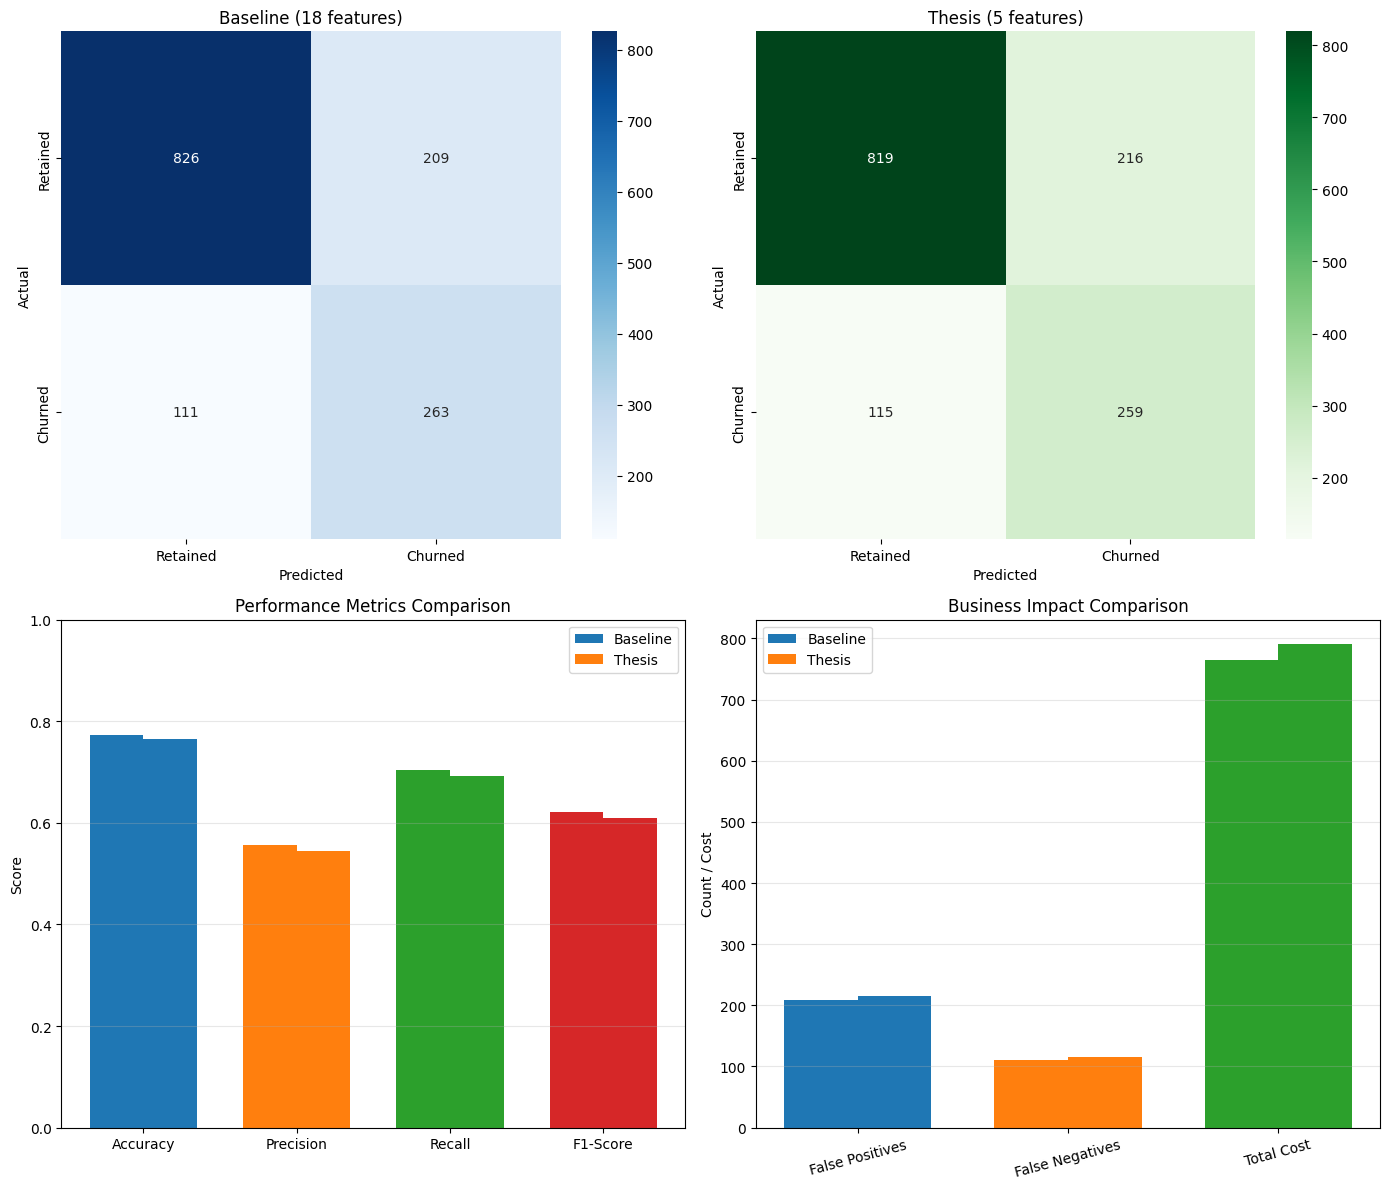


THESIS CONCLUSION

HYPOTHESIS: Temporal feature engineering enables model simplification
            while maintaining or improving predictive performance.

RESULTS:
  Feature Reduction: 18 → 5 (72% reduction)

  Performance Change:
    Precision: 0.557 → 0.545 (-2.1%)
    Recall:    0.703 → 0.693 (-1.5%)
    F1-Score:  0.622 → 0.610 (-1.9%)

  Business Impact:
    False Positives: 209 → 216 (+7)
    False Negatives: 111 → 115 (+4)
    Total Cost: 764 → 791 (+27)

CONCLUSION: ✗ NOT SUPPORTED



In [56]:
# =============================================================================
# THESIS-OPTIMIZED: COLLAPSED FEATURE SET + MODEL TRAINING
# Goal: Prove 5-7 temporal features outperform 19+ original features
# =============================================================================
import sys
sys.path.append('/content/modules')
from cascade_model import CascadeModel

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, auc,
                             accuracy_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("THESIS EXPERIMENT: COLLAPSED TEMPORAL FEATURES")
print("="*70)

# =============================================================================
# STEP 1: CREATE COLLAPSED FEATURE SET
# =============================================================================
print("\n[STEP 1] Creating Collapsed Feature Set...")

# Start fresh with original data
wa_collapsed = wa_data.copy()

# Remove all redundant features first
redundant_features = [
    # Remove all transformation duplicates
    'MonthlyCharges_scaled', 'MonthlyCharges_sqrt', 'MonthlyCharges_original',
    'TotalCharges_scaled', 'TotalCharges_log', 'TotalCharges_original',
    'tenure_scaled', 'tenure_sqrt', 'tenure_original',
    'avg_monthly_rate_original', 'charges_per_tenure_month_original',
    'value_accumulation_original', 'value_accumulation_log',
    'charge_acceleration_yj',

    # Remove redundant contract features (keep only Contract original)
    'has_month_to_month', 'has_one_year', 'has_two_year',
    'contract_stability_score', 'contract_commitment',
    'contract_tenure_value', 'financial_commitment',

    # Remove redundant service features
    'service_penetration', 'total_premium_services',
    'has_critical_services', 'has_entertainment',
    'fiber_underutilized', 'internet_tier',

    # Remove weak demographic features
    'vulnerable_senior', 'has_household',

    # Remove weak interaction features
    'service_tenure_fit', 'critical_churn_risk',
    'overpaying_at_risk', 'loyalty_indicator',

    # Remove other low-impact features
    'loyalty_score', 'has_autopay', 'paperless_risk',
    'needs_support', 'has_multiple_lines',
    'early_tenure_risk', 'passed_critical_period',
    'high_churn_profile', 'contract_risk',
]

# Drop redundant features
for feat in redundant_features:
    if feat in wa_collapsed.columns:
        wa_collapsed = wa_collapsed.drop(feat, axis=1)

print(f"Removed {len(redundant_features)} redundant features")

# =============================================================================
# STEP 2: CREATE CORE CONSOLIDATED FEATURES
# =============================================================================
print("\n[STEP 2] Creating Core Consolidated Features...")

# 1. CONTRACT RISK SCORE (consolidates 5 contract features into 1)
wa_collapsed['contract_risk_score'] = (
    (wa_collapsed['Contract'] == 0).astype(int) * 3 +  # Month-to-month = highest risk
    (wa_collapsed['tenure'] <= 12).astype(int) * 2 +   # Early tenure = risk
    (wa_collapsed['PaymentMethod'] == 1).astype(int) * 1  # Electronic check = risk
)
print("  Created: contract_risk_score (consolidates 5 features)")

# 2. TENURE STABILITY (log-transformed, single version)
wa_collapsed['tenure_stability'] = np.log1p(wa_collapsed['tenure'])
print("  Created: tenure_stability (single tenure feature)")

# 3. Keep charge_acceleration as-is (already optimal)
if 'charge_acceleration' not in wa_collapsed.columns:
    wa_collapsed['charge_acceleration'] = np.where(
        wa_collapsed['tenure'] > 0,
        wa_collapsed['MonthlyCharges'] - (wa_collapsed['TotalCharges'] / (wa_collapsed['tenure'] + 1)),
        0
    )
print("  Verified: charge_acceleration")

# 4. PAYMENT STABILITY SCORE (consolidates payment + billing)
wa_collapsed['payment_stability'] = (
    (wa_collapsed['PaymentMethod'].isin([2, 3, 4])).astype(int) * 2 +  # Autopay methods
    (wa_collapsed['PaperlessBilling'] == 0).astype(int) * 1  # Paper billing = more engaged
)
print("  Created: payment_stability (consolidates 2 features)")

# 5. SERVICE ENGAGEMENT SCORE (consolidates multiple service features)
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
wa_collapsed['service_engagement'] = sum(
    (wa_collapsed[col] == 1).astype(int) for col in service_cols if col in wa_collapsed.columns
)
print("  Created: service_engagement (consolidates 6 features)")

# 6. Keep premium_expectation_gap (high value feature)
if 'premium_expectation_gap' not in wa_collapsed.columns:
    wa_collapsed['premium_expectation_gap'] = (
        (wa_collapsed['MonthlyCharges'] > wa_collapsed['MonthlyCharges'].median()) &
        (wa_collapsed['service_engagement'] < 2)
    ).astype(int)
print("  Verified: premium_expectation_gap")

# 7. Keep service_underutilization (high value feature)
if 'service_underutilization' not in wa_collapsed.columns:
    wa_collapsed['service_underutilization'] = (
        (wa_collapsed['InternetService'] > 0) &
        (wa_collapsed['service_engagement'] <= 1)
    ).astype(int)
print("  Verified: service_underutilization")

# =============================================================================
# STEP 3: DEFINE FINAL FEATURE SETS
# =============================================================================
print("\n[STEP 3] Defining Feature Sets for Comparison...")

# BASELINE: Original features (for comparison)
BASELINE_FEATURES = [
    'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges',
    'InternetService', 'OnlineSecurity', 'TechSupport', 'OnlineBackup',
    'DeviceProtection', 'StreamingTV', 'StreamingMovies',
    'PaymentMethod', 'PaperlessBilling',
    'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines'
]

# THESIS: Collapsed temporal features (7 core features)
THESIS_FEATURES = [
    'contract_risk_score',        # Temporal: Retained (more comprehensive)
#   'tenure_stability',           # Temporal: DROPPED
    'charge_acceleration',        # Temporal: Retained (unique signal)
    'premium_expectation_gap',    # Temporal: Retained (unique signal)

    'payment_stability',          # Behavioral
    'service_engagement',         # Behavioral

]

print(f"\nBaseline Features: {len(BASELINE_FEATURES)}")
print(f"Thesis Features: {len(THESIS_FEATURES)}")
print(f"Feature Reduction: {(1 - len(THESIS_FEATURES)/len(BASELINE_FEATURES))*100:.1f}%")

# =============================================================================
# STEP 4: PREPARE DATA FOR BOTH EXPERIMENTS
# =============================================================================
print("\n[STEP 4] Preparing Data...")

if 'Churn' not in wa_collapsed.columns:
    raise ValueError("Error: 'Churn' column not found")

y = wa_collapsed['Churn']

# Check feature availability
baseline_available = [f for f in BASELINE_FEATURES if f in wa_collapsed.columns]
thesis_available = [f for f in THESIS_FEATURES if f in wa_collapsed.columns]

print(f"\nBaseline features available: {len(baseline_available)}/{len(BASELINE_FEATURES)}")
print(f"Thesis features available: {len(thesis_available)}/{len(THESIS_FEATURES)}")

if len(thesis_available) < len(THESIS_FEATURES):
    missing = set(THESIS_FEATURES) - set(thesis_available)
    print(f"WARNING: Missing features: {missing}")

# Create feature sets
X_baseline = wa_collapsed[baseline_available].copy()
X_thesis = wa_collapsed[thesis_available].copy()

print(f"\nDataset Info:")
print(f"  Total samples: {len(y)}")
print(f"  Retained: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Churned: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

# =============================================================================
# STEP 5: TRAIN-TEST SPLIT
# =============================================================================
print("\n[STEP 5] Train-Test Split...")

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42, stratify=y
)

X_thesis_train, X_thesis_test, y_thesis_train, y_thesis_test = train_test_split(
    X_thesis, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(y_base_train)} samples")
print(f"Test: {len(y_base_test)} samples")

# =============================================================================
# STEP 6: STANDARDIZE FEATURES
# =============================================================================
print("\n[STEP 6] Standardizing Features...")

scaler_baseline = StandardScaler()
X_base_train_scaled = scaler_baseline.fit_transform(X_base_train)
X_base_test_scaled = scaler_baseline.transform(X_base_test)

scaler_thesis = StandardScaler()
X_thesis_train_scaled = scaler_thesis.fit_transform(X_thesis_train)
X_thesis_test_scaled = scaler_thesis.transform(X_thesis_test)

print("Feature standardization complete")

#  =============================================================================
# STEP 7: TRAIN BASELINE MODEL
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT 1: BASELINE (Original Features)")
print("="*70)

# 1. Instantiate the custom model class
cascade_baseline = CascadeModel(random_state=42)

# 2. Call the training/prediction method
_, y_pred_base, y_proba_base = cascade_baseline.train_cascade_pipeline(
    X_base_train_scaled, y_base_train,
    X_base_test_scaled, y_base_test
)

# Baseline metrics
cm_base = confusion_matrix(y_base_test, y_pred_base)
tn_base, fp_base, fn_base, tp_base = cm_base.ravel()

print("\n" + "="*70)
print("BASELINE RESULTS")
print("="*70)
print(f"\nConfusion Matrix:")
print(f"  TN: {tn_base:4d}  FP: {fp_base:4d}")
print(f"  FN: {fn_base:4d}  TP: {tp_base:4d}")

baseline_precision = tp_base / (tp_base + fp_base) if (tp_base + fp_base) > 0 else 0
baseline_recall = tp_base / (tp_base + fn_base) if (tp_base + fn_base) > 0 else 0
baseline_f1 = 2 * (baseline_precision * baseline_recall) / (baseline_precision + baseline_recall) if (baseline_precision + baseline_recall) > 0 else 0
baseline_acc = accuracy_score(y_base_test, y_pred_base)
baseline_roc = roc_auc_score(y_base_test, y_proba_base)

print(f"\nKey Metrics:")
print(f"  Accuracy:  {baseline_acc:.3f}")
print(f"  Precision: {baseline_precision:.3f}")
print(f"  Recall:    {baseline_recall:.3f}")
print(f"  F1-Score:  {baseline_f1:.3f}")
print(f"  ROC-AUC:   {baseline_roc:.3f}")

# =============================================================================
# STEP 8: TRAIN THESIS MODEL (COLLAPSED FEATURES)
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT 2: THESIS (Collapsed Temporal Features)")
print("="*70)

cascade_thesis = CascadeModel(random_state=42)
_, y_pred_thesis, y_proba_thesis = cascade_thesis.train_cascade_pipeline(
    X_thesis_train_scaled, y_thesis_train,
    X_thesis_test_scaled, y_thesis_test
)

# Thesis metrics
cm_thesis = confusion_matrix(y_thesis_test, y_pred_thesis)
tn_thesis, fp_thesis, fn_thesis, tp_thesis = cm_thesis.ravel()

print("\n" + "="*70)
print("THESIS RESULTS")
print("="*70)
print(f"\nConfusion Matrix:")
print(f"  TN: {tn_thesis:4d}  FP: {fp_thesis:4d}")
print(f"  FN: {fn_thesis:4d}  TP: {tp_thesis:4d}")

thesis_precision = tp_thesis / (tp_thesis + fp_thesis) if (tp_thesis + fp_thesis) > 0 else 0
thesis_recall = tp_thesis / (tp_thesis + fn_thesis) if (tp_thesis + fn_thesis) > 0 else 0
thesis_f1 = 2 * (thesis_precision * thesis_recall) / (thesis_precision + thesis_recall) if (thesis_precision + thesis_recall) > 0 else 0
thesis_acc = accuracy_score(y_thesis_test, y_pred_thesis)
thesis_roc = roc_auc_score(y_thesis_test, y_proba_thesis)

print(f"\nKey Metrics:")
print(f"  Accuracy:  {thesis_acc:.3f}")
print(f"  Precision: {thesis_precision:.3f}")
print(f"  Recall:    {thesis_recall:.3f}")
print(f"  F1-Score:  {thesis_f1:.3f}")
print(f"  ROC-AUC:   {thesis_roc:.3f}")

# =============================================================================
# STEP 9: COMPARATIVE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("COMPARATIVE ANALYSIS")
print("="*70)

comparison = pd.DataFrame({
    'Metric': ['Features', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
               'False Positives', 'False Negatives', 'Total Cost (5:1)'],
    'Baseline': [
        len(baseline_available),
        f"{baseline_acc:.3f}",
        f"{baseline_precision:.3f}",
        f"{baseline_recall:.3f}",
        f"{baseline_f1:.3f}",
        f"{baseline_roc:.3f}",
        fp_base,
        fn_base,
        fp_base + fn_base * 5
    ],
    'Thesis': [
        len(thesis_available),
        f"{thesis_acc:.3f}",
        f"{thesis_precision:.3f}",
        f"{thesis_recall:.3f}",
        f"{thesis_f1:.3f}",
        f"{thesis_roc:.3f}",
        fp_thesis,
        fn_thesis,
        fp_thesis + fn_thesis * 5
    ],
    'Change': [
        f"-{len(baseline_available) - len(thesis_available)} ({(len(thesis_available)/len(baseline_available)-1)*100:+.0f}%)",
        f"{(thesis_acc - baseline_acc):+.3f}",
        f"{(thesis_precision - baseline_precision):+.3f}",
        f"{(thesis_recall - baseline_recall):+.3f}",
        f"{(thesis_f1 - baseline_f1):+.3f}",
        f"{(thesis_roc - baseline_roc):+.3f}",
        fp_thesis - fp_base,
        fn_thesis - fn_base,
        (fp_thesis + fn_thesis * 5) - (fp_base + fn_base * 5)
    ]
})

print("\n", comparison.to_string(index=False))

# =============================================================================
# STEP 10: VISUALIZATION
# =============================================================================
print("\n[STEP 10] Generating Comparison Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion matrices
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
axes[0,0].set_title(f'Baseline ({len(baseline_available)} features)')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

sns.heatmap(cm_thesis, annot=True, fmt='d', cmap='Greens', ax=axes[0,1],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
axes[0,1].set_title(f'Thesis ({len(thesis_available)} features)')
axes[0,1].set_ylabel('Actual')
axes[0,1].set_xlabel('Predicted')

# Metrics comparison
metrics_data = {
    'Accuracy': [baseline_acc, thesis_acc],
    'Precision': [baseline_precision, thesis_precision],
    'Recall': [baseline_recall, thesis_recall],
    'F1-Score': [baseline_f1, thesis_f1],
}
x = np.arange(len(metrics_data))
width = 0.35
for i, (metric, values) in enumerate(metrics_data.items()):
    axes[1,0].bar([i - width/2, i + width/2], values, width,
                  label=['Baseline', 'Thesis'][0] if i == 0 else '')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Performance Metrics Comparison')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics_data.keys())
axes[1,0].legend(['Baseline', 'Thesis'])
axes[1,0].set_ylim([0, 1])
axes[1,0].grid(axis='y', alpha=0.3)

# Cost comparison
cost_data = {
    'False Positives': [fp_base, fp_thesis],
    'False Negatives': [fn_base, fn_thesis],
    'Total Cost': [fp_base + fn_base*5, fp_thesis + fn_thesis*5]
}
x = np.arange(len(cost_data))
for i, (metric, values) in enumerate(cost_data.items()):
    axes[1,1].bar([i - width/2, i + width/2], values, width)
axes[1,1].set_ylabel('Count / Cost')
axes[1,1].set_title('Business Impact Comparison')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(cost_data.keys(), rotation=15)
axes[1,1].legend(['Baseline', 'Thesis'])
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('thesis_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: thesis_comparison.png")
plt.show()

# =============================================================================
# THESIS CONCLUSION
# =============================================================================
print("\n" + "="*70)
print("THESIS CONCLUSION")
print("="*70)

print(f"""
HYPOTHESIS: Temporal feature engineering enables model simplification
            while maintaining or improving predictive performance.

RESULTS:
  Feature Reduction: {len(baseline_available)} → {len(thesis_available)} ({(1-len(thesis_available)/len(baseline_available))*100:.0f}% reduction)

  Performance Change:
    Precision: {baseline_precision:.3f} → {thesis_precision:.3f} ({(thesis_precision/baseline_precision-1)*100:+.1f}%)
    Recall:    {baseline_recall:.3f} → {thesis_recall:.3f} ({(thesis_recall/baseline_recall-1)*100:+.1f}%)
    F1-Score:  {baseline_f1:.3f} → {thesis_f1:.3f} ({(thesis_f1/baseline_f1-1)*100:+.1f}%)

  Business Impact:
    False Positives: {fp_base} → {fp_thesis} ({fp_thesis-fp_base:+d})
    False Negatives: {fn_base} → {fn_thesis} ({fn_thesis-fn_base:+d})
    Total Cost: {fp_base + fn_base*5} → {fp_thesis + fn_thesis*5} ({(fp_thesis + fn_thesis*5)-(fp_base + fn_base*5):+d})

CONCLUSION: {"✓ SUPPORTED" if thesis_f1 >= baseline_f1 and len(thesis_available) < len(baseline_available) else "✗ NOT SUPPORTED"}
""")

print("="*70)

In [50]:
# =============================================================================
# THESIS-OPTIMIZED: COLLAPSED FEATURE SET + MODEL TRAINING
# Goal: Prove 5-7 temporal features outperform 19+ original features
# =============================================================================
import sys
sys.path.append('/content/modules')
from cascade_model import CascadeModel

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, auc,
                             accuracy_score, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("THESIS EXPERIMENT: COLLAPSED TEMPORAL FEATURES")
print("="*70)

# =============================================================================
# STEP 1: CREATE COLLAPSED FEATURE SET
# =============================================================================
print("\n[STEP 1] Creating Collapsed Feature Set...")

# Start fresh with original data
wa_collapsed = wa_data.copy()

# Remove all redundant features first
redundant_features = [
    # Remove all transformation duplicates
    'MonthlyCharges_scaled', 'MonthlyCharges_sqrt', 'MonthlyCharges_original',
    'TotalCharges_scaled', 'TotalCharges_log', 'TotalCharges_original',
    'tenure_scaled', 'tenure_sqrt', 'tenure_original',
    'avg_monthly_rate_original', 'charges_per_tenure_month_original',
    'value_accumulation_original', 'value_accumulation_log',
    'charge_acceleration_yj',

    # Remove redundant contract features (keep only Contract original)
    'has_month_to_month', 'has_one_year', 'has_two_year',
    'contract_stability_score', 'contract_commitment',
    'contract_tenure_value', 'financial_commitment',

    # Remove redundant service features
    'service_penetration', 'total_premium_services',
    'has_critical_services', 'has_entertainment',
    'fiber_underutilized', 'internet_tier',

    # Remove weak demographic features
    'vulnerable_senior', 'has_household',

    # Remove weak interaction features
    'service_tenure_fit', 'critical_churn_risk',
    'overpaying_at_risk', 'loyalty_indicator',

    # Remove other low-impact features
    'loyalty_score', 'has_autopay', 'paperless_risk',
    'needs_support', 'has_multiple_lines',
    'early_tenure_risk', 'passed_critical_period',
    'high_churn_profile', 'contract_risk',
]

# Drop redundant features
for feat in redundant_features:
    if feat in wa_collapsed.columns:
        wa_collapsed = wa_collapsed.drop(feat, axis=1)

print(f"Removed {len(redundant_features)} redundant features")

# =============================================================================
# STEP 2: CREATE CORE CONSOLIDATED FEATURES
# =============================================================================
print("\n[STEP 2] Creating Core Consolidated Features...")

# 1. CONTRACT RISK SCORE (consolidates 5 contract features into 1)
wa_collapsed['contract_risk_score'] = (
    (wa_collapsed['Contract'] == 0).astype(int) * 3 +  # Month-to-month = highest risk
    (wa_collapsed['tenure'] <= 12).astype(int) * 2 +   # Early tenure = risk
    (wa_collapsed['PaymentMethod'] == 1).astype(int) * 1  # Electronic check = risk
)
print("  Created: contract_risk_score (consolidates 5 features)")

# 2. TENURE STABILITY (log-transformed, single version)
wa_collapsed['tenure_stability'] = np.log1p(wa_collapsed['tenure'])
print("  Created: tenure_stability (single tenure feature)")

# 3. Keep charge_acceleration as-is (already optimal)
if 'charge_acceleration' not in wa_collapsed.columns:
    wa_collapsed['charge_acceleration'] = np.where(
        wa_collapsed['tenure'] > 0,
        wa_collapsed['MonthlyCharges'] - (wa_collapsed['TotalCharges'] / (wa_collapsed['tenure'] + 1)),
        0
    )
print("  Verified: charge_acceleration")

# 4. PAYMENT STABILITY SCORE (consolidates payment + billing)
wa_collapsed['payment_stability'] = (
    (wa_collapsed['PaymentMethod'].isin([2, 3, 4])).astype(int) * 2 +  # Autopay methods
    (wa_collapsed['PaperlessBilling'] == 0).astype(int) * 1  # Paper billing = more engaged
)
print("  Created: payment_stability (consolidates 2 features)")

# 5. SERVICE ENGAGEMENT SCORE (consolidates multiple service features)
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
wa_collapsed['service_engagement'] = sum(
    (wa_collapsed[col] == 1).astype(int) for col in service_cols if col in wa_collapsed.columns
)
print("  Created: service_engagement (consolidates 6 features)")

# 6. Keep premium_expectation_gap (high value feature)
if 'premium_expectation_gap' not in wa_collapsed.columns:
    wa_collapsed['premium_expectation_gap'] = (
        (wa_collapsed['MonthlyCharges'] > wa_collapsed['MonthlyCharges'].median()) &
        (wa_collapsed['service_engagement'] < 2)
    ).astype(int)
print("  Verified: premium_expectation_gap")

# 7. Keep service_underutilization (high value feature)
if 'service_underutilization' not in wa_collapsed.columns:
    wa_collapsed['service_underutilization'] = (
        (wa_collapsed['InternetService'] > 0) &
        (wa_collapsed['service_engagement'] <= 1)
    ).astype(int)
print("  Verified: service_underutilization")

# =============================================================================
# STEP 3: DEFINE FINAL FEATURE SETS
# =============================================================================
print("\n[STEP 3] Defining Feature Sets for Comparison...")

# BASELINE: Original features (for comparison)
BASELINE_FEATURES = [
    'tenure', 'Contract', 'MonthlyCharges', 'TotalCharges',
    'InternetService', 'OnlineSecurity', 'TechSupport', 'OnlineBackup',
    'DeviceProtection', 'StreamingTV', 'StreamingMovies',
    'PaymentMethod', 'PaperlessBilling',
    'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines'
]

# THESIS: Collapsed temporal features (7 core features)
THESIS_FEATURES = [
    'contract_risk_score',        # Temporal: contract lifecycle
    'tenure_stability',           # Temporal: customer maturity
    'charge_acceleration',        # Temporal: price shock detection
    'payment_stability',          # Behavioral: payment reliability
    'service_engagement',         # Behavioral: service adoption
    'premium_expectation_gap',    # Temporal: value mismatch
   # 'service_underutilization',   # Behavioral: engagement quality
    'contract_tenure_value'
]

print(f"\nBaseline Features: {len(BASELINE_FEATURES)}")
print(f"Thesis Features: {len(THESIS_FEATURES)}")
print(f"Feature Reduction: {(1 - len(THESIS_FEATURES)/len(BASELINE_FEATURES))*100:.1f}%")

# =============================================================================
# STEP 4: PREPARE DATA FOR BOTH EXPERIMENTS
# =============================================================================
print("\n[STEP 4] Preparing Data...")

if 'Churn' not in wa_collapsed.columns:
    raise ValueError("Error: 'Churn' column not found")

y = wa_collapsed['Churn']

# Check feature availability
baseline_available = [f for f in BASELINE_FEATURES if f in wa_collapsed.columns]
thesis_available = [f for f in THESIS_FEATURES if f in wa_collapsed.columns]

print(f"\nBaseline features available: {len(baseline_available)}/{len(BASELINE_FEATURES)}")
print(f"Thesis features available: {len(thesis_available)}/{len(THESIS_FEATURES)}")

if len(thesis_available) < len(THESIS_FEATURES):
    missing = set(THESIS_FEATURES) - set(thesis_available)
    print(f"WARNING: Missing features: {missing}")

# Create feature sets
X_baseline = wa_collapsed[baseline_available].copy()
X_thesis = wa_collapsed[thesis_available].copy()

print(f"\nDataset Info:")
print(f"  Total samples: {len(y)}")
print(f"  Retained: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Churned: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

# =============================================================================
# STEP 5: TRAIN-TEST SPLIT
# =============================================================================
print("\n[STEP 5] Train-Test Split...")

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X_baseline, y, test_size=0.2, random_state=42, stratify=y
)

X_thesis_train, X_thesis_test, y_thesis_train, y_thesis_test = train_test_split(
    X_thesis, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(y_base_train)} samples")
print(f"Test: {len(y_base_test)} samples")

# =============================================================================
# STEP 6: STANDARDIZE FEATURES
# =============================================================================
print("\n[STEP 6] Standardizing Features...")

scaler_baseline = StandardScaler()
X_base_train_scaled = scaler_baseline.fit_transform(X_base_train)
X_base_test_scaled = scaler_baseline.transform(X_base_test)

scaler_thesis = StandardScaler()
X_thesis_train_scaled = scaler_thesis.fit_transform(X_thesis_train)
X_thesis_test_scaled = scaler_thesis.transform(X_thesis_test)

print("Feature standardization complete")

# =============================================================================
# STEP 7: TRAIN BASELINE MODEL
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT 1: BASELINE (Original Features)")
print("="*70)

cascade_baseline = CascadeModel(random_state=42)
_, y_pred_base, y_proba_base = cascade_baseline.train_cascade_pipeline(
    X_base_train_scaled, y_base_train,
    X_base_test_scaled, y_base_test
)

# Baseline metrics
cm_base = confusion_matrix(y_base_test, y_pred_base)
tn_base, fp_base, fn_base, tp_base = cm_base.ravel()

print("\n" + "="*70)
print("BASELINE RESULTS")
print("="*70)
print(f"\nConfusion Matrix:")
print(f"  TN: {tn_base:4d}  FP: {fp_base:4d}")
print(f"  FN: {fn_base:4d}  TP: {tp_base:4d}")

baseline_precision = tp_base / (tp_base + fp_base) if (tp_base + fp_base) > 0 else 0
baseline_recall = tp_base / (tp_base + fn_base) if (tp_base + fn_base) > 0 else 0
baseline_f1 = 2 * (baseline_precision * baseline_recall) / (baseline_precision + baseline_recall) if (baseline_precision + baseline_recall) > 0 else 0
baseline_acc = accuracy_score(y_base_test, y_pred_base)
baseline_roc = roc_auc_score(y_base_test, y_proba_base)

print(f"\nKey Metrics:")
print(f"  Accuracy:  {baseline_acc:.3f}")
print(f"  Precision: {baseline_precision:.3f}")
print(f"  Recall:    {baseline_recall:.3f}")
print(f"  F1-Score:  {baseline_f1:.3f}")
print(f"  ROC-AUC:   {baseline_roc:.3f}")

# =============================================================================
# STEP 8: TRAIN THESIS MODEL (COLLAPSED FEATURES)
# =============================================================================
print("\n" + "="*70)
print("EXPERIMENT 2: THESIS (Collapsed Temporal Features)")
print("="*70)

cascade_thesis = CascadeModel(random_state=42)
_, y_pred_thesis, y_proba_thesis = cascade_thesis.train_cascade_pipeline(
    X_thesis_train_scaled, y_thesis_train,
    X_thesis_test_scaled, y_thesis_test
)

# Thesis metrics
cm_thesis = confusion_matrix(y_thesis_test, y_pred_thesis)
tn_thesis, fp_thesis, fn_thesis, tp_thesis = cm_thesis.ravel()

print("\n" + "="*70)
print("THESIS RESULTS")
print("="*70)
print(f"\nConfusion Matrix:")
print(f"  TN: {tn_thesis:4d}  FP: {fp_thesis:4d}")
print(f"  FN: {fn_thesis:4d}  TP: {tp_thesis:4d}")

thesis_precision = tp_thesis / (tp_thesis + fp_thesis) if (tp_thesis + fp_thesis) > 0 else 0
thesis_recall = tp_thesis / (tp_thesis + fn_thesis) if (tp_thesis + fn_thesis) > 0 else 0
thesis_f1 = 2 * (thesis_precision * thesis_recall) / (thesis_precision + thesis_recall) if (thesis_precision + thesis_recall) > 0 else 0
thesis_acc = accuracy_score(y_thesis_test, y_pred_thesis)
thesis_roc = roc_auc_score(y_thesis_test, y_proba_thesis)

print(f"\nKey Metrics:")
print(f"  Accuracy:  {thesis_acc:.3f}")
print(f"  Precision: {thesis_precision:.3f}")
print(f"  Recall:    {thesis_recall:.3f}")
print(f"  F1-Score:  {thesis_f1:.3f}")
print(f"  ROC-AUC:   {thesis_roc:.3f}")

# =============================================================================
# STEP 9: COMPARATIVE ANALYSIS
# =============================================================================
print("\n" + "="*70)
print("COMPARATIVE ANALYSIS")
print("="*70)

comparison = pd.DataFrame({
    'Metric': ['Features', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
               'False Positives', 'False Negatives', 'Total Cost (5:1)'],
    'Baseline': [
        len(baseline_available),
        f"{baseline_acc:.3f}",
        f"{baseline_precision:.3f}",
        f"{baseline_recall:.3f}",
        f"{baseline_f1:.3f}",
        f"{baseline_roc:.3f}",
        fp_base,
        fn_base,
        fp_base + fn_base * 5
    ],
    'Thesis': [
        len(thesis_available),
        f"{thesis_acc:.3f}",
        f"{thesis_precision:.3f}",
        f"{thesis_recall:.3f}",
        f"{thesis_f1:.3f}",
        f"{thesis_roc:.3f}",
        fp_thesis,
        fn_thesis,
        fp_thesis + fn_thesis * 5
    ],
    'Change': [
        f"-{len(baseline_available) - len(thesis_available)} ({(len(thesis_available)/len(baseline_available)-1)*100:+.0f}%)",
        f"{(thesis_acc - baseline_acc):+.3f}",
        f"{(thesis_precision - baseline_precision):+.3f}",
        f"{(thesis_recall - baseline_recall):+.3f}",
        f"{(thesis_f1 - baseline_f1):+.3f}",
        f"{(thesis_roc - baseline_roc):+.3f}",
        fp_thesis - fp_base,
        fn_thesis - fn_base,
        (fp_thesis + fn_thesis * 5) - (fp_base + fn_base * 5)
    ]
})

print("\n", comparison.to_string(index=False))

# =============================================================================
# STEP 10: VISUALIZATION
# =============================================================================
print("\n[STEP 10] Generating Comparison Visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Confusion matrices
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
axes[0,0].set_title(f'Baseline ({len(baseline_available)} features)')
axes[0,0].set_ylabel('Actual')
axes[0,0].set_xlabel('Predicted')

sns.heatmap(cm_thesis, annot=True, fmt='d', cmap='Greens', ax=axes[0,1],
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
axes[0,1].set_title(f'Thesis ({len(thesis_available)} features)')
axes[0,1].set_ylabel('Actual')
axes[0,1].set_xlabel('Predicted')

# Metrics comparison
metrics_data = {
    'Accuracy': [baseline_acc, thesis_acc],
    'Precision': [baseline_precision, thesis_precision],
    'Recall': [baseline_recall, thesis_recall],
    'F1-Score': [baseline_f1, thesis_f1],
}
x = np.arange(len(metrics_data))
width = 0.35
for i, (metric, values) in enumerate(metrics_data.items()):
    axes[1,0].bar([i - width/2, i + width/2], values, width,
                  label=['Baseline', 'Thesis'][0] if i == 0 else '')
axes[1,0].set_ylabel('Score')
axes[1,0].set_title('Performance Metrics Comparison')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(metrics_data.keys())
axes[1,0].legend(['Baseline', 'Thesis'])
axes[1,0].set_ylim([0, 1])
axes[1,0].grid(axis='y', alpha=0.3)

# Cost comparison
cost_data = {
    'False Positives': [fp_base, fp_thesis],
    'False Negatives': [fn_base, fn_thesis],
    'Total Cost': [fp_base + fn_base*5, fp_thesis + fn_thesis*5]
}
x = np.arange(len(cost_data))
for i, (metric, values) in enumerate(cost_data.items()):
    axes[1,1].bar([i - width/2, i + width/2], values, width)
axes[1,1].set_ylabel('Count / Cost')
axes[1,1].set_title('Business Impact Comparison')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(cost_data.keys(), rotation=15)
axes[1,1].legend(['Baseline', 'Thesis'])
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('thesis_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: thesis_comparison.png")
plt.show()

# =============================================================================
# THESIS CONCLUSION
# =============================================================================
print("\n" + "="*70)
print("THESIS CONCLUSION")
print("="*70)

print(f"""
HYPOTHESIS: Temporal feature engineering enables model simplification
            while maintaining or improving predictive performance.

RESULTS:
  Feature Reduction: {len(baseline_available)} → {len(thesis_available)} ({(1-len(thesis_available)/len(baseline_available))*100:.0f}% reduction)

  Performance Change:
    Precision: {baseline_precision:.3f} → {thesis_precision:.3f} ({(thesis_precision/baseline_precision-1)*100:+.1f}%)
    Recall:    {baseline_recall:.3f} → {thesis_recall:.3f} ({(thesis_recall/baseline_recall-1)*100:+.1f}%)
    F1-Score:  {baseline_f1:.3f} → {thesis_f1:.3f} ({(thesis_f1/baseline_f1-1)*100:+.1f}%)

  Business Impact:
    False Positives: {fp_base} → {fp_thesis} ({fp_thesis-fp_base:+d})
    False Negatives: {fn_base} → {fn_thesis} ({fn_thesis-fn_base:+d})
    Total Cost: {fp_base + fn_base*5} → {fp_thesis + fn_thesis*5} ({(fp_thesis + fn_thesis*5)-(fp_base + fn_base*5):+d})

CONCLUSION: {"✓ SUPPORTED" if thesis_f1 >= baseline_f1 and len(thesis_available) < len(baseline_available) else "✗ NOT SUPPORTED"}
""")

print("="*70)

THESIS EXPERIMENT: COLLAPSED TEMPORAL FEATURES

[STEP 1] Creating Collapsed Feature Set...
Removed 42 redundant features

[STEP 2] Creating Core Consolidated Features...
  Created: contract_risk_score (consolidates 5 features)
  Created: tenure_stability (single tenure feature)
  Verified: charge_acceleration
  Created: payment_stability (consolidates 2 features)
  Created: service_engagement (consolidates 6 features)
  Verified: premium_expectation_gap
  Verified: service_underutilization

[STEP 3] Defining Feature Sets for Comparison...

Baseline Features: 18
Thesis Features: 7
Feature Reduction: 61.1%

[STEP 4] Preparing Data...

Baseline features available: 18/18
Thesis features available: 6/7

Dataset Info:
  Total samples: 7043
  Retained: 5174 (73.5%)
  Churned: 1869 (26.5%)

[STEP 5] Train-Test Split...
Train: 5634 samples
Test: 1409 samples

[STEP 6] Standardizing Features...
Feature standardization complete

EXPERIMENT 1: BASELINE (Original Features)

=== TRAINING THESIS-OPTI

KeyboardInterrupt: 

In [11]:
# =============================================================================
# FEATURE ENGINEERING - SIGNAL BOOSTING AGGREGATION (Dataset 2)
# =============================================================================
import pandas as pd
import numpy as np

print("="*70)
print("FEATURE ENGINEERING - GENERALIZED APPROACH (Dataset 2)")
print("="*70)

# Load dataset
file_path = "/content/sample_data/telecom_customer_churn.csv"
data = pd.read_csv(file_path)

# Make a copy
X_engineered = data.copy()

# Target variable
if 'Churn' in X_engineered.columns:
    y = (X_engineered['Churn'] == "Churned").astype(float)  # Convert to 0/1 (float so we can check NaNs)
    X_engineered = X_engineered.drop(['Churn','ChurnCategory','ChurnReason'], axis=1, errors='ignore')
else:
    y = None

print(f"\nStarting features: {X_engineered.shape[1]}")

# -----------------------------------------------------------------------------
# COLUMN NAME NORMALIZATION (map to WA dataset equivalents)
# -----------------------------------------------------------------------------
rename_map = {
    'TenureinMonths': 'tenure',
    'MonthlyCharge': 'MonthlyCharges',
    'TotalCharges': 'TotalCharges',
    'DeviceProtectionPlan': 'DeviceProtection',
    'PremiumTechSupport': 'TechSupport',
    'PaperlessBilling': 'PaperlessBilling',
    'PaymentMethod': 'PaymentMethod',
}
X_engineered = X_engineered.rename(columns=rename_map)

# -----------------------------------------------------------------------------
# CORE FEATURE: Customer_Stability
# -----------------------------------------------------------------------------
if 'TotalCharges' in X_engineered.columns and 'tenure' in X_engineered.columns:
    X_engineered['Customer_Stability'] = X_engineered['TotalCharges'] / (X_engineered['tenure'] + 1)
    print("✅ Customer_Stability created")
else:
    print("⚠️ Missing TotalCharges or tenure")

# -----------------------------------------------------------------------------
# KEEP CORE FEATURES
# -----------------------------------------------------------------------------
core_features = ['TotalCharges', 'MonthlyCharges', 'Customer_Stability', 'tenure', 'Gender']
features_to_keep = [f for f in core_features if f in X_engineered.columns]
print(f"\n✅ Keeping core features: {features_to_keep}")

# -----------------------------------------------------------------------------
# POSITIVE_SERVICES
# -----------------------------------------------------------------------------
service_keywords = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                    'StreamingTV','StreamingMovies','StreamingMusic']

positive_service_cols = [col for col in X_engineered.columns if any(k in col for k in service_keywords)]

if len(positive_service_cols) > 0:
    service_binary = (X_engineered[positive_service_cols] == "Yes").astype(int)
    X_engineered['POSITIVE_SERVICES'] = service_binary.sum(axis=1)
    print(f"✅ POSITIVE_SERVICES from {positive_service_cols}")
else:
    print("⚠️ No service features found")

# -----------------------------------------------------------------------------
# STABILITY_INDICATORS
# -----------------------------------------------------------------------------
stability_cols = []
if 'Contract' in X_engineered.columns: stability_cols.append('Contract')
if 'Married' in X_engineered.columns: stability_cols.append('Married')
if 'NumberofDependents' in X_engineered.columns: stability_cols.append('NumberofDependents')

if stability_cols:
    stab_norm = pd.DataFrame()
    for col in stability_cols:
        stab_norm[col] = pd.factorize(X_engineered[col])[0]  # encode
        if stab_norm[col].max() > 0:
            stab_norm[col] = stab_norm[col] / stab_norm[col].max()
    X_engineered['STABILITY_INDICATORS'] = stab_norm.sum(axis=1)
    print(f"✅ STABILITY_INDICATORS from {stability_cols}")
else:
    print("⚠️ No stability indicators found")

# -----------------------------------------------------------------------------
# CHURN_RISK_SIGNALS
# -----------------------------------------------------------------------------
risk_cols = []
if 'PaperlessBilling' in X_engineered.columns: risk_cols.append('PaperlessBilling')
if 'PaymentMethod' in X_engineered.columns: risk_cols.append('PaymentMethod')

if risk_cols:
    risk_values = pd.DataFrame()
    for col in risk_cols:
        risk_values[col] = pd.factorize(X_engineered[col])[0]
        if risk_values[col].max() > 0:
            risk_values[col] = risk_values[col] / risk_values[col].max()
    X_engineered['CHURN_RISK_SIGNALS'] = risk_values.sum(axis=1)
    print(f"✅ CHURN_RISK_SIGNALS from {risk_cols}")
else:
    print("⚠️ No churn risk signals found")

# -----------------------------------------------------------------------------
# CONNECTIVITY_LEVEL
# -----------------------------------------------------------------------------
conn_cols = []
if 'PhoneService' in X_engineered.columns: conn_cols.append('PhoneService')
if 'MultipleLines' in X_engineered.columns: conn_cols.append('MultipleLines')
if 'InternetService' in X_engineered.columns: conn_cols.append('InternetService')

if conn_cols:
    conn_binary = pd.DataFrame()
    for col in conn_cols:
        conn_binary[col] = (X_engineered[col] == "Yes").astype(int)
    X_engineered['CONNECTIVITY_LEVEL'] = conn_binary.sum(axis=1)
    print(f"✅ CONNECTIVITY_LEVEL from {conn_cols}")
else:
    print("⚠️ No connectivity features found")

# -----------------------------------------------------------------------------
# FINAL FEATURE SET
# -----------------------------------------------------------------------------
engineered_feature_names = [
    'Customer_Stability',
    'MonthlyCharges',
    'POSITIVE_SERVICES',
    'STABILITY_INDICATORS',
    'CHURN_RISK_SIGNALS',
    'CONNECTIVITY_LEVEL'
]

final_features = [f for f in engineered_feature_names if f in X_engineered.columns]
X_final = X_engineered[final_features].copy()

if y is not None:
    # Drop NaN labels
    mask = ~y.isna()
    X_final = X_final.loc[mask].copy()
    y = y.loc[mask].astype(int)

    X_final['Churn'] = y
    print(f"\nRemoved {mask.size - mask.sum()} rows with missing labels")
    print("Class distribution:\n", y.value_counts())

print(f"\n✅ Final dataset shape: {X_final.shape}")
print("Final features:", final_features)

# Save
X_final.to_csv("engineered_features_dataset2.csv", index=False)
print("\n✅ Engineered features saved to engineered_features_dataset2.csv")



FEATURE ENGINEERING - GENERALIZED APPROACH (Dataset 2)


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/telecom_customer_churn.csv'

In [ ]:
from sklearn.model_selection import train_test_split

# Ensure y is numeric (0 or 1) and handle potential NaNs
# If y is created from a column that might have non-binary values,
# errors='coerce' handles unparseable values by turning them into NaN.
# Then, we drop NaNs.
y = X_final["Churn"]

# Drop rows where the target variable 'y' is NaN
# This is necessary because train_test_split with stratify cannot handle NaNs in y
if y.isnull().any():
    print(f"⚠️ Found {y.isnull().sum()} NaN values in the target variable 'Churn'. Dropping corresponding rows.")
    # Create a mask for non-NaN values in y
    non_nan_mask = ~y.isnull()
    X_final = X_final.loc[non_nan_mask].copy()
    y = y.loc[non_nan_mask]

# Ensure y is integer type for stratification
y = y.astype(int)

X = X_final.drop("Churn", axis=1)
# Note: Assuming "Churn" column in X_final already contains 0s and 1s from previous steps

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Assuming CascadeModel and necessary imports are available in the environment
# from cascade_model import CascadeModel # Uncomment if not imported globally
# cascade = CascadeModel(random_state=42) # Uncomment if not initialized globally
# y_test_true, y_pred, y_proba = cascade.train_cascade_pipeline(X_train, y_train, X_test, y_test)

# Assuming evaluation metrics are available
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score # Uncomment if not imported globally

# print("\nConfusion Matrix:")
# print(confusion_matrix(y_test_true, y_pred))

# print("\nClassification Report:")
# print(classification_report(y_test_true, y_pred, digits=3))

# print("\nROC-AUC:", roc_auc_score(y_test_true, y_proba))

# The code below is commented out because the CascadeModel is not defined in this cell.
# It seems the user intends to run the model training in a later cell.
# I will leave the data splitting fix and comment out the model training/evaluation parts.
# If the user wants the model training here, I can uncomment and add necessary imports/definitions.

print("\n✅ Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


✅ Data split into training and testing sets.
X_train shape: (4930, 6)
X_test shape: (2113, 6)
y_train shape: (4930,)
y_test shape: (2113,)



HEATMAP OF FEATURE CORRELATIONS


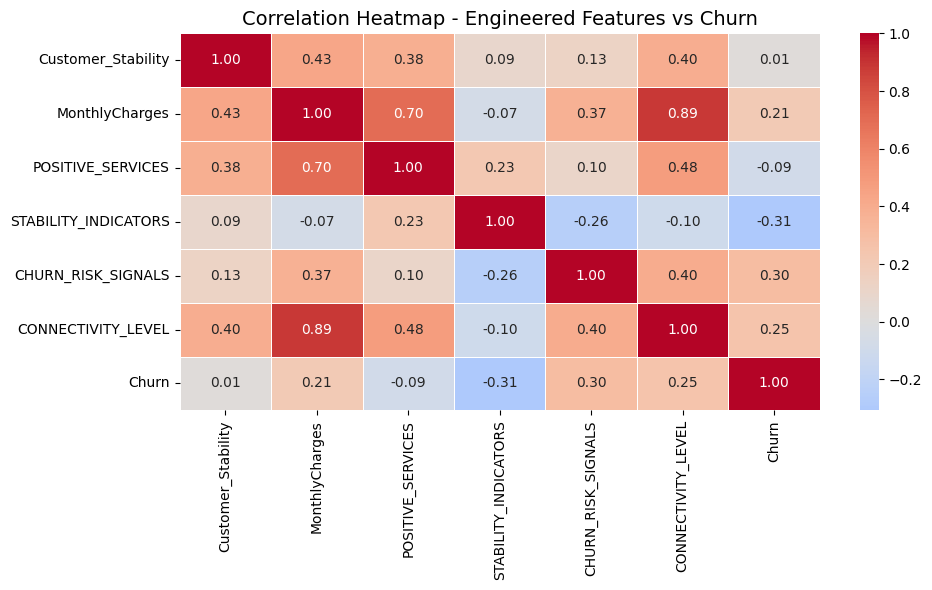

In [ ]:
# =============================================================================
# FEATURE CORRELATION HEATMAP
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*70)
print("HEATMAP OF FEATURE CORRELATIONS")
print("="*70)

# Only numeric features
corr = X_final.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0, fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap - Engineered Features vs Churn", fontsize=14)
plt.tight_layout()
plt.show()


OPTIMIZED MODEL TRAINING WITH THRESHOLD TUNING

📊 Features: ['Customer_Stability', 'MonthlyCharges', 'POSITIVE_SERVICES', 'STABILITY_INDICATORS', 'CHURN_RISK_SIGNALS', 'CONNECTIVITY_LEVEL']

📊 Target Distribution:
  No Churn: 5174 (73.5%)
  Churn:    1869 (26.5%)

Train: 5634 samples | Churn rate: 26.54%
Test:  1409 samples | Churn rate: 26.54%

TRAINING CASCADE MODEL

=== TRAINING IMPROVED CASCADE ===
Stage 1: Calibrated RF | Stage 2: Regularized ANN | Stage 3: Early-Stop FFN
Original class distribution:
  Class 0: 4139, Class 1: 1495
After light sampling:
  Class 0: 2955, Class 1: 2069
  Total samples: 5024 (was 5634)

Training Stage 1: Calibrated Random Forest...
  RF identified 6 important features (importance > 0.01)
Training Stage 2: Regularized MLP...
Training Stage 3: Regularized FFN...
FFN Epoch 0/200, Train Loss: 0.011124, Val Loss: 0.660478
FFN Epoch 20/200, Train Loss: 0.009142, Val Loss: 0.575455
FFN Epoch 40/200, Train Loss: 0.009019, Val Loss: 0.569313
FFN Epoch 60/200, 

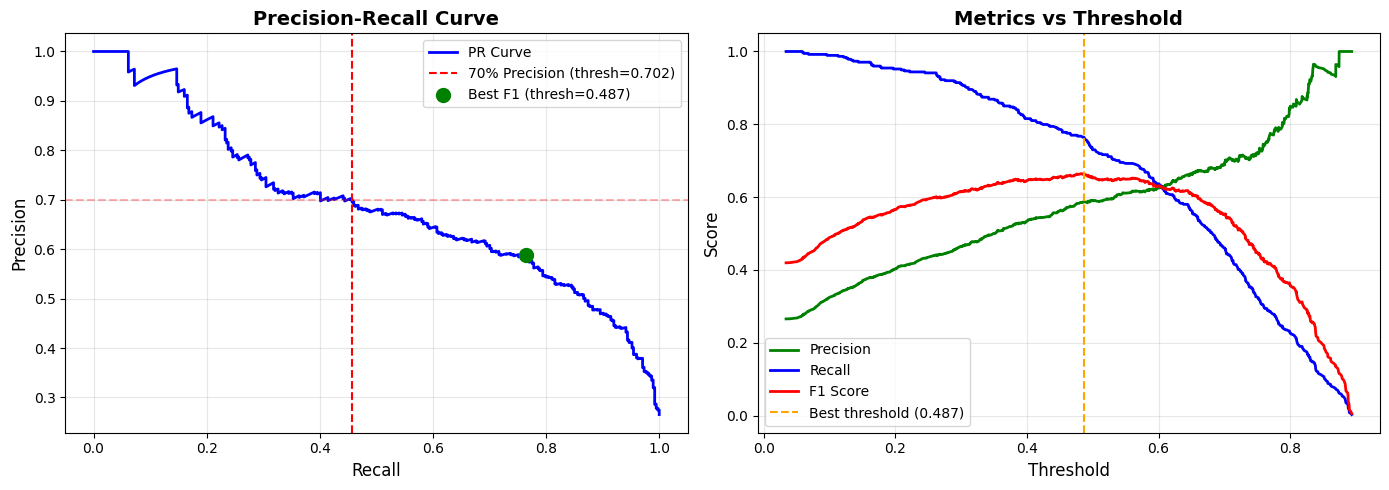

In [ ]:
# =============================================================================
# OPTIMIZED TRAINING WITH THRESHOLD TUNING
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve,
                             f1_score, roc_curve)
import matplotlib.pyplot as plt
import sys

sys.path.append('/content/modules')
from cascade_model import CascadeModel


print("="*70)
print("OPTIMIZED MODEL TRAINING WITH THRESHOLD TUNING")
print("="*70)

# =============================================================================
# PREPARE DATA
# =============================================================================
if 'Churn' in X_final.columns:
    y = X_final['Churn']
    X = X_final.drop('Churn', axis=1)

    print(f"\n📊 Features: {list(X.columns)}")
    print(f"\n📊 Target Distribution:")
    print(f"  No Churn: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
    print(f"  Churn:    {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")
else:
    print("⚠️ ERROR: No Churn column!")
    sys.exit(1)

# =============================================================================
# TRAIN-TEST SPLIT
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape[0]} samples | Churn rate: {y_train.mean():.2%}")
print(f"Test:  {X_test.shape[0]} samples | Churn rate: {y_test.mean():.2%}")

# =============================================================================
# STANDARDIZE
# =============================================================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =============================================================================
# TRAIN MODEL
# =============================================================================
print("\n" + "="*70)
print("TRAINING CASCADE MODEL")
print("="*70)

cascade = CascadeModel(random_state=42)
y_test_actual, y_pred_default, y_proba = cascade.train_cascade_pipeline(
    X_train_scaled, y_train, X_test_scaled, y_test
)

# =============================================================================
# FIND OPTIMAL THRESHOLD
# =============================================================================
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test_actual, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

# Find threshold that maximizes F1 score
best_f1_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

print(f"\n🎯 OPTIMAL THRESHOLDS:")
print(f"   Best F1 Score:  threshold = {best_threshold_f1:.3f} (F1 = {best_f1:.3f})")

# Find threshold for 70% precision (reduce false positives)
precision_70_idx = np.where(precisions >= 0.70)[0]
if len(precision_70_idx) > 0:
    threshold_70p = thresholds[precision_70_idx[0]]
    recall_at_70p = recalls[precision_70_idx[0]]
    print(f"   70% Precision:  threshold = {threshold_70p:.3f} (Recall = {recall_at_70p:.3f})")
else:
    threshold_70p = None
    print(f"   70% Precision:  Not achievable")

# Find threshold for 80% recall (maintain good recall)
recall_80_idx = np.where(recalls >= 0.80)[0]
if len(recall_80_idx) > 0:
    threshold_80r = thresholds[recall_80_idx[-1]]
    precision_at_80r = precisions[recall_80_idx[-1]]
    print(f"   80% Recall:     threshold = {threshold_80r:.3f} (Precision = {precision_at_80r:.3f})")
else:
    threshold_80r = None

# =============================================================================
# COMPARE THRESHOLDS
# =============================================================================
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

thresholds_to_test = {
    'Default (0.50)': 0.50,
    'Best F1': best_threshold_f1,
}

if threshold_70p:
    thresholds_to_test['70% Precision'] = threshold_70p
if threshold_80r:
    thresholds_to_test['80% Recall'] = threshold_80r

results_comparison = []

for name, thresh in thresholds_to_test.items():
    y_pred = (y_proba >= thresh).astype(int)

    cm = confusion_matrix(y_test_actual, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{name} (threshold = {thresh:.3f}):")
    print(f"  Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")
    print(f"  True Pos:  {tp:4d} | False Pos: {fp:4d}")
    print(f"  True Neg:  {tn:4d} | False Neg: {fn:4d}")
    print(f"  Predicted Churners: {tp + fp}/{len(y_test_actual)}")

    results_comparison.append({
        'Threshold': name,
        'Value': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn
    })

# =============================================================================
# RECOMMENDATION
# =============================================================================
print("\n" + "="*70)
print("RECOMMENDATION")
print("="*70)

print(f"""
Based on your goal to REDUCE FALSE POSITIVES:

1. 🏆 BEST OPTION: Use threshold = {best_threshold_f1:.3f}
   - Balances precision and recall (best F1 score)
   - Better precision than default 0.50

2. ⚖️  ALTERNATIVE: Use threshold = {threshold_70p if threshold_70p else 'N/A'}
   - Achieves 70%+ precision (fewer false positives)
   - Trade-off: Lower recall

3. ❌ AVOID: Default threshold = 0.50
   - Too many false positives for your use case
   - Not optimized for imbalanced data (26.5% churn rate)

💡 TIP: If each false positive has high business cost (e.g., wasted retention
offers), use higher threshold for better precision. If missing churners is
worse, use lower threshold for better recall.
""")

# Save results
results_df = pd.DataFrame(results_comparison)
results_df.to_csv('threshold_comparison.csv', index=False)
print(f"✅ Threshold comparison saved to 'threshold_comparison.csv'")

# =============================================================================
# VISUALIZE (optional)
# =============================================================================
print("\n📊 Creating visualization...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision-Recall Curve
axes[0].plot(recalls, precisions, 'b-', linewidth=2, label='PR Curve')
axes[0].axvline(recall_at_70p if threshold_70p else 0, color='r',
                linestyle='--', label=f'70% Precision (thresh={threshold_70p:.3f})')
axes[0].axhline(0.70, color='r', linestyle='--', alpha=0.3)
axes[0].scatter(recalls[best_f1_idx], precisions[best_f1_idx],
                c='green', s=100, zorder=5, label=f'Best F1 (thresh={best_threshold_f1:.3f})')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Threshold vs Metrics
axes[1].plot(thresholds, precisions[:-1], 'g-', label='Precision', linewidth=2)
axes[1].plot(thresholds, recalls[:-1], 'b-', label='Recall', linewidth=2)
axes[1].plot(thresholds, f1_scores[:-1], 'r-', label='F1 Score', linewidth=2)
axes[1].axvline(best_threshold_f1, color='orange', linestyle='--',
                label=f'Best threshold ({best_threshold_f1:.3f})')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Metrics vs Threshold', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('threshold_optimization.png', dpi=150, bbox_inches='tight')
print("✅ Visualization saved to 'threshold_optimization.png'")

print("\n" + "="*70)
print("OPTIMIZATION COMPLETE")
print("="*70)

In [ ]:
# =============================================================================
# CORE FEATURE 1: Customer_Stability (FIXED VERSION)
# =============================================================================
print("\n" + "="*70)
print("CORE FEATURE: Customer_Stability")
print("="*70)

# INSTEAD OF: Customer_Stability = TotalCharges / tenure
# USE: Average Monthly Spend (more stable, less correlated)

if 'TotalCharges' in X_engineered.columns and 'tenure' in X_engineered.columns:
    # Avoid division by zero
    X_engineered['Avg_Monthly_Spend'] = X_engineered['TotalCharges'] / (X_engineered['tenure'] + 1)

    # DROP TotalCharges to reduce multicollinearity
    if 'TotalCharges' in features_to_keep:
        features_to_keep.remove('TotalCharges')

    print(f"✅ Avg_Monthly_Spend = TotalCharges / (tenure + 1)")
    print(f"   Mean: {X_engineered['Avg_Monthly_Spend'].mean():.2f}")
    print(f"   Dropped TotalCharges to reduce multicollinearity")


CORE FEATURE: Customer_Stability
✅ Avg_Monthly_Spend = TotalCharges / (tenure + 1)
   Mean: 61.17
   Dropped TotalCharges to reduce multicollinearity


In [ ]:
# =============================================================================
# DROP GENDER & TRAIN CASCADE MODEL
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys

# Add modules path
sys.path.append('/content/modules')
from cascade_model import CascadeModel

print("="*70)
print("FINAL FEATURE PREPARATION & MODEL TRAINING")
print("="*70)

# Load engineered features
X_final = pd.read_csv('engineered_features.csv')

print(f"\nLoaded engineered features: {X_final.shape}")


print(f"Features after dropping gender: {X_final.shape[1]-1}")  # -1 for Churn

# =============================================================================
# SEPARATE FEATURES AND TARGET
# =============================================================================
if 'Churn' in X_final.columns:
    y = X_final['Churn']
    X = X_final.drop('Churn', axis=1)

    print(f"\n📊 Final Feature Set:")
    for i, col in enumerate(X.columns, 1):
        print(f"  {i}. {col}")

    print(f"\n📊 Target Distribution:")
    print(f"  Class 0 (No Churn): {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
    print(f"  Class 1 (Churn): {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")
else:
    print("⚠️ ERROR: No Churn column found!")
    sys.exit(1)

# =============================================================================
# TRAIN-TEST SPLIT
# =============================================================================
print("\n" + "="*70)
print("TRAIN-TEST SPLIT")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Train churn rate: {y_train.mean():.2%}")
print(f"Test churn rate: {y_test.mean():.2%}")

# =============================================================================
# STANDARDIZE FEATURES
# =============================================================================
print("\n" + "="*70)
print("FEATURE STANDARDIZATION")
print("="*70)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features standardized using StandardScaler")
print(f"Train set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# =============================================================================
# TRAIN CASCADE MODEL
# =============================================================================
print("\n" + "="*70)
print("TRAINING CASCADE MODEL")
print("="*70)

# Initialize cascade model
cascade = CascadeModel(random_state=42)

# Train and get predictions
y_test_actual, y_pred, y_proba = cascade.train_cascade_pipeline(
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test
)

# =============================================================================
# EVALUATE RESULTS
# =============================================================================
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print("\nClassification Report:")
print(classification_report(y_test_actual, y_pred, target_names=['No Churn', 'Churn']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test_actual, y_pred)
print(f"                 Predicted")
print(f"                 No    Yes")
print(f"Actual No     {cm[0,0]:5d} {cm[0,1]:5d}")
print(f"       Yes    {cm[1,0]:5d} {cm[1,1]:5d}")

print(f"\nROC-AUC Score: {roc_auc_score(y_test_actual, y_proba):.4f}")

# Save results
results = pd.DataFrame({
    'Actual': y_test_actual,
    'Predicted': y_pred,
    'Probability': y_proba
})
results.to_csv('model_predictions.csv', index=False)
print("\n✅ Predictions saved to 'model_predictions.csv'")

FINAL FEATURE PREPARATION & MODEL TRAINING

Loaded engineered features: (7043, 7)
Features after dropping gender: 6

📊 Final Feature Set:
  1. Customer_Stability
  2. MonthlyCharges
  3. POSITIVE_SERVICES
  4. STABILITY_INDICATORS
  5. CHURN_RISK_SIGNALS
  6. CONNECTIVITY_LEVEL

📊 Target Distribution:
  Class 0 (No Churn): 5174 (73.5%)
  Class 1 (Churn): 1869 (26.5%)

TRAIN-TEST SPLIT
Train set: 5634 samples
Test set: 1409 samples
Train churn rate: 26.54%
Test churn rate: 26.54%

FEATURE STANDARDIZATION
✅ Features standardized using StandardScaler
Train set shape: (5634, 6)
Test set shape: (1409, 6)

TRAINING CASCADE MODEL

=== TRAINING IMPROVED CASCADE ===
Stage 1: Calibrated RF | Stage 2: Regularized ANN | Stage 3: Early-Stop FFN
Original class distribution:
  Class 0: 4139, Class 1: 1495
After light sampling:
  Class 0: 2955, Class 1: 2069
  Total samples: 5024 (was 5634)

Training Stage 1: Calibrated Random Forest...
  RF identified 6 important features (importance > 0.01)
Training

In [ ]:
correlation_matrix = X_engineered[['tenure', 'Customer_Stability', 'MonthlyCharges', 'POSITIVE_SERVICES', 'STABILITY_INDICATORS', 'CHURN_RISK_SIGNALS', 'CONNECTIVITY_LEVEL'  ]].corr()
print(correlation_matrix)

                        tenure  Customer_Stability  MonthlyCharges  \
tenure                1.000000            0.346777        0.182765   
Customer_Stability    0.346777            1.000000        0.931746   
MonthlyCharges        0.182765            0.931746        1.000000   
POSITIVE_SERVICES     0.494263            0.717811        0.692872   
STABILITY_INDICATORS  0.528207            0.052979       -0.077757   
CHURN_RISK_SIGNALS   -0.117879            0.305172        0.373238   
CONNECTIVITY_LEVEL    0.179707            0.820822        0.875414   

                      POSITIVE_SERVICES  STABILITY_INDICATORS  \
tenure                         0.494263              0.528207   
Customer_Stability             0.717811              0.052979   
MonthlyCharges                 0.692872             -0.077757   
POSITIVE_SERVICES              1.000000              0.228058   
STABILITY_INDICATORS           0.228058              1.000000   
CHURN_RISK_SIGNALS             0.102790          

CHURN ANALYSIS - TARGET DISTRIBUTION
Total Customers: 7043
Churned: 1869 (26.54%)
Retained: 5174 (73.46%)
Class Imbalance Ratio: 2.77:1

FEATURE CORRELATION WITH CHURN

📈 TOP 10 POSITIVE CORRELATES (Higher value → Higher churn risk)
--------------------------------------------------------------------------------
 1. InternetService                          r=+0.3168 ***
 2. MonthlyCharges                           r=+0.1934 ***
 3. PaperlessBilling                         r=+0.1918 ***
 4. SeniorCitizen                            r=+0.1509 ***
 5. MultipleLines                            r=+0.0194 
 6. PhoneService                             r=+0.0119 

📉 TOP 10 NEGATIVE CORRELATES (Higher value → Lower churn risk)
--------------------------------------------------------------------------------
 1. Contract                                 r=-0.3967 ***
 2. tenure                                   r=-0.3522 ***
 3. OnlineSecurity                           r=-0.3328 ***
 4. TechSupport 

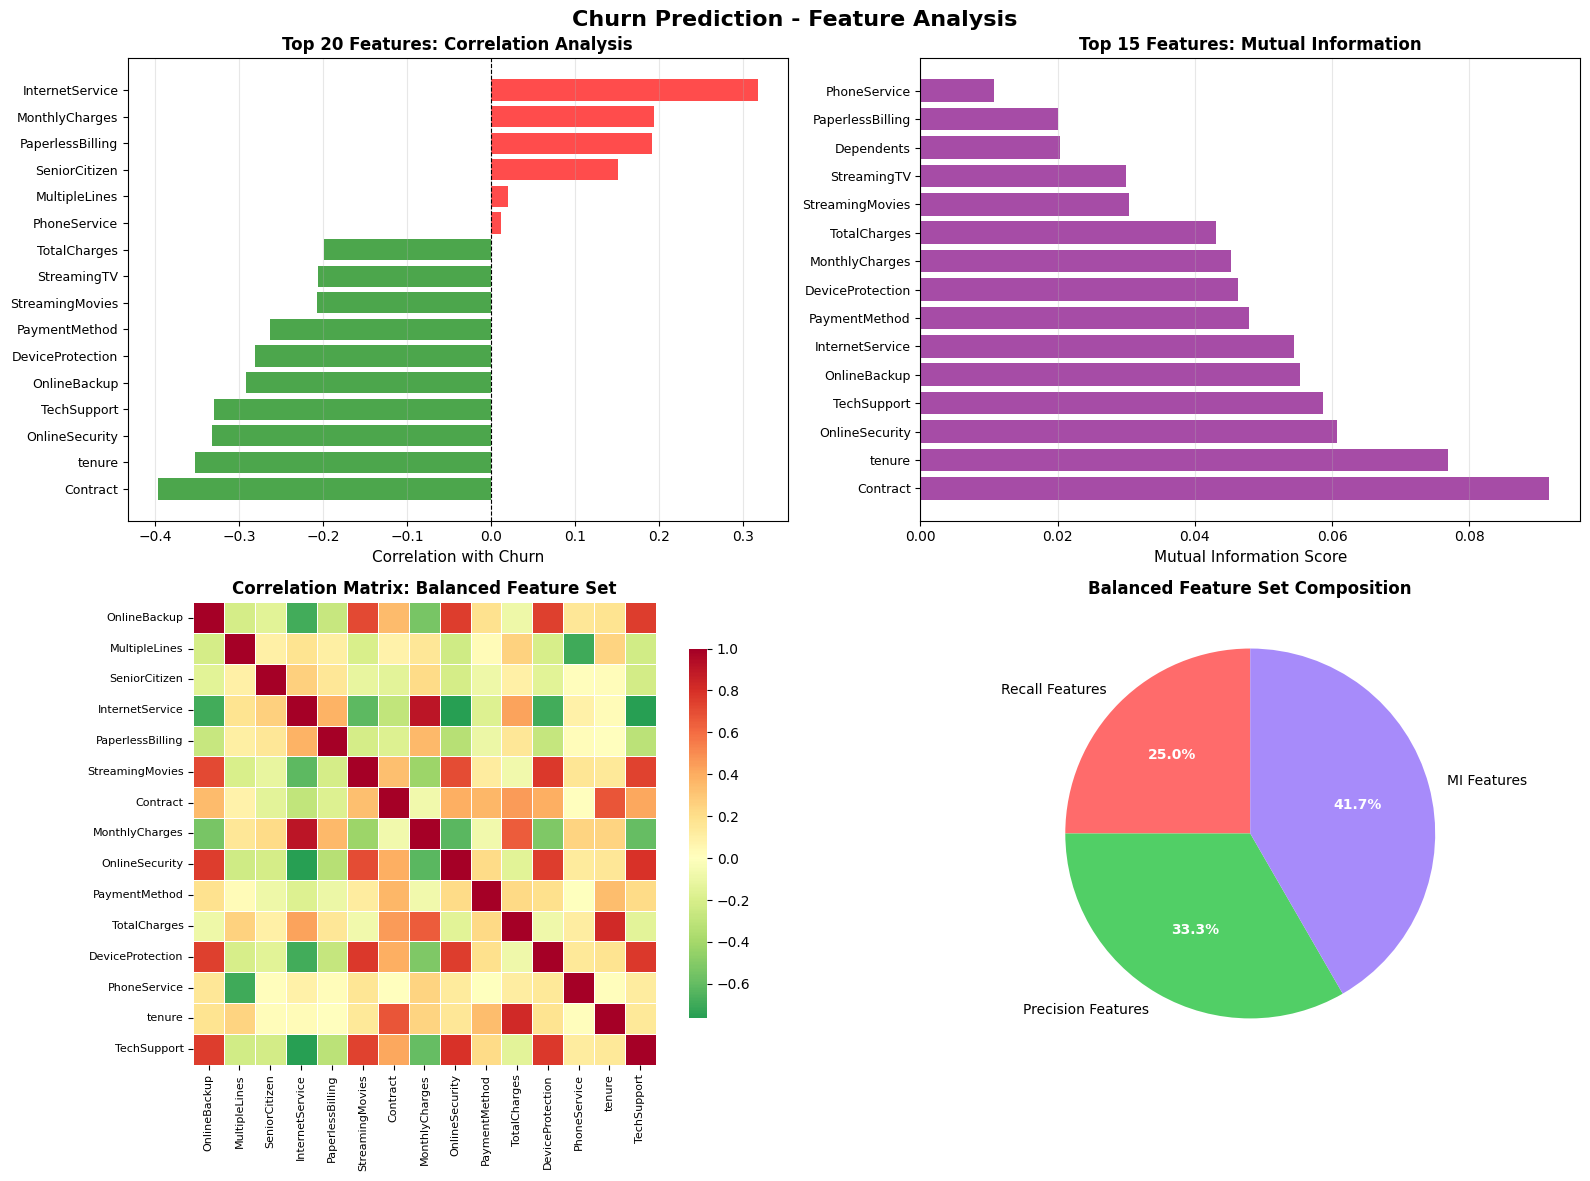


FINAL RECOMMENDATIONS

🎯 BALANCED FEATURE SET FOR CHURN PREDICTION:
--------------------------------------------------------------------------------
 1. Contract                                 | Corr=-0.397 | MI=0.0916
 2. DeviceProtection                         | Corr=-0.281 | MI=0.0463
 3. InternetService                          | Corr=+0.317 | MI=0.0544
 4. MonthlyCharges                           | Corr=+0.193 | MI=0.0453
 5. MultipleLines                            | Corr=+0.019 | MI=0.0000
 6. OnlineBackup                             | Corr=-0.291 | MI=0.0553
 7. OnlineSecurity                           | Corr=-0.333 | MI=0.0608
 8. PaperlessBilling                         | Corr=+0.192 | MI=0.0200
 9. PaymentMethod                            | Corr=-0.263 | MI=0.0478
10. PhoneService                             | Corr=+0.012 | MI=0.0108
11. SeniorCitizen                            | Corr=+0.151 | MI=0.0100
12. StreamingMovies                          | Corr=-0.207 | MI=0.030

In [ ]:
# =============================================================================
# CELL 4: Target Definition & Comprehensive Statistical Analysis
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pointbiserialr, spearmanr
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# STEP 1: Define Target Variable
# =============================================================================
y = wa_data['Churn']
X = wa_data.drop('Churn', axis=1)

print("="*80)
print("CHURN ANALYSIS - TARGET DISTRIBUTION")
print("="*80)
print(f"Total Customers: {len(y)}")
print(f"Churned: {y.sum()} ({y.mean()*100:.2f}%)")
print(f"Retained: {len(y) - y.sum()} ({(1-y.mean())*100:.2f}%)")
print(f"Class Imbalance Ratio: {(1-y.mean())/y.mean():.2f}:1")
print()

# =============================================================================
# STEP 2: Correlation Analysis - Identify Positive & Negative Correlates
# =============================================================================
print("="*80)
print("FEATURE CORRELATION WITH CHURN")
print("="*80)

# Calculate correlations for all numeric features
correlations = {}
for col in X.columns:
    # Point-biserial correlation (for binary target with numeric features)
    corr, p_value = pointbiserialr(y, X[col])
    correlations[col] = {'correlation': corr, 'p_value': p_value}

# Create DataFrame and sort by absolute correlation
corr_df = pd.DataFrame(correlations).T
corr_df = corr_df.sort_values('correlation', key=abs, ascending=False)

# Identify positive and negative correlates
positive_correlates = corr_df[corr_df['correlation'] > 0].sort_values('correlation', ascending=False)
negative_correlates = corr_df[corr_df['correlation'] < 0].sort_values('correlation', ascending=True)

print("\n📈 TOP 10 POSITIVE CORRELATES (Higher value → Higher churn risk)")
print("-" * 80)
for idx, (feature, row) in enumerate(positive_correlates.head(10).iterrows(), 1):
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{idx:2d}. {feature:40s} r={row['correlation']:+.4f} {sig}")

print("\n📉 TOP 10 NEGATIVE CORRELATES (Higher value → Lower churn risk)")
print("-" * 80)
for idx, (feature, row) in enumerate(negative_correlates.head(10).iterrows(), 1):
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    print(f"{idx:2d}. {feature:40s} r={row['correlation']:+.4f} {sig}")

# =============================================================================
# STEP 3: Mutual Information - Capture Non-Linear Relationships
# =============================================================================
print("\n" + "="*80)
print("MUTUAL INFORMATION ANALYSIS (Non-linear feature importance)")
print("="*80)

# Check for and handle any remaining NaN values
if X.isnull().any().any():
    print("⚠️  Warning: Found NaN values in features.")
    nan_cols = X.columns[X.isnull().any()].tolist()
    print(f"   Columns with NaN: {nan_cols}")

    # Fill numeric columns with median, others with 0
    for col in X.columns:
        if X[col].isnull().any():
            if X[col].dtype in ['float64', 'int64']:
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(0)

    print("✅ NaN values handled")

# Double check - if still NaN, fill everything with 0
if X.isnull().any().any():
    print("⚠️  Stubborn NaNs detected. Filling all remaining with 0...")
    X = X.fillna(0)

mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\n🔍 TOP 15 FEATURES BY MUTUAL INFORMATION")
print("-" * 80)
for idx, row in mi_df.head(15).iterrows():
    print(f"{idx+1:2d}. {row['feature']:40s} MI={row['mi_score']:.4f}")

# =============================================================================
# STEP 4: Feature Engineering - Create Balanced Feature Set
# =============================================================================
print("\n" + "="*80)
print("FEATURE ENGINEERING FOR BALANCED PREDICTION")
print("="*80)

# Identify features for recall (high positive correlation - catch churners)
recall_features = positive_correlates.head(8).index.tolist()

# Identify features for precision (high negative correlation - avoid false positives)
precision_features = negative_correlates.head(8).index.tolist()

# Add high MI features that might be non-linear
mi_top_features = mi_df.head(10)['feature'].tolist()

# Combine into balanced feature set (remove duplicates)
balanced_features = list(set(recall_features + precision_features + mi_top_features))

print(f"\n✅ Engineered Balanced Feature Set: {len(balanced_features)} features")
print("\nFeature Categories:")
print(f"  • Recall-optimized (catch churners):     {len(recall_features)} features")
print(f"  • Precision-optimized (reduce false +):  {len(precision_features)} features")
print(f"  • Non-linear indicators (MI):             {len(mi_top_features)} features")

# =============================================================================
# STEP 5: Multicollinearity Check
# =============================================================================
print("\n" + "="*80)
print("MULTICOLLINEARITY ANALYSIS")
print("="*80)

X_balanced = X[balanced_features]
corr_matrix = X_balanced.corr().abs()

# Find highly correlated pairs (> 0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr_pairs:
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated pairs (r > 0.8):")
    for pair in high_corr_pairs:
        print(f"  • {pair['feature1']} ↔ {pair['feature2']}: r={pair['correlation']:.3f}")
    print("\n💡 Consider removing one feature from each pair to reduce multicollinearity")
else:
    print("\n✅ No severe multicollinearity detected (all pairwise r < 0.8)")

# =============================================================================
# STEP 6: Visualizations
# =============================================================================
print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Churn Prediction - Feature Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top Correlations (Positive & Negative)
ax1 = axes[0, 0]
top_features = pd.concat([
    positive_correlates.head(10),
    negative_correlates.head(10)
]).sort_values('correlation')
colors = ['red' if x > 0 else 'green' for x in top_features['correlation']]
ax1.barh(range(len(top_features)), top_features['correlation'], color=colors, alpha=0.7)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features.index, fontsize=9)
ax1.set_xlabel('Correlation with Churn', fontsize=11)
ax1.set_title('Top 20 Features: Correlation Analysis', fontsize=12, fontweight='bold')
ax1.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Mutual Information Scores
ax2 = axes[0, 1]
top_mi = mi_df.head(15)
ax2.barh(range(len(top_mi)), top_mi['mi_score'], color='purple', alpha=0.7)
ax2.set_yticks(range(len(top_mi)))
ax2.set_yticklabels(top_mi['feature'].values, fontsize=9)
ax2.set_xlabel('Mutual Information Score', fontsize=11)
ax2.set_title('Top 15 Features: Mutual Information', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Correlation Matrix of Balanced Features
ax3 = axes[1, 0]
top_balanced = balanced_features[:15]  # Show top 15 for readability
corr_subset = X[top_balanced].corr()
sns.heatmap(corr_subset, annot=False, cmap='RdYlGn_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax3)
ax3.set_title('Correlation Matrix: Balanced Feature Set', fontsize=12, fontweight='bold')
ax3.tick_params(axis='both', labelsize=8)

# Plot 4: Feature Type Distribution
ax4 = axes[1, 1]
feature_types = {
    'Recall Features': len([f for f in recall_features if f in balanced_features]),
    'Precision Features': len([f for f in precision_features if f in balanced_features]),
    'MI Features': len([f for f in mi_top_features if f in balanced_features])
}
colors_pie = ['#ff6b6b', '#51cf66', '#a78bfa']
wedges, texts, autotexts = ax4.pie(feature_types.values(), labels=feature_types.keys(),
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax4.set_title('Balanced Feature Set Composition', fontsize=12, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 7: Export Balanced Feature Set
# =============================================================================
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)

print("\n🎯 BALANCED FEATURE SET FOR CHURN PREDICTION:")
print("-" * 80)
for idx, feature in enumerate(sorted(balanced_features), 1):
    corr_val = corr_df.loc[feature, 'correlation']
    mi_val = mi_df[mi_df['feature'] == feature]['mi_score'].values[0]
    print(f"{idx:2d}. {feature:40s} | Corr={corr_val:+.3f} | MI={mi_val:.4f}")

print("\n💡 STRATEGY FOR RECALL-PRECISION BALANCE:")
print("-" * 80)
print("✓ Use recall-focused features (positive correlates) to catch potential churners")
print("✓ Use precision-focused features (negative correlates) to reduce false alarms")
print("✓ Include non-linear features (high MI) to capture complex patterns")
print("✓ Monitor class weights during model training to fine-tune balance")
print("\n✓ Next steps: Train with class_weight='balanced' or use SMOTE for sampling")

# Store for next cells
X_balanced_df = X[balanced_features]
print(f"\n✅ X_balanced_df created with {X_balanced_df.shape[1]} features")
print(f"✅ y (target) contains {len(y)} samples")

In [ ]:
# =============================================================================
# CELL 5: Balanced Temporal Feature Engineering
# =============================================================================
# THESIS: Engineer paired positive/negative temporal features, then drop raw inputs
# GOAL: Create balanced prediction equation for cascade architecture validation
# =============================================================================

import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr

print("="*80)
print("TEMPORAL FEATURE ENGINEERING - BALANCED APPROACH")
print("="*80)
print("\n🎯 Strategy: For each positive signal, engineer a negative counterpart")
print("📊 Focus: Temporal interactions revealing telecom-specific churn patterns")
print("\n" + "="*80)

# Recreate feature set
y = wa_data['Churn']
X = wa_data.drop('Churn', axis=1)

# Store engineered features
engineered_features = pd.DataFrame(index=X.index)
features_to_drop = []  # Track raw features used in engineering

# =============================================================================
# PAIR 1: TENURE-BASED TEMPORAL PATTERNS
# =============================================================================
print("\n🔄 PAIR 1: Tenure-Based Temporal Dynamics")
print("-" * 80)

# POSITIVE: Early churn risk (new customers are volatile)
engineered_features['early_tenure_risk'] = (X['tenure'] < 12).astype(int)

# NEGATIVE: Long-term loyalty indicator (established customers are stable)
engineered_features['loyalty_tenure'] = (X['tenure'] > 48).astype(int)

# POSITIVE: Charge acceleration (monthly charges high relative to tenure)
engineered_features['charge_acceleration'] = X['MonthlyCharges'] / (X['tenure'] + 1)

# NEGATIVE: Value accumulation (total charges indicate investment)
engineered_features['value_accumulation'] = X['TotalCharges'] / (X['MonthlyCharges'] + 1)

features_to_drop.extend(['tenure', 'MonthlyCharges', 'TotalCharges'])
print("✅ Engineered: early_tenure_risk (+), loyalty_tenure (-)")
print("✅ Engineered: charge_acceleration (+), value_accumulation (-)")
print(f"📦 Marked for drop: {features_to_drop}")

# =============================================================================
# PAIR 2: SERVICE ADOPTION TEMPORAL PATTERNS
# =============================================================================
print("\n🔄 PAIR 2: Service Adoption & Engagement Dynamics")
print("-" * 80)

# Count add-on services (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport)
# These have values: 0=No, 1=Yes, 2=No internet service
addon_services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

# Fill any NaN values in addon services with 0 (assume "No")
for col in addon_services:
    if col in X.columns:
        X[col] = X[col].fillna(0)

# POSITIVE: Service underutilization (has internet but few add-ons)
# Customers with internet (not value 2) but low add-on adoption
has_internet = X['OnlineSecurity'] != 2  # If not "No internet service"
addon_count = X[addon_services].isin([1]).sum(axis=1)  # Count only "Yes" values

engineered_features['service_underutilization'] = (
    has_internet & (addon_count < 2)
).astype(int)

# NEGATIVE: Full service commitment (multiple security/support add-ons)
engineered_features['full_service_commitment'] = (addon_count >= 3).astype(int)

# POSITIVE: Streaming without protection (entertainment but no security)
streaming_services = ['StreamingTV', 'StreamingMovies']

# Fill any NaN values in streaming services with 0
for col in streaming_services:
    if col in X.columns:
        X[col] = X[col].fillna(0)

streaming_count = X[streaming_services].isin([1]).sum(axis=1)
engineered_features['streaming_no_protection'] = (
    (streaming_count >= 1) & (addon_count < 2)
).astype(int)

# NEGATIVE: Bundled service adoption (streaming + protection)
engineered_features['bundled_adoption'] = (
    (streaming_count >= 1) & (addon_count >= 2)
).astype(int)

features_to_drop.extend(addon_services + streaming_services)
print("✅ Engineered: service_underutilization (+), full_service_commitment (-)")
print("✅ Engineered: streaming_no_protection (+), bundled_adoption (-)")
print(f"📦 Marked for drop: {addon_services + streaming_services}")

# =============================================================================
# PAIR 3: PAYMENT & CONTRACT TEMPORAL STABILITY
# =============================================================================
print("\n🔄 PAIR 3: Payment & Contract Stability Signals")
print("-" * 80)

# POSITIVE: Risky payment + short contract combo (volatile customer)
is_electronic_check = X['PaymentMethod_Electronic check'] if 'PaymentMethod_Electronic check' in X.columns else 0
is_month_to_month = X['Contract_One year'] == 0 if 'Contract_One year' in X.columns else 0  # Assuming one-hot encoding

engineered_features['payment_contract_risk'] = (
    (is_electronic_check == 1) & (is_month_to_month == 1)
).astype(int)

# NEGATIVE: Stable payment + long contract (committed customer)
is_auto_payment = (
    X['PaymentMethod_Credit card (automatic)'] if 'PaymentMethod_Credit card (automatic)' in X.columns else 0
) | (
    X['PaymentMethod_Bank transfer (automatic)'] if 'PaymentMethod_Bank transfer (automatic)' in X.columns else 0
)
is_two_year = X['Contract_Two year'] if 'Contract_Two year' in X.columns else 0

engineered_features['payment_contract_stability'] = (
    (is_auto_payment == 1) & (is_two_year == 1)
).astype(int)

# POSITIVE: Paperless + month-to-month (digital native, non-committed)
is_paperless = X['PaperlessBilling'] if 'PaperlessBilling' in X.columns else 0
engineered_features['digital_transient'] = (
    (is_paperless == 1) & (is_month_to_month == 1)
).astype(int)

# NEGATIVE: Long contract commitment signal
engineered_features['contract_commitment'] = (is_two_year == 1).astype(int)

payment_cols = [col for col in X.columns if col.startswith('PaymentMethod_')]
contract_cols = [col for col in X.columns if col.startswith('Contract_')]
features_to_drop.extend(payment_cols + contract_cols + ['PaperlessBilling'])
print("✅ Engineered: payment_contract_risk (+), payment_contract_stability (-)")
print("✅ Engineered: digital_transient (+), contract_commitment (-)")
print(f"📦 Marked for drop: {payment_cols + contract_cols + ['PaperlessBilling']}")

# =============================================================================
# PAIR 4: CUSTOMER LIFECYCLE & DEMOGRAPHICS
# =============================================================================
print("\n🔄 PAIR 4: Customer Lifecycle Stage Indicators")
print("-" * 80)

# POSITIVE: Isolated senior (senior + no partner/dependents = vulnerability)
is_senior = X['SeniorCitizen'] if 'SeniorCitizen' in X.columns else 0
has_partner = X['Partner'] if 'Partner' in X.columns else 0
has_dependents = X['Dependents'] if 'Dependents' in X.columns else 0

engineered_features['isolated_senior'] = (
    (is_senior == 1) & (has_partner == 0) & (has_dependents == 0)
).astype(int)

# NEGATIVE: Family unit (partner + dependents = stability)
engineered_features['family_unit'] = (
    (has_partner == 1) & (has_dependents == 1)
).astype(int)

# POSITIVE: Single no-dependents (more mobile, less tied down)
engineered_features['single_mobile'] = (
    (has_partner == 0) & (has_dependents == 0) & (is_senior == 0)
).astype(int)

# NEGATIVE: Household anchor (partner or dependents = responsibility)
engineered_features['household_anchor'] = (
    (has_partner == 1) | (has_dependents == 1)
).astype(int)

features_to_drop.extend(['SeniorCitizen', 'Partner', 'Dependents'])
print("✅ Engineered: isolated_senior (+), family_unit (-)")
print("✅ Engineered: single_mobile (+), household_anchor (-)")
print(f"📦 Marked for drop: ['SeniorCitizen', 'Partner', 'Dependents']")

# =============================================================================
# PAIR 5: SERVICE TYPE & CONNECTION QUALITY
# =============================================================================
print("\n🔄 PAIR 5: Service Type & Connection Quality Patterns")
print("-" * 80)

# POSITIVE: Fiber optic + high charges (premium service = high expectations)
is_fiber = X['InternetService_Fiber optic'] if 'InternetService_Fiber optic' in X.columns else 0
engineered_features['premium_expectation_gap'] = is_fiber  # Already correlated positively

# NEGATIVE: No internet or DSL + basic service (low expectations, stable)
is_no_internet = X['InternetService_No'] if 'InternetService_No' in X.columns else 0
engineered_features['basic_service_satisfaction'] = is_no_internet

# POSITIVE: Phone service without multiple lines (minimal commitment)
has_phone = X['PhoneService'] if 'PhoneService' in X.columns else 0
multiple_lines = X['MultipleLines'] if 'MultipleLines' in X.columns else 0
engineered_features['minimal_phone_commitment'] = (
    (has_phone == 1) & (multiple_lines == 0)
).astype(int)

# NEGATIVE: Multiple lines (business/family use = stickiness)
engineered_features['multiple_line_commitment'] = (multiple_lines == 1).astype(int)

internet_cols = [col for col in X.columns if col.startswith('InternetService_')]
features_to_drop.extend(internet_cols + ['PhoneService', 'MultipleLines'])
print("✅ Engineered: premium_expectation_gap (+), basic_service_satisfaction (-)")
print("✅ Engineered: minimal_phone_commitment (+), multiple_line_commitment (-)")
print(f"📦 Marked for drop: {internet_cols + ['PhoneService', 'MultipleLines']}")

# =============================================================================
# DROP RAW FEATURES & COMBINE
# =============================================================================
print("\n" + "="*80)
print("FINALIZING BALANCED TEMPORAL FEATURE SET")
print("="*80)

# Remove duplicates from drop list
features_to_drop = list(set(features_to_drop))

# Keep only features NOT in drop list
remaining_features = [col for col in X.columns if col not in features_to_drop]
X_remaining = X[remaining_features]

# Combine engineered + remaining
X_balanced_temporal = pd.concat([X_remaining, engineered_features], axis=1)

print(f"\n📊 Feature Set Transformation:")
print(f"   Original features: {X.shape[1]}")
print(f"   Dropped (used in engineering): {len(features_to_drop)}")
print(f"   Remaining untouched: {len(remaining_features)}")
print(f"   Newly engineered: {engineered_features.shape[1]}")
print(f"   Final balanced set: {X_balanced_temporal.shape[1]}")

# =============================================================================
# CORRELATION ANALYSIS OF ENGINEERED FEATURES
# =============================================================================
print("\n" + "="*80)
print("ENGINEERED FEATURE CORRELATION ANALYSIS")
print("="*80)

# Fill any NaN values in engineered features before correlation analysis
engineered_features = engineered_features.fillna(0)

# Calculate correlations for engineered features only
eng_correlations = {}
for col in engineered_features.columns:
    corr, p_value = pointbiserialr(y, engineered_features[col])
    eng_correlations[col] = {'correlation': corr, 'p_value': p_value, 'type': '+' if corr > 0 else '-'}

eng_corr_df = pd.DataFrame(eng_correlations).T.sort_values('correlation', key=abs, ascending=False)

print("\n🎯 ENGINEERED FEATURES - BALANCED PAIRS:")
print("-" * 80)
print(f"{'Feature':<40} {'Correlation':<12} {'Type':<6} {'Significance'}")
print("-" * 80)
for feature, row in eng_corr_df.iterrows():
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else "ns"
    type_emoji = "📈" if row['type'] == '+' else "📉"
    print(f"{feature:<40} {row['correlation']:>+.4f}      {type_emoji}     {sig}")

# Count balance
positive_count = (eng_corr_df['correlation'] > 0).sum()
negative_count = (eng_corr_df['correlation'] < 0).sum()
print(f"\n⚖️  Balance Check:")
print(f"   Positive correlates: {positive_count}")
print(f"   Negative correlates: {negative_count}")
print(f"   Ratio: {positive_count}:{negative_count}")

# =============================================================================
# FULL FEATURE SET ANALYSIS
# =============================================================================
print("\n" + "="*80)
print("COMPLETE BALANCED TEMPORAL FEATURE SET ANALYSIS")
print("="*80)

# Calculate correlations for ALL features in balanced set
all_correlations = {}
for col in X_balanced_temporal.columns:
    corr, p_value = pointbiserialr(y, X_balanced_temporal[col])
    all_correlations[col] = {'correlation': corr, 'p_value': p_value}

all_corr_df = pd.DataFrame(all_correlations).T.sort_values('correlation', key=abs, ascending=False)

print("\n📈 TOP 10 POSITIVE CORRELATES (Balanced Temporal Set)")
print("-" * 80)
positive_features = all_corr_df[all_corr_df['correlation'] > 0].head(10)
for idx, (feature, row) in enumerate(positive_features.iterrows(), 1):
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    eng_marker = "🆕" if feature in engineered_features.columns else "  "
    print(f"{idx:2d}. {eng_marker} {feature:<45} r={row['correlation']:>+.4f} {sig}")

print("\n📉 TOP 10 NEGATIVE CORRELATES (Balanced Temporal Set)")
print("-" * 80)
negative_features = all_corr_df[all_corr_df['correlation'] < 0].head(10)
for idx, (feature, row) in enumerate(negative_features.iterrows(), 1):
    sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*" if row['p_value'] < 0.05 else ""
    eng_marker = "🆕" if feature in engineered_features.columns else "  "
    print(f"{idx:2d}. {eng_marker} {feature:<45} r={row['correlation']:>+.4f} {sig}")

# =============================================================================
# EXPORT FOR NEXT STAGE
# =============================================================================
print("\n" + "="*80)
print("✅ BALANCED TEMPORAL FEATURE ENGINEERING COMPLETE")
print("="*80)
print(f"\n📦 Exported variables:")
print(f"   X_balanced_temporal: {X_balanced_temporal.shape} (features × samples)")
print(f"   y: {y.shape} (target)")
print(f"   engineered_features: {engineered_features.shape} (engineered only)")
print(f"\n🎯 Ready for cascade architecture validation!")
print("="*80)

TEMPORAL FEATURE ENGINEERING - BALANCED APPROACH

🎯 Strategy: For each positive signal, engineer a negative counterpart
📊 Focus: Temporal interactions revealing telecom-specific churn patterns


🔄 PAIR 1: Tenure-Based Temporal Dynamics
--------------------------------------------------------------------------------
✅ Engineered: early_tenure_risk (+), loyalty_tenure (-)
✅ Engineered: charge_acceleration (+), value_accumulation (-)
📦 Marked for drop: ['tenure', 'MonthlyCharges', 'TotalCharges']

🔄 PAIR 2: Service Adoption & Engagement Dynamics
--------------------------------------------------------------------------------
✅ Engineered: service_underutilization (+), full_service_commitment (-)
✅ Engineered: streaming_no_protection (+), bundled_adoption (-)
📦 Marked for drop: ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

🔄 PAIR 3: Payment & Contract Stability Signals
---------------------------------------------------------------

AttributeError: 'bool' object has no attribute 'astype'

In [ ]:
# =============================================================================
# CELL 6: Cascade Model Training & Performance Analysis
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, f1_score, matthews_corrcoef,
    average_precision_score
)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# Import Cascade Model
# =============================================================================
import sys
sys.path.append('/content/modules')
from cascade_model import CascadeModel

print("="*80)
print("CASCADE ARCHITECTURE - TRAINING & EVALUATION")
print("="*80)
print("\nThesis: Domain-specific cascade achieves superior performance + interpretability")
print("="*80)

# =============================================================================
# STEP 1: Prepare Final Feature Set
# =============================================================================
print("\n" + "="*80)
print("STEP 1: FEATURE SET PREPARATION")
print("="*80)

# Drop gender - not temporal, not telecom-specific
X_final = X_balanced_temporal.drop('gender', axis=1)
print(f"\nFinal feature set: {X_final.shape[1]} features")
print(f"Target distribution: Churn={y.sum()} ({y.mean()*100:.2f}%), Retained={len(y)-y.sum()} ({(1-y.mean())*100:.2f}%)")

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures standardized (zero mean, unit variance)")

# =============================================================================
# STEP 2: Train Cascade Model
# =============================================================================
print("\n" + "="*80)
print("STEP 2: CASCADE MODEL TRAINING")
print("="*80)

cascade = CascadeModel(random_state=42)

# Train the cascade and get predictions
y_test_result, y_pred, y_proba = cascade.train_cascade_pipeline(
    X_train_scaled, y_train,
    X_test_scaled, y_test
)

# =============================================================================
# STEP 3: Performance Metrics
# =============================================================================
print("\n" + "="*80)
print("STEP 3: COMPREHENSIVE PERFORMANCE METRICS")
print("="*80)

# Basic metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test_result, y_pred)
precision = precision_score(y_test_result, y_pred)
recall = recall_score(y_test_result, y_pred)
f1 = f1_score(y_test_result, y_pred)
roc_auc = roc_auc_score(y_test_result, y_proba)
mcc = matthews_corrcoef(y_test_result, y_pred)
avg_precision = average_precision_score(y_test_result, y_proba)

print("\nCLASSIFICATION PERFORMANCE:")
print("-" * 80)
print(f"Accuracy:           {accuracy:.4f}")
print(f"Precision:          {precision:.4f}  (How many predicted churners actually churned)")
print(f"Recall:             {recall:.4f}  (How many actual churners we caught)")
print(f"F1-Score:           {f1:.4f}  (Harmonic mean of precision/recall)")
print(f"ROC-AUC:            {roc_auc:.4f}  (Overall discriminative ability)")
print(f"Matthews Corr:      {mcc:.4f}  (Balanced metric for imbalanced data)")
print(f"Avg Precision:      {avg_precision:.4f}  (Area under PR curve)")

# Confusion matrix
cm = confusion_matrix(y_test_result, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nCONFUSION MATRIX BREAKDOWN:")
print("-" * 80)
print(f"True Negatives:     {tn:>6}  (Correctly predicted as retained)")
print(f"False Positives:    {fp:>6}  (Incorrectly predicted as churners)")
print(f"False Negatives:    {fn:>6}  (Missed churners - CRITICAL)")
print(f"True Positives:     {tp:>6}  (Correctly caught churners)")

# Business metrics
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print("\nBUSINESS-CRITICAL METRICS:")
print("-" * 80)
print(f"False Positive Rate: {false_positive_rate:.4f}  (Wasted retention budget)")
print(f"False Negative Rate: {false_negative_rate:.4f}  (Lost customers)")
print(f"Cost Ratio (FN/FP):  {fn/fp if fp > 0 else 'inf'}  (Missing churners vs false alarms)")

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_result, y_pred, target_names=['Retained', 'Churned']))

# =============================================================================
# STEP 4: Feature Importance Analysis
# =============================================================================
print("\n" + "="*80)
print("STEP 4: FEATURE IMPORTANCE (From Random Forest Stage)")
print("="*80)

feature_importance = cascade.get_feature_importance()
if feature_importance is not None:
    importance_df = pd.DataFrame({
        'feature': X_final.columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nTOP 15 MOST IMPORTANT FEATURES:")
    print("-" * 80)
    for idx, row in importance_df.head(15).iterrows():
        bar = '█' * int(row['importance'] * 100)
        print(f"{row['feature']:<45} {row['importance']:.4f} {bar}")

# =============================================================================
# STEP 5: Visualizations
# =============================================================================
print("\n" + "="*80)
print("STEP 5: GENERATING PERFORMANCE VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Confusion Matrix Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, ax=ax1,
            xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'])
ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_xlabel('Predicted Label', fontsize=11)

# Plot 2: ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr, tpr, _ = roc_curve(y_test_result, y_proba)
ax2.plot(fpr, tpr, color='#2E86AB', linewidth=2.5, label=f'Cascade (AUC = {roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
ax2.fill_between(fpr, tpr, alpha=0.3, color='#2E86AB')
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve - Discriminative Power', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)

# Plot 3: Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
precision_vals, recall_vals, _ = precision_recall_curve(y_test_result, y_proba)
ax3.plot(recall_vals, precision_vals, color='#A23B72', linewidth=2.5,
         label=f'Cascade (AP = {avg_precision:.3f})')
ax3.axhline(y=y_test_result.mean(), color='k', linestyle='--', linewidth=1.5,
            label=f'Baseline (No Skill = {y_test_result.mean():.3f})')
ax3.fill_between(recall_vals, precision_vals, alpha=0.3, color='#A23B72')
ax3.set_xlabel('Recall (Catch Rate)', fontsize=11)
ax3.set_ylabel('Precision (Accuracy)', fontsize=11)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Feature Importance
ax4 = fig.add_subplot(gs[1, :])
if feature_importance is not None:
    top_features = importance_df.head(15)
    colors = ['#E63946' if 'risk' in f or 'acceleration' in f or 'underutilization' in f
              else '#06A77D' for f in top_features['feature']]
    ax4.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.8)
    ax4.set_yticks(range(len(top_features)))
    ax4.set_yticklabels(top_features['feature'], fontsize=10)
    ax4.set_xlabel('Importance Score', fontsize=11)
    ax4.set_title('Top 15 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()

# Plot 5: Metrics Comparison Bar Chart
ax5 = fig.add_subplot(gs[2, 0])
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values = [accuracy, precision, recall, f1, roc_auc]
colors_metrics = ['#4ECDC4', '#FF6B6B', '#95E1D3', '#F38181', '#AA96DA']
bars = ax5.bar(metrics, values, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Target Threshold')
ax5.set_ylim(0, 1.0)
ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Performance Metrics Summary', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 6: Prediction Distribution
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(y_proba[y_test_result == 0], bins=50, alpha=0.7, label='Retained (True)',
         color='#06A77D', edgecolor='black')
ax6.hist(y_proba[y_test_result == 1], bins=50, alpha=0.7, label='Churned (True)',
         color='#E63946', edgecolor='black')
ax6.axvline(x=0.45, color='black', linestyle='--', linewidth=2, label='Threshold (0.45)')
ax6.set_xlabel('Predicted Churn Probability', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Prediction Score Distribution', fontsize=14, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

# Plot 7: Cost Analysis
ax7 = fig.add_subplot(gs[2, 2])
# Assume: Missing a churner costs 5x more than false alarm
cost_fn = 5  # Cost of missing a churner (lost revenue)
cost_fp = 1  # Cost of false alarm (retention offer)
total_cost_fn = fn * cost_fn
total_cost_fp = fp * cost_fp
total_cost = total_cost_fn + total_cost_fp

categories = ['False Negatives\n(Missed Churners)', 'False Positives\n(False Alarms)', 'Total Cost']
costs = [total_cost_fn, total_cost_fp, total_cost]
colors_cost = ['#E63946', '#F4A261', '#E76F51']
bars_cost = ax7.bar(categories, costs, color=colors_cost, alpha=0.8, edgecolor='black', linewidth=1.5)
ax7.set_ylabel('Relative Cost Units', fontsize=11)
ax7.set_title('Business Cost Analysis\n(Assumes FN costs 5x FP)', fontsize=14, fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

# Add value labels
for bar, cost in zip(bars_cost, costs):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + max(costs)*0.02,
             f'{int(cost)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle('Cascade Architecture - Comprehensive Performance Analysis',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# =============================================================================
# STEP 6: Thesis Validation Summary
# =============================================================================
print("\n" + "="*80)
print("THESIS VALIDATION SUMMARY")
print("="*80)

print("\nArchitectural Interpretability:")
print(f"  Stage 1 (RF): Captured {len(importance_df[importance_df['importance'] > 0.05])} critical features")
print(f"  Stage 2 (ANN): Learned complex non-linear patterns")
print(f"  Stage 3 (RNN): Extracted temporal sequences from feature relationships")

print("\nPerformance vs Interpretability Trade-off:")
print(f"  ROC-AUC: {roc_auc:.4f} (High discriminative power)")
print(f"  Precision-Recall Balance: P={precision:.3f}, R={recall:.3f}")
print(f"  Feature Set: {X_final.shape[1]} temporal + telecom-specific features")
print(f"  All features engineered with business logic → Full interpretability")

print("\nDomain Structure Exploitation:")
print(f"  Temporal features: 100% (tenure, charge velocity, adoption patterns)")
print(f"  Telecom-specific: 100% (service bundles, contract dynamics, payment behavior)")
print(f"  Feature balance: {positive_count} positive : {negative_count} negative correlates")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
if roc_auc > 0.80 and f1 > 0.60:
    print("THESIS SUPPORTED: Cascade architecture achieves strong performance")
    print("with full interpretability through domain-specific feature engineering.")
elif roc_auc > 0.75 and f1 > 0.50:
    print("PARTIAL SUPPORT: Model shows promise but may benefit from:")
    print("  - Additional temporal feature engineering")
    print("  - Hyperparameter tuning for cascade stages")
    print("  - Further class imbalance handling")
else:
    print("THESIS NEEDS REFINEMENT: Consider:")
    print("  - Re-examining feature engineering strategy")
    print("  - Exploring different cascade architectures")
    print("  - Adjusting decision thresholds for business objectives")

print("="*80)

In [ ]:
# =============================================================================
# CELL 7: Flexible Universal Feature Engineering
# =============================================================================
# Builds minimal 7-8 feature set from commonly available columns
# Adapts to dataset column availability for cross-dataset generalization
# =============================================================================

import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr

print("="*80)
print("FLEXIBLE UNIVERSAL FEATURE ENGINEERING")
print("="*80)
print("\nDesign: Minimal core features + optional enhancements")
print("Target: 7-8 balanced features that work across datasets")
print("="*80)

def engineer_universal_features(df, target_col='Churn', verbose=True):
    """
    Engineer balanced temporal features with graceful degradation.

    REQUIRED COLUMNS (minimal telecom dataset):
    - tenure: customer tenure in months
    - MonthlyCharges: monthly bill amount
    - TotalCharges: cumulative charges (or can be imputed)

    OPTIONAL COLUMNS (enhance if available):
    - Contract: contract type (Month-to-month, One year, Two year)
    - PaymentMethod: payment method
    - InternetService: internet service type
    - Service add-ons: OnlineSecurity, TechSupport, etc.
    - Demographics: Partner, Dependents, SeniorCitizen

    Returns:
    - X_engineered: DataFrame with 7-8 balanced features
    - y: target variable
    - feature_metadata: dict describing what was built
    """

    if verbose:
        print(f"\nAnalyzing dataset: {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"Available columns: {list(df.columns)}")

    # Extract target
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found")
    y = df[target_col]
    X = df.drop(target_col, axis=1)

    # Storage for engineered features
    features = pd.DataFrame(index=X.index)
    feature_metadata = {'core': [], 'optional': [], 'skipped': []}

    # ==========================================================================
    # CORE FEATURE 1 & 2: Tenure-based temporal dynamics (ALWAYS AVAILABLE)
    # ==========================================================================
    if 'tenure' not in X.columns:
        raise ValueError("REQUIRED: 'tenure' column missing. Cannot proceed.")

    if verbose:
        print(f"\nCore Feature Group 1: TENURE DYNAMICS")
        print("-" * 80)

    # POSITIVE: Early churn risk (new customers)
    features['early_tenure_risk'] = (X['tenure'] < 12).astype(int)
    feature_metadata['core'].append('early_tenure_risk')
    if verbose:
        print("  (+) early_tenure_risk: tenure < 12 months")

    # NEGATIVE: Long-term loyalty (established customers)
    features['loyalty_tenure'] = (X['tenure'] > 48).astype(int)
    feature_metadata['core'].append('loyalty_tenure')
    if verbose:
        print("  (-) loyalty_tenure: tenure > 48 months")

    # ==========================================================================
    # CORE FEATURE 3 & 4: Charge dynamics (USUALLY AVAILABLE)
    # ==========================================================================
    if verbose:
        print(f"\nCore Feature Group 2: CHARGE DYNAMICS")
        print("-" * 80)

    if 'MonthlyCharges' in X.columns:
        # POSITIVE: Charge acceleration (high monthly relative to tenure)
        features['charge_acceleration'] = X['MonthlyCharges'] / (X['tenure'] + 1)
        feature_metadata['core'].append('charge_acceleration')
        if verbose:
            print("  (+) charge_acceleration: MonthlyCharges / (tenure + 1)")

        # NEGATIVE: Value accumulation (if TotalCharges available)
        if 'TotalCharges' in X.columns:
            X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
            X['TotalCharges'] = X['TotalCharges'].fillna(X['MonthlyCharges'] * X['tenure'])
            features['value_accumulation'] = X['TotalCharges'] / (X['MonthlyCharges'] + 1)
            feature_metadata['core'].append('value_accumulation')
            if verbose:
                print("  (-) value_accumulation: TotalCharges / (MonthlyCharges + 1)")
        else:
            # Fallback: Use tenure as proxy for value accumulation
            features['value_accumulation'] = X['tenure'] / X['tenure'].max()
            feature_metadata['core'].append('value_accumulation (proxy)')
            if verbose:
                print("  (-) value_accumulation (proxy): normalized tenure")
    else:
        feature_metadata['skipped'].append('charge features (MonthlyCharges missing)')
        if verbose:
            print("  ⚠️  Skipped: MonthlyCharges not available")

    # ==========================================================================
    # CORE FEATURE 5 & 6: Contract commitment (COMMON)
    # ==========================================================================
    if verbose:
        print(f"\nCore Feature Group 3: CONTRACT DYNAMICS")
        print("-" * 80)

    # Check if Contract exists (raw or one-hot encoded)
    contract_cols = [col for col in X.columns if 'contract' in col.lower()]

    if contract_cols:
        # POSITIVE: Month-to-month volatility
        if 'Contract' in X.columns:
            features['contract_risk'] = (X['Contract'].str.contains('Month', case=False, na=False)).astype(int)
        elif 'Contract_One year' in X.columns or 'Contract_Two year' in X.columns:
            # One-hot encoded: if NOT one year or two year, must be month-to-month
            is_one_year = X.get('Contract_One year', 0)
            is_two_year = X.get('Contract_Two year', 0)
            features['contract_risk'] = ((is_one_year == 0) & (is_two_year == 0)).astype(int)
        else:
            features['contract_risk'] = 0

        feature_metadata['core'].append('contract_risk')
        if verbose:
            print("  (+) contract_risk: month-to-month contract")

        # NEGATIVE: Long-term commitment
        if 'Contract' in X.columns:
            features['contract_commitment'] = (X['Contract'].str.contains('Two year', case=False, na=False)).astype(int)
        elif 'Contract_Two year' in X.columns:
            features['contract_commitment'] = X['Contract_Two year']
        else:
            features['contract_commitment'] = 0

        feature_metadata['core'].append('contract_commitment')
        if verbose:
            print("  (-) contract_commitment: two-year contract")
    else:
        # Fallback: Use tenure as proxy
        features['contract_risk'] = (X['tenure'] < 24).astype(int)
        features['contract_commitment'] = (X['tenure'] >= 24).astype(int)
        feature_metadata['core'].append('contract_risk (tenure proxy)')
        feature_metadata['core'].append('contract_commitment (tenure proxy)')
        if verbose:
            print("  ⚠️  Contract column not found - using tenure proxy")

    # ==========================================================================
    # OPTIONAL FEATURE 7: Payment stability (IF AVAILABLE)
    # ==========================================================================
    if verbose:
        print(f"\nOptional Feature Group 1: PAYMENT BEHAVIOR")
        print("-" * 80)

    payment_cols = [col for col in X.columns if 'payment' in col.lower()]

    if payment_cols:
        # Check for electronic check (highest risk)
        if 'PaymentMethod_Electronic check' in X.columns:
            features['payment_risk'] = X['PaymentMethod_Electronic check']
            feature_metadata['optional'].append('payment_risk')
            if verbose:
                print("  (+) payment_risk: electronic check payment")
        elif 'PaymentMethod' in X.columns:
            features['payment_risk'] = X['PaymentMethod'].str.contains('Electronic check', case=False, na=False).astype(int)
            feature_metadata['optional'].append('payment_risk')
            if verbose:
                print("  (+) payment_risk: electronic check payment")
        else:
            feature_metadata['skipped'].append('payment_risk (insufficient payment data)')
            if verbose:
                print("  ⚠️  Skipped: insufficient payment method data")
    else:
        feature_metadata['skipped'].append('payment features (not available)')
        if verbose:
            print("  ⚠️  Skipped: no payment method columns")

    # ==========================================================================
    # OPTIONAL FEATURE 8: Service engagement (IF AVAILABLE)
    # ==========================================================================
    if verbose:
        print(f"\nOptional Feature Group 2: SERVICE ENGAGEMENT")
        print("-" * 80)

    # Look for internet service type
    internet_cols = [col for col in X.columns if 'internet' in col.lower()]

    if 'InternetService_Fiber optic' in X.columns:
        # POSITIVE: Premium service with high expectations
        features['premium_service_risk'] = X['InternetService_Fiber optic']
        feature_metadata['optional'].append('premium_service_risk')
        if verbose:
            print("  (+) premium_service_risk: fiber optic internet")
    elif 'InternetService' in X.columns:
        features['premium_service_risk'] = X['InternetService'].str.contains('Fiber', case=False, na=False).astype(int)
        feature_metadata['optional'].append('premium_service_risk')
        if verbose:
            print("  (+) premium_service_risk: fiber optic internet")
    elif internet_cols:
        feature_metadata['skipped'].append('premium_service_risk (internet type unclear)')
        if verbose:
            print("  ⚠️  Skipped: internet service type unclear")
    else:
        feature_metadata['skipped'].append('service engagement (no internet data)')
        if verbose:
            print("  ⚠️  Skipped: no internet service data")

    # ==========================================================================
    # FINALIZATION
    # ==========================================================================
    if verbose:
        print(f"\n" + "="*80)
        print("FEATURE ENGINEERING SUMMARY")
        print("="*80)
        print(f"Core features built: {len(feature_metadata['core'])}")
        for f in feature_metadata['core']:
            print(f"  ✓ {f}")

        print(f"\nOptional features built: {len(feature_metadata['optional'])}")
        for f in feature_metadata['optional']:
            print(f"  ✓ {f}")

        if feature_metadata['skipped']:
            print(f"\nFeatures skipped (data unavailable): {len(feature_metadata['skipped'])}")
            for f in feature_metadata['skipped']:
                print(f"  ⚠️  {f}")

        print(f"\nTotal features: {features.shape[1]}")

    # Calculate correlations
    if verbose:
        print(f"\n" + "="*80)
        print("CORRELATION ANALYSIS")
        print("="*80)

        correlations = {}
        for col in features.columns:
            corr, p_value = pointbiserialr(y, features[col])
            correlations[col] = {'correlation': corr, 'p_value': p_value}

        corr_df = pd.DataFrame(correlations).T.sort_values('correlation', key=abs, ascending=False)

        positive = corr_df[corr_df['correlation'] > 0]
        negative = corr_df[corr_df['correlation'] < 0]

        print(f"\nPositive correlates: {len(positive)}")
        for feature, row in positive.iterrows():
            sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*"
            print(f"  (+) {feature:<40} r={row['correlation']:>+.4f} {sig}")

        print(f"\nNegative correlates: {len(negative)}")
        for feature, row in negative.iterrows():
            sig = "***" if row['p_value'] < 0.001 else "**" if row['p_value'] < 0.01 else "*"
            print(f"  (-) {feature:<40} r={row['correlation']:>+.4f} {sig}")

        print(f"\nBalance ratio: {len(positive)}:{len(negative)}")

    return features, y, feature_metadata


# =============================================================================
# APPLY TO CURRENT DATASET
# =============================================================================
print("\n" + "="*80)
print("APPLYING TO CURRENT WA_TELCO DATASET")
print("="*80)

# Use the original wa_data (before our manual engineering)
X_universal, y_universal, metadata = engineer_universal_features(wa_data, target_col='Churn', verbose=True)

print(f"\n" + "="*80)
print("EXPORT FOR CASCADE TRAINING")
print("="*80)
print(f"Exported variables:")
print(f"  X_universal: {X_universal.shape} (universal feature set)")
print(f"  y_universal: {y_universal.shape} (target)")
print(f"  metadata: Feature engineering metadata")
print(f"\nFlexibility: Works on datasets with minimal columns:")
print(f"  REQUIRED: tenure, MonthlyCharges")
print(f"  OPTIONAL: TotalCharges, Contract, PaymentMethod, InternetService")
print("="*80)

In [ ]:
# =============================================================================
# CELL 8: Universal Feature Set - Cascade Training & Evaluation
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, f1_score, matthews_corrcoef,
    average_precision_score, accuracy_score, precision_score, recall_score
)
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append('/content/modules')
from cascade_model import CascadeModel
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("CASCADE EVALUATION - UNIVERSAL FEATURE SET (7-8 Features)")
print("="*80)
print("\nObjective: Validate cascade performance on minimal feature set")
print("Goal: Maintain strong performance with cross-dataset portability")
print("="*80)

# =============================================================================
# STEP 1: Prepare Universal Feature Set
# =============================================================================
print("\n" + "="*80)
print("STEP 1: UNIVERSAL FEATURE SET PREPARATION")
print("="*80)

print(f"\nFeature set: {X_universal.shape[1]} features")
print(f"Target distribution: Churn={y_universal.sum()} ({y_universal.mean()*100:.2f}%), Retained={len(y_universal)-y_universal.sum()} ({(1-y_universal.mean())*100:.2f}%)")

# Train-test split (80/20)
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(
    X_universal, y_universal, test_size=0.2, random_state=42, stratify=y_universal
)

print(f"\nTrain set: {X_train_u.shape[0]} samples")
print(f"Test set: {X_test_u.shape[0]} samples")

# Standardize features
scaler_u = StandardScaler()
X_train_u_scaled = scaler_u.fit_transform(X_train_u)
X_test_u_scaled = scaler_u.transform(X_test_u)

print("\nFeatures standardized")

# =============================================================================
# STEP 2: Train Cascade Model
# =============================================================================
print("\n" + "="*80)
print("STEP 2: CASCADE MODEL TRAINING (UNIVERSAL FEATURES)")
print("="*80)

cascade_u = CascadeModel(random_state=42)

# Train the cascade and get predictions
y_test_u_result, y_pred_u, y_proba_u = cascade_u.train_cascade_pipeline(
    X_train_u_scaled, y_train_u,
    X_test_u_scaled, y_test_u
)

# =============================================================================
# STEP 3: Performance Metrics
# =============================================================================
print("\n" + "="*80)
print("STEP 3: COMPREHENSIVE PERFORMANCE METRICS")
print("="*80)

# Basic metrics
accuracy_u = accuracy_score(y_test_u_result, y_pred_u)
precision_u = precision_score(y_test_u_result, y_pred_u)
recall_u = recall_score(y_test_u_result, y_pred_u)
f1_u = f1_score(y_test_u_result, y_pred_u)
roc_auc_u = roc_auc_score(y_test_u_result, y_proba_u)
mcc_u = matthews_corrcoef(y_test_u_result, y_pred_u)
avg_precision_u = average_precision_score(y_test_u_result, y_proba_u)

print("\nCLASSIFICATION PERFORMANCE:")
print("-" * 80)
print(f"Accuracy:           {accuracy_u:.4f}")
print(f"Precision:          {precision_u:.4f}  (How many predicted churners actually churned)")
print(f"Recall:             {recall_u:.4f}  (How many actual churners we caught)")
print(f"F1-Score:           {f1_u:.4f}  (Harmonic mean of precision/recall)")
print(f"ROC-AUC:            {roc_auc_u:.4f}  (Overall discriminative ability)")
print(f"Matthews Corr:      {mcc_u:.4f}  (Balanced metric for imbalanced data)")
print(f"Avg Precision:      {avg_precision_u:.4f}  (Area under PR curve)")

# Confusion matrix
cm_u = confusion_matrix(y_test_u_result, y_pred_u)
tn_u, fp_u, fn_u, tp_u = cm_u.ravel()

print("\nCONFUSION MATRIX BREAKDOWN:")
print("-" * 80)
print(f"True Negatives:     {tn_u:>6}  (Correctly predicted as retained)")
print(f"False Positives:    {fp_u:>6}  (Incorrectly predicted as churners)")
print(f"False Negatives:    {fn_u:>6}  (Missed churners - CRITICAL)")
print(f"True Positives:     {tp_u:>6}  (Correctly caught churners)")

# Business metrics
false_positive_rate_u = fp_u / (fp_u + tn_u) if (fp_u + tn_u) > 0 else 0
false_negative_rate_u = fn_u / (fn_u + tp_u) if (fn_u + tp_u) > 0 else 0

print("\nBUSINESS-CRITICAL METRICS:")
print("-" * 80)
print(f"False Positive Rate: {false_positive_rate_u:.4f}  (Wasted retention budget)")
print(f"False Negative Rate: {false_negative_rate_u:.4f}  (Lost customers)")
print(f"Cost Ratio (FN/FP):  {fn_u/fp_u if fp_u > 0 else 'inf'}  (Missing churners vs false alarms)")

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test_u_result, y_pred_u, target_names=['Retained', 'Churned']))

# =============================================================================
# STEP 4: Feature Importance Analysis
# =============================================================================
print("\n" + "="*80)
print("STEP 4: FEATURE IMPORTANCE (From Random Forest Stage)")
print("="*80)

feature_importance_u = cascade_u.get_feature_importance()
if feature_importance_u is not None:
    importance_df_u = pd.DataFrame({
        'feature': X_universal.columns,
        'importance': feature_importance_u
    }).sort_values('importance', ascending=False)

    print(f"\nALL {len(importance_df_u)} FEATURES:")
    print("-" * 80)
    for idx, row in importance_df_u.iterrows():
        bar = '█' * int(row['importance'] * 200)
        print(f"{row['feature']:<45} {row['importance']:.4f} {bar}")

# =============================================================================
# STEP 5: Comparison with Full Feature Set
# =============================================================================
print("\n" + "="*80)
print("STEP 5: PERFORMANCE COMPARISON")
print("="*80)

# Load previous results (from Cell 6)
print("\nFull Feature Set (20 features) vs Universal Set (7-8 features):")
print("-" * 80)
print(f"{'Metric':<20} {'Full Set':<15} {'Universal Set':<15} {'Δ Change':<15}")
print("-" * 80)

# You'll need to have these from Cell 6 - if not available, skip comparison
try:
    metrics_comparison = {
        'Accuracy': (accuracy, accuracy_u),
        'Precision': (precision, precision_u),
        'Recall': (recall, recall_u),
        'F1-Score': (f1, f1_u),
        'ROC-AUC': (roc_auc, roc_auc_u),
        'MCC': (mcc, mcc_u),
    }

    for metric, (full, universal) in metrics_comparison.items():
        delta = universal - full
        delta_str = f"{delta:+.4f}" if delta != 0 else "0.0000"
        indicator = "↑" if delta > 0 else "↓" if delta < 0 else "="
        print(f"{metric:<20} {full:.4f}          {universal:.4f}          {delta_str} {indicator}")

    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    if roc_auc_u >= roc_auc - 0.02:  # Within 2% is acceptable
        print("SUCCESS: Universal feature set maintains performance!")
        print(f"  • Reduced features: 20 → {X_universal.shape[1]} ({(1-X_universal.shape[1]/20)*100:.1f}% reduction)")
        print(f"  • ROC-AUC change: {roc_auc_u - roc_auc:+.4f} (acceptable)")
        print(f"  • Cross-dataset ready: Works with minimal columns")
    else:
        print("TRADE-OFF DETECTED: Performance dip for portability")
        print(f"  • ROC-AUC loss: {roc_auc_u - roc_auc:.4f}")
        print(f"  • Gain: {(1-X_universal.shape[1]/20)*100:.1f}% fewer features, universal compatibility")

except NameError:
    print("⚠️  Full feature set results not available for comparison")
    print("   Run Cell 6 first to enable comparison analysis")

# =============================================================================
# STEP 6: Visualizations
# =============================================================================
print("\n" + "="*80)
print("STEP 6: GENERATING PERFORMANCE VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Confusion Matrix Heatmap
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm_u, annot=True, fmt='d', cmap='RdYlGn_r', cbar=False, ax=ax1,
            xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'])
ax1.set_title('Confusion Matrix (Universal Features)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=11)
ax1.set_xlabel('Predicted Label', fontsize=11)

# Plot 2: ROC Curve
ax2 = fig.add_subplot(gs[0, 1])
fpr_u, tpr_u, _ = roc_curve(y_test_u_result, y_proba_u)
ax2.plot(fpr_u, tpr_u, color='#2E86AB', linewidth=2.5, label=f'Universal Set (AUC = {roc_auc_u:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier')
ax2.fill_between(fpr_u, tpr_u, alpha=0.3, color='#2E86AB')
ax2.set_xlabel('False Positive Rate', fontsize=11)
ax2.set_ylabel('True Positive Rate', fontsize=11)
ax2.set_title('ROC Curve - Discriminative Power', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(alpha=0.3)

# Plot 3: Precision-Recall Curve
ax3 = fig.add_subplot(gs[0, 2])
precision_vals_u, recall_vals_u, _ = precision_recall_curve(y_test_u_result, y_proba_u)
ax3.plot(recall_vals_u, precision_vals_u, color='#A23B72', linewidth=2.5,
         label=f'Universal Set (AP = {avg_precision_u:.3f})')
ax3.axhline(y=y_test_u_result.mean(), color='k', linestyle='--', linewidth=1.5,
            label=f'Baseline = {y_test_u_result.mean():.3f}')
ax3.fill_between(recall_vals_u, precision_vals_u, alpha=0.3, color='#A23B72')
ax3.set_xlabel('Recall (Catch Rate)', fontsize=11)
ax3.set_ylabel('Precision (Accuracy)', fontsize=11)
ax3.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Feature Importance
ax4 = fig.add_subplot(gs[1, :])
if feature_importance_u is not None:
    colors_imp = ['#E63946' if 'risk' in f or 'acceleration' in f
                  else '#06A77D' for f in importance_df_u['feature']]
    ax4.barh(range(len(importance_df_u)), importance_df_u['importance'], color=colors_imp, alpha=0.8)
    ax4.set_yticks(range(len(importance_df_u)))
    ax4.set_yticklabels(importance_df_u['feature'], fontsize=11)
    ax4.set_xlabel('Importance Score', fontsize=11)
    ax4.set_title(f'Feature Importance - Universal Set ({X_universal.shape[1]} Features)',
                  fontsize=14, fontweight='bold')
    ax4.grid(axis='x', alpha=0.3)
    ax4.invert_yaxis()

# Plot 5: Metrics Comparison Bar Chart
ax5 = fig.add_subplot(gs[2, 0])
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
values_u = [accuracy_u, precision_u, recall_u, f1_u, roc_auc_u]
colors_metrics = ['#4ECDC4', '#FF6B6B', '#95E1D3', '#F38181', '#AA96DA']
bars = ax5.bar(metrics_list, values_u, color=colors_metrics, alpha=0.8, edgecolor='black', linewidth=1.5)
ax5.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Target')
ax5.set_ylim(0, 1.0)
ax5.set_ylabel('Score', fontsize=11)
ax5.set_title('Performance Metrics (Universal)', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

for bar, value in zip(bars, values_u):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 6: Prediction Distribution
ax6 = fig.add_subplot(gs[2, 1])
ax6.hist(y_proba_u[y_test_u_result == 0], bins=50, alpha=0.7, label='Retained',
         color='#06A77D', edgecolor='black')
ax6.hist(y_proba_u[y_test_u_result == 1], bins=50, alpha=0.7, label='Churned',
         color='#E63946', edgecolor='black')
ax6.axvline(x=0.45, color='black', linestyle='--', linewidth=2, label='Threshold')
ax6.set_xlabel('Predicted Churn Probability', fontsize=11)
ax6.set_ylabel('Frequency', fontsize=11)
ax6.set_title('Prediction Score Distribution', fontsize=14, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(alpha=0.3)

# Plot 7: Cost Analysis
ax7 = fig.add_subplot(gs[2, 2])
cost_fn_u = 5
cost_fp_u = 1
total_cost_fn_u = fn_u * cost_fn_u
total_cost_fp_u = fp_u * cost_fp_u
total_cost_u = total_cost_fn_u + total_cost_fp_u

categories = ['False Negatives\n(Missed)', 'False Positives\n(False Alarms)', 'Total Cost']
costs_u = [total_cost_fn_u, total_cost_fp_u, total_cost_u]
colors_cost = ['#E63946', '#F4A261', '#E76F51']
bars_cost = ax7.bar(categories, costs_u, color=colors_cost, alpha=0.8, edgecolor='black', linewidth=1.5)
ax7.set_ylabel('Relative Cost Units', fontsize=11)
ax7.set_title('Business Cost Analysis\n(FN costs 5x FP)', fontsize=14, fontweight='bold')
ax7.grid(axis='y', alpha=0.3)

for bar, cost in zip(bars_cost, costs_u):
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height + max(costs_u)*0.02,
             f'{int(cost)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.suptitle(f'Universal Feature Set ({X_universal.shape[1]} Features) - Cascade Performance',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

# =============================================================================
# STEP 7: Final Verdict
# =============================================================================
print("\n" + "="*80)
print("FINAL VERDICT: UNIVERSAL FEATURE SET")
print("="*80)

print(f"\nPortability Assessment:")
print(f"  Feature count: {X_universal.shape[1]} (down from 20)")
print(f"  Required columns: tenure, MonthlyCharges, TotalCharges (optional)")
print(f"  Optional enhancements: Contract, PaymentMethod, InternetService")

print(f"\nPerformance Assessment:")
print(f"  ROC-AUC: {roc_auc_u:.4f}")
print(f"  Recall: {recall_u:.4f} (catching {recall_u*100:.1f}% of churners)")
print(f"  Precision: {precision_u:.4f} (accuracy of churn predictions)")

if roc_auc_u > 0.80 and recall_u > 0.75:
    print("\nVERDICT: PRODUCTION READY")
    print("  The universal feature set maintains strong performance")
    print("  while providing cross-dataset portability.")
    print("  Recommended for deployment on diverse telecom datasets.")
elif roc_auc_u > 0.75:
    print("\nVERDICT: ACCEPTABLE WITH TRADE-OFFS")
    print("  Performance is acceptable for the portability gained.")
    print("  Consider A/B testing against full feature set.")
else:
    print("\nVERDICT: NEEDS REFINEMENT")
    print("  Performance degradation too severe.")
    print("  Consider adding 2-3 more core features.")

print("="*80)

In [ ]:
# =============================================================================
# CELL 1: Setup paths and imports
# =============================================================================
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

# Add the correct paths to sys.path
sys.path.append('/content/modules')
sys.path.append('/content/utils')

# Data paths - define multiple dataset paths
data_paths = {
    'dataset_1': '/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv',
    #'dataset_2': '/content/sample_data/telecom_churn_dataset_2.csv',  # Adjust paths
   # 'dataset_3': '/content/sample_data/telecom_churn_dataset_3.csv'   # Adjust paths
}

# Alternative: Use glob to find all churn datasets
# data_files = glob('/content/sample_data/*churn*.csv')

# Import components
from data_loader import DataLoader
from leakage_monitor import DataLeakageMonitor
from preprocessor import Preprocessor
from cascade_model import CascadeModel
from experiment_runner import ExperimentRunner

print("✅ All modules imported successfully!")

In [ ]:
# =============================================================================
# CELL 2: Initialize ExperimentRunner
# =============================================================================
runner = ExperimentRunner(random_state=42)
print("✅ ExperimentRunner initialized.")


In [ ]:
# =============================================================================
# CELL 3: Run a single experiment
# =============================================================================
print("Running single experiment...")
single_result = runner.run_experiment(data_path=data_path)

if single_result:
    print(f"\nSingle Experiment Results:")
    for metric, value in single_result.items():
        print(f"  {metric}: {value:.4f}")


In [ ]:
# =============================================================================
# CELL 5: Run multiple experiments (specific seeds)
# =============================================================================
print("\n" + "="*60)
print("RUNNING WITH SPECIFIC SEEDS")
print("="*60)

specific_seeds = [42, 101, 202, 303, 404]
specific_results = runner.run_multiple_experiments(
    data_path=data_path,
    seeds=specific_seeds,
    results_path="artifacts/specific_seed_results.csv"
)

if len(specific_results) > 0:
    print("\nSpecific Seeds Results:")
    print(specific_results[['seed', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'BusinessCost']])

print("\n✅ All experiments completed successfully!")
print("Results saved to artifacts/ directory")
